In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from pathlib import Path
import pickle

# Publication style
plt.rcParams.update({
    'font.size': 11,
    'font.family': 'serif',
    'axes.labelsize': 12,
    'axes.titlesize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
})

OUTPUT_DIR = Path('publication_figures_kappabins')
OUTPUT_DIR.mkdir(exist_ok=True)

# Use the kappa-binned output directory
DATA_DIR = Path('response_analysis_output_kappabins')

# Color scheme for mass bins (same as density figures)
COLORS_MASS = ['#cb181d', '#fb6a4a', '#fcae91', '#fee5d9']
MASS_LABELS = [r'$M > 10^{12.0}$', r'$M > 10^{12.5}$', r'$M > 10^{13.0}$', r'$M > 10^{13.5}$']
ALPHA_VALUES = [0.5, 1.0, 3.0, 5.0]

print(f"Data directory: {DATA_DIR}")
print(f"Available files: {list(DATA_DIR.glob('*.npz'))}")

Data directory: response_analysis_output_kappabins
Available files: [PosixPath('response_analysis_output_kappabins/response_minima_z23.npz'), PosixPath('response_analysis_output_kappabins/response_peaks_z23.npz'), PosixPath('response_analysis_output_kappabins/response_C_ell_z23.npz')]


In [2]:
# Load C_ell response data
cl_data = np.load(DATA_DIR / 'response_C_ell_z23.npz', allow_pickle=True)
with open(DATA_DIR / 'response_C_ell_z23_dicts.pkl', 'rb') as f:
    cl_dicts = pickle.load(f)

# Extract arrays
ell = cl_data['ell']
S_D = cl_data['S_D']  # DMO C_ell
S_H = cl_data['S_H']  # Hydro C_ell
Delta_S = cl_data['Delta_S']  # Hydro - DMO

# Cumulative responses: F(M_min, α)
cumulative_responses = cl_dicts['cumulative_responses']

print(f"ℓ range: [{ell.min():.0f}, {ell.max():.0f}]")
print(f"Number of ℓ bins: {len(ell)}")
print(f"Baryonic suppression at ℓ=1000: {(Delta_S[np.argmin(np.abs(ell-1000))]/S_D[np.argmin(np.abs(ell-1000))])*100:.1f}%")
print(f"\nCumulative response models: {list(cumulative_responses.keys())}")

ℓ range: [87, 52134]
Number of ℓ bins: 724
Baryonic suppression at ℓ=1000: -1.1%

Cumulative response models: ['M1.0e+12_a0.5', 'M1.0e+12_a1.0', 'M1.0e+12_a3.0', 'M1.0e+12_a5.0', 'M3.2e+12_a0.5', 'M3.2e+12_a1.0', 'M3.2e+12_a3.0', 'M3.2e+12_a5.0', 'M1.0e+13_a0.5', 'M1.0e+13_a1.0', 'M1.0e+13_a3.0', 'M1.0e+13_a5.0', 'M3.2e+13_a0.5', 'M3.2e+13_a1.0', 'M3.2e+13_a3.0', 'M3.2e+13_a5.0']


---
## Figure: C_ℓ Power Spectrum Comparison

Compare DMO vs Hydro angular power spectra, and the baryonic suppression.

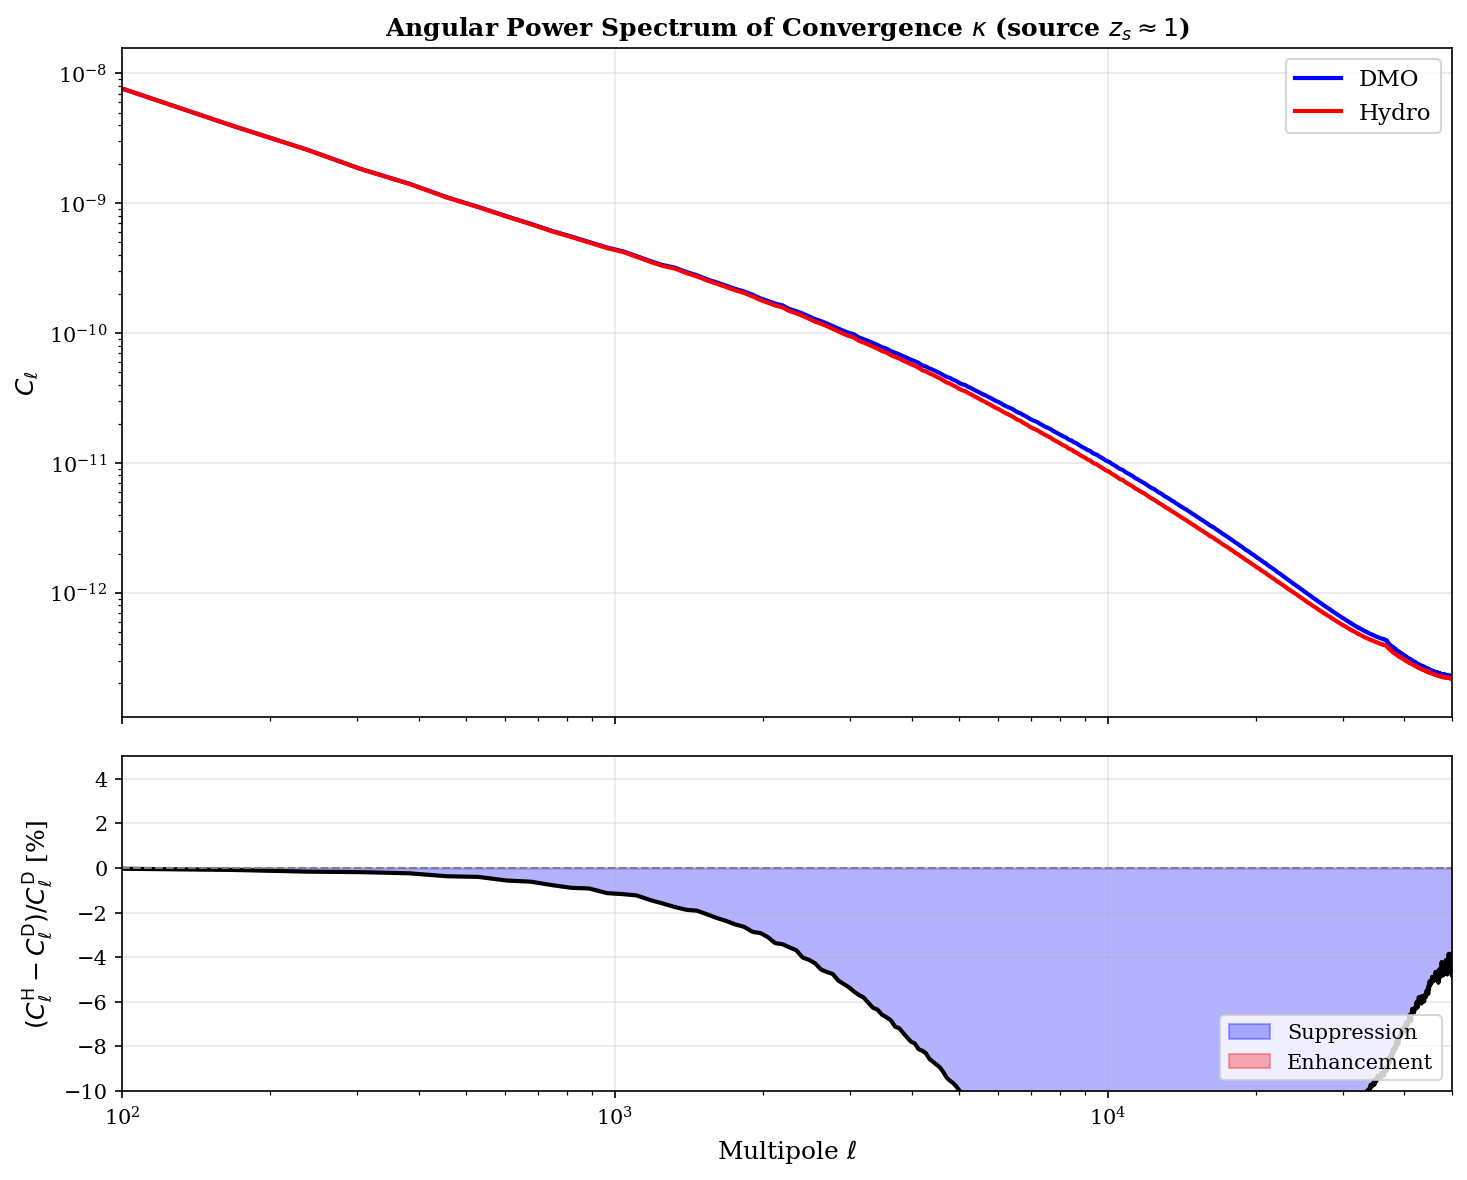


At ℓ=964:
  Baryonic effect: -1.1%


In [3]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8), height_ratios=[2, 1], sharex=True)

# Top panel: C_ell
ax1 = axes[0]
ax1.loglog(ell, S_D, 'b-', lw=2, label='DMO')
ax1.loglog(ell, S_H, 'r-', lw=2, label='Hydro')
ax1.set_ylabel(r'$C_\ell$', fontsize=12)
ax1.legend(loc='upper right', fontsize=11)
ax1.set_xlim(100, 50000)
ax1.grid(True, alpha=0.3)
ax1.set_title(r'Angular Power Spectrum of Convergence $\kappa$ (source $z_s \approx 1$)', fontsize=12, fontweight='bold')

# Bottom panel: Suppression ratio
ax2 = axes[1]
ratio = (S_H - S_D) / S_D * 100
ax2.semilogx(ell, ratio, 'k-', lw=2)
ax2.axhline(0, color='gray', ls='--', lw=1)
ax2.fill_between(ell, ratio, 0, where=(ratio < 0), alpha=0.3, color='blue', label='Suppression')
ax2.fill_between(ell, ratio, 0, where=(ratio > 0), alpha=0.3, color='red', label='Enhancement')
ax2.set_xlabel(r'Multipole $\ell$', fontsize=12)
ax2.set_ylabel(r'$(C_\ell^{\rm H} - C_\ell^{\rm D})/C_\ell^{\rm D}$ [%]', fontsize=12)
ax2.set_xlim(100, 50000)
ax2.set_ylim(-10, 5)
ax2.grid(True, alpha=0.3)
ax2.legend(loc='lower right', fontsize=10)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'fig_kappa_Cl_comparison.pdf')
plt.savefig(OUTPUT_DIR / 'fig_kappa_Cl_comparison.png', dpi=300)
plt.show()

# Key numbers
ell_target = 1000
idx = np.argmin(np.abs(ell - ell_target))
print(f"\nAt ℓ={ell[idx]:.0f}:")
print(f"  Baryonic effect: {ratio[idx]:.1f}%")

---
## Figure: Cumulative Response F(M_min, α) for C_ℓ

How much of the baryonic effect on C_ℓ is captured by halos above mass M_min within radius α×R_200?

In [4]:
# Build F matrix: F[mass_idx, alpha_idx]
masses = [1e12, 3.16e12, 1e13, 3.16e13]
alphas = [0.5, 1.0, 3.0, 5.0]

# ell range for averaging (typical lensing scales)
ell_min, ell_max = 500, 5000
ell_mask = (ell >= ell_min) & (ell <= ell_max)

F_matrix = np.zeros((len(masses), len(alphas)))
F_err_matrix = np.zeros((len(masses), len(alphas)))

for i, m in enumerate(masses):
    for j, a in enumerate(alphas):
        key = f'M{m:.1e}_a{a}'
        if key in cumulative_responses:
            F = cumulative_responses[key]['F_S']
            F_err = cumulative_responses[key]['F_S_err']
            F_matrix[i, j] = np.nanmean(F[ell_mask])
            F_err_matrix[i, j] = np.nanmean(F_err[ell_mask])

print("F(M_min, α) matrix:")
print(f"{'M_min':>12} |" + '|'.join([f'  α={a:.1f} ' for a in alphas]) + '|')
print('-'*55)
for i, m in enumerate(masses):
    row = f'{m:.2e} |'
    for j in range(len(alphas)):
        row += f'{F_matrix[i,j]:>7.2f} |'
    print(row)

F(M_min, α) matrix:
       M_min |  α=0.5 |  α=1.0 |  α=3.0 |  α=5.0 |
-------------------------------------------------------
1.00e+12 |   1.14 |   1.24 |   1.09 |   1.00 |
3.16e+12 |   1.05 |   1.09 |   1.00 |   0.94 |
1.00e+13 |   0.71 |   0.63 |   0.65 |   0.67 |
3.16e+13 |   0.14 |   0.04 |   0.20 |   0.24 |


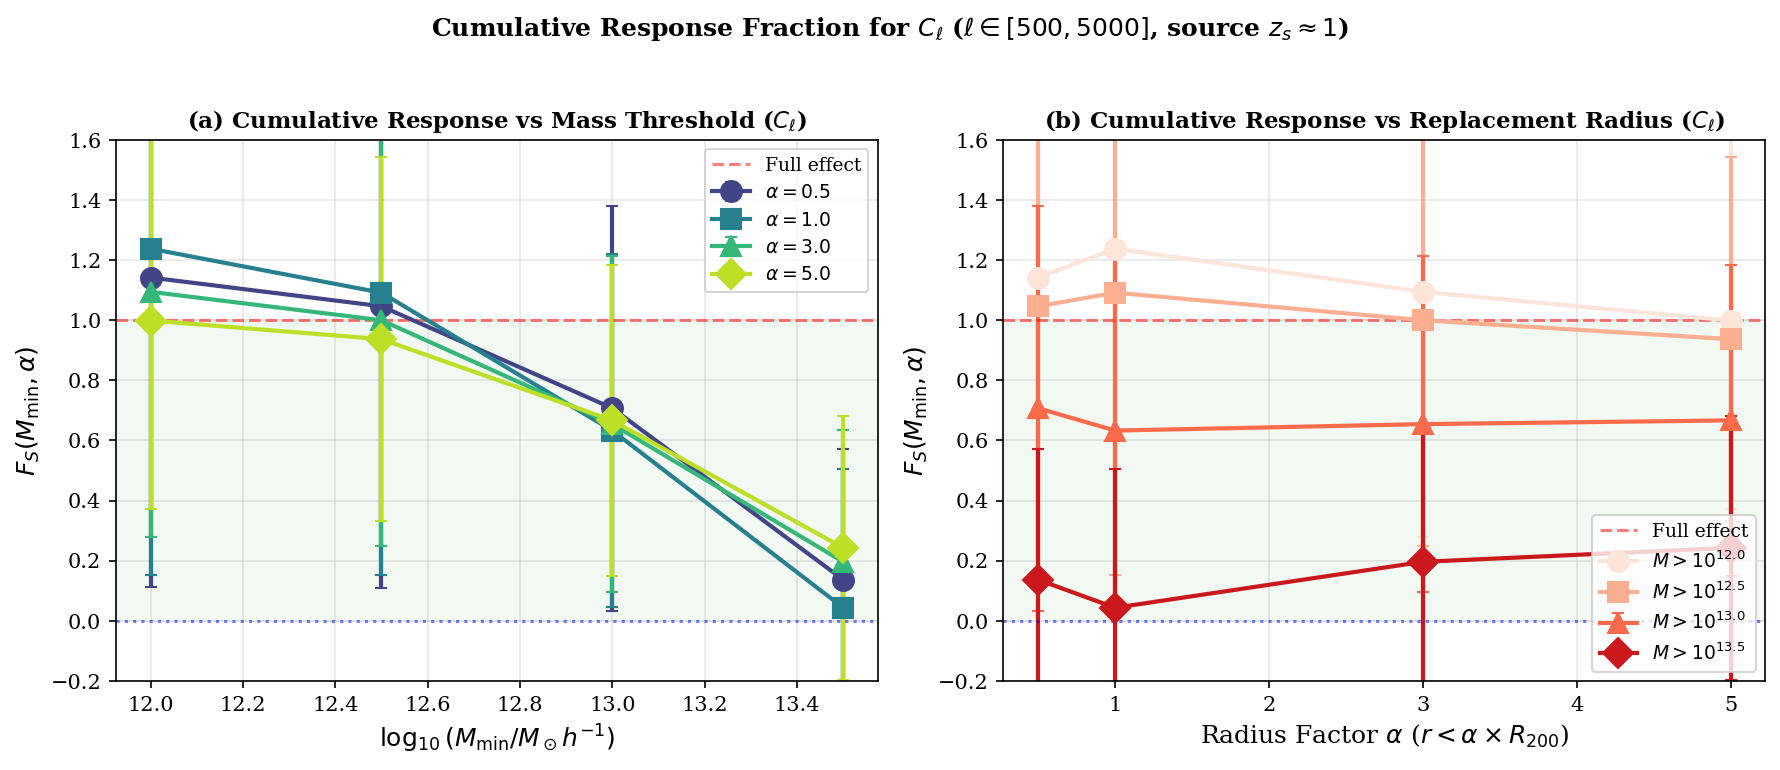


=== Key Insights ===
At α=5, M>10¹² captures 100% of C_ℓ suppression
At α=5, M>10¹³.⁵ captures only 24%
Response overshoots 100% likely due to cosmic variance in limited realizations


In [5]:
# Create 2-panel figure: F vs M_min and F vs α
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

LOG_MASS = [12.0, 12.5, 13.0, 13.5]
colors_alpha = plt.cm.viridis(np.linspace(0.2, 0.9, len(alphas)))
markers = ['o', 's', '^', 'D']

# Left: F vs M_min at fixed α
ax1 = axes[0]
for j, (a, marker) in enumerate(zip(alphas, markers)):
    ax1.errorbar(LOG_MASS, F_matrix[:, j], yerr=F_err_matrix[:, j],
                 marker=marker, color=colors_alpha[j], lw=2, ms=10, 
                 capsize=3, label=fr'$\alpha = {a}$')

ax1.axhline(1.0, color='red', ls='--', lw=1.5, alpha=0.5, label='Full effect')
ax1.axhline(0.0, color='blue', ls=':', lw=1.5, alpha=0.5)
ax1.axhspan(0, 1, alpha=0.05, color='green')
ax1.set_xlabel(r'$\log_{10}(M_{\min} / M_\odot h^{-1})$', fontsize=12)
ax1.set_ylabel(r'$F_S(M_{\min}, \alpha)$', fontsize=12)
ax1.set_title(r'(a) Cumulative Response vs Mass Threshold ($C_\ell$)', fontsize=11, fontweight='bold')
ax1.legend(loc='upper right', fontsize=9)
ax1.set_ylim(-0.2, 1.6)
ax1.grid(True, alpha=0.3)

# Right: F vs α at fixed M_min
ax2 = axes[1]
for i, (m, marker) in enumerate(zip(masses, markers)):
    ax2.errorbar(alphas, F_matrix[i, :], yerr=F_err_matrix[i, :],
                 marker=marker, color=COLORS_MASS[3-i], lw=2, ms=10,
                 capsize=3, label=MASS_LABELS[i])

ax2.axhline(1.0, color='red', ls='--', lw=1.5, alpha=0.5, label='Full effect')
ax2.axhline(0.0, color='blue', ls=':', lw=1.5, alpha=0.5)
ax2.axhspan(0, 1, alpha=0.05, color='green')
ax2.set_xlabel(r'Radius Factor $\alpha$ ($r < \alpha \times R_{200}$)', fontsize=12)
ax2.set_ylabel(r'$F_S(M_{\min}, \alpha)$', fontsize=12)
ax2.set_title(r'(b) Cumulative Response vs Replacement Radius ($C_\ell$)', fontsize=11, fontweight='bold')
ax2.legend(loc='lower right', fontsize=9)
ax2.set_ylim(-0.2, 1.6)
ax2.grid(True, alpha=0.3)

plt.suptitle(r'Cumulative Response Fraction for $C_\ell$ ($\ell \in [500, 5000]$, source $z_s \approx 1$)', 
             fontsize=12, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'fig_kappa_cumulative_response.pdf')
plt.savefig(OUTPUT_DIR / 'fig_kappa_cumulative_response.png', dpi=300)
plt.show()

# Key insights
print("\n=== Key Insights ===")
print(f"At α=5, M>10¹² captures {F_matrix[0,3]*100:.0f}% of C_ℓ suppression")
print(f"At α=5, M>10¹³.⁵ captures only {F_matrix[3,3]*100:.0f}%")
print(f"Response overshoots 100% likely due to cosmic variance in limited realizations")

---
## Figure: Scale-Dependent Response F(ℓ)

How does the response fraction vary with multipole ℓ?

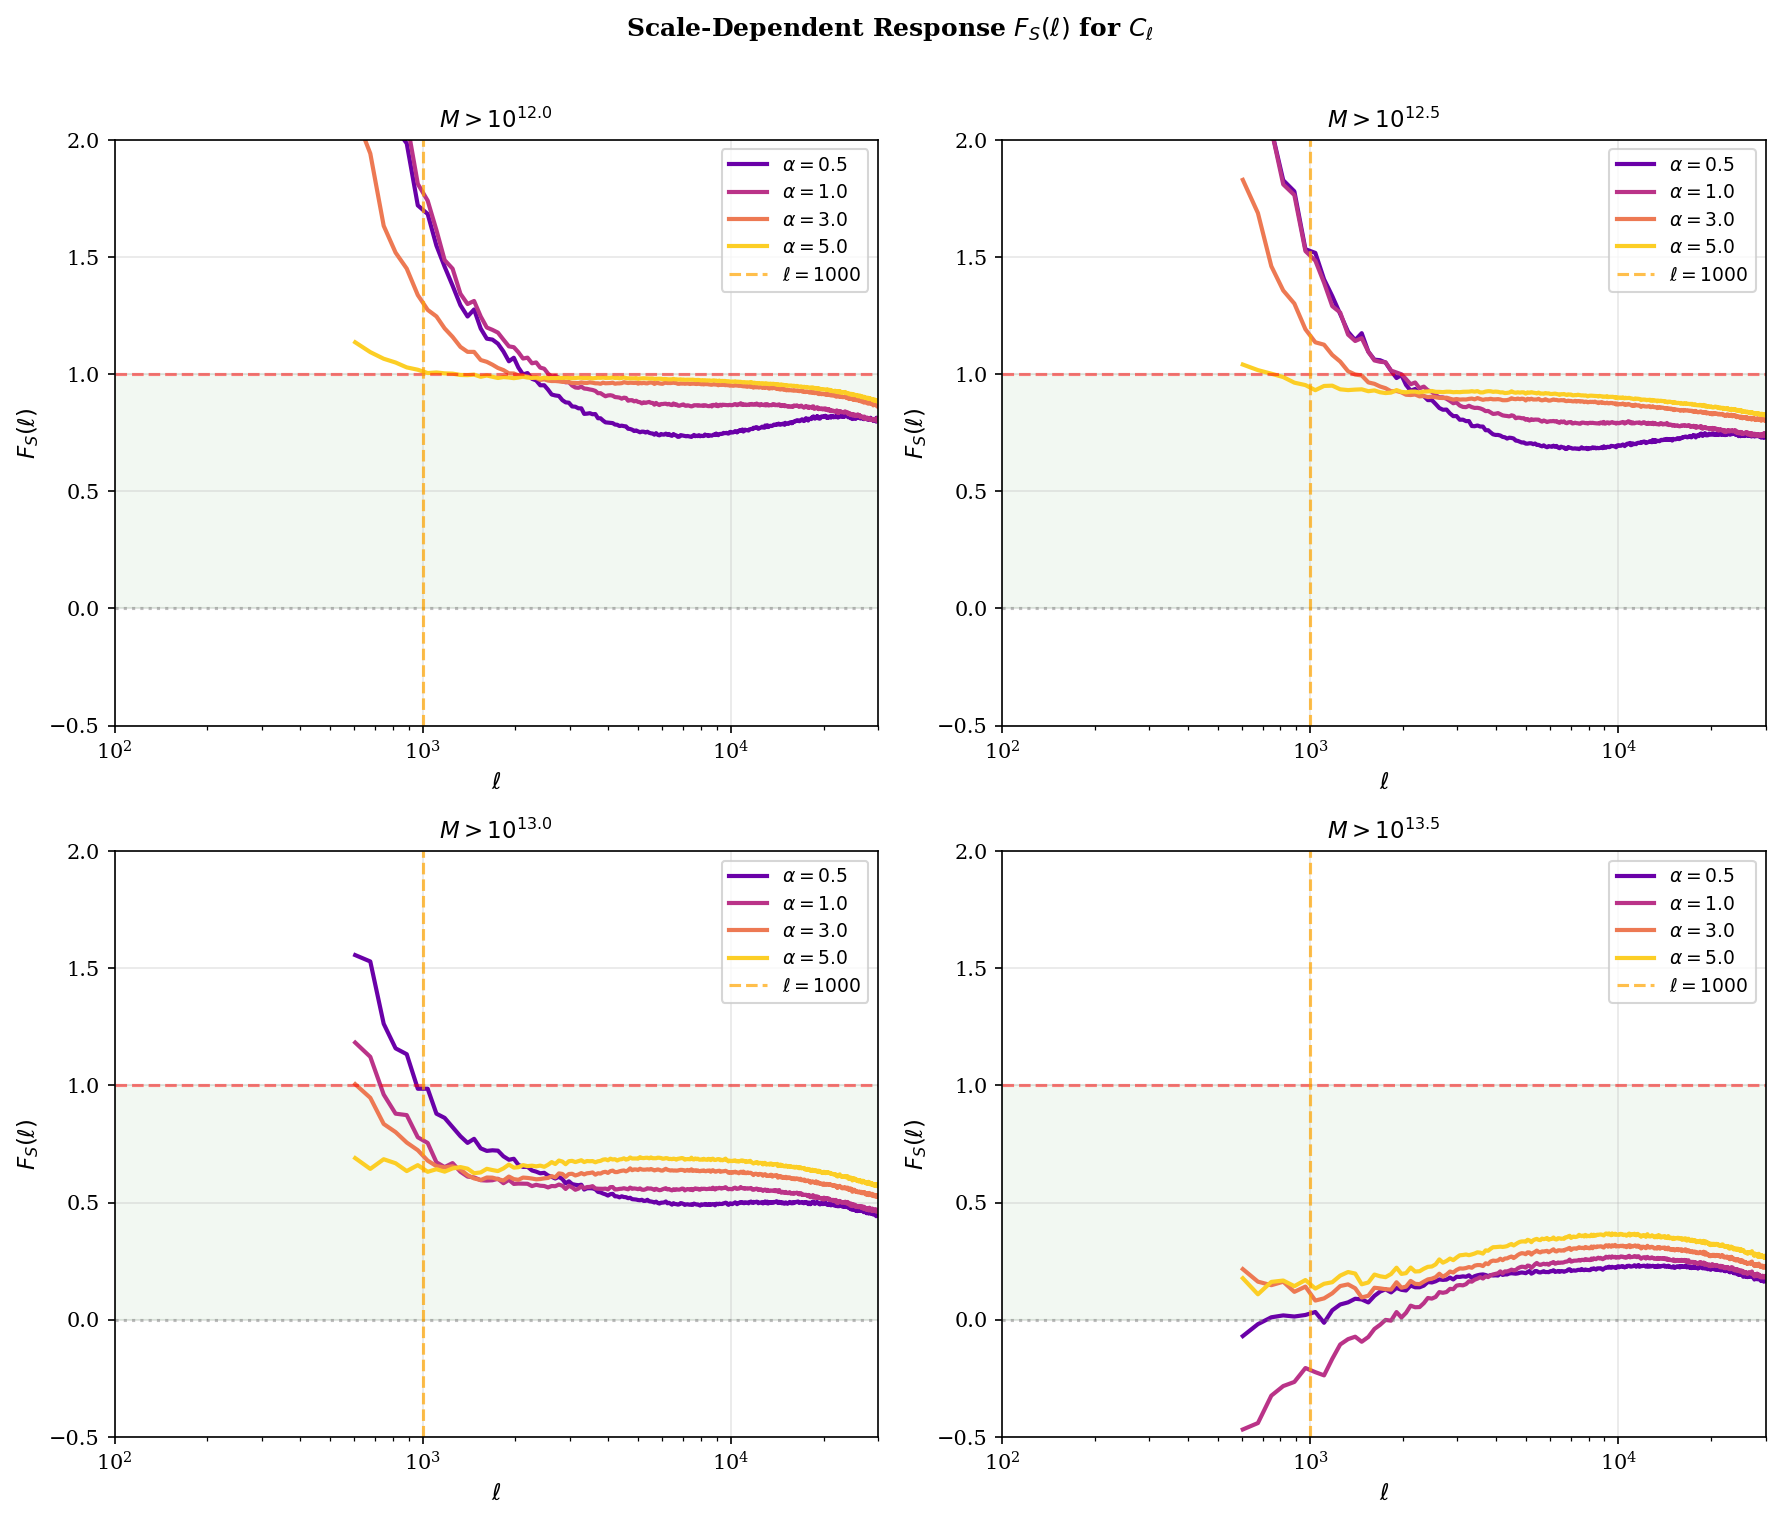

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

colors_r = plt.cm.plasma(np.linspace(0.2, 0.9, len(alphas)))

# Mask where baryonic effect is significant
significant = np.abs(Delta_S) > 0.005 * np.abs(S_D)

for i, m in enumerate(masses):
    ax = axes.flat[i]
    
    for j, a in enumerate(alphas):
        key = f'M{m:.1e}_a{a}'
        if key in cumulative_responses:
            F = cumulative_responses[key]['F_S'].copy()
            F[~significant] = np.nan
            ax.semilogx(ell, F, lw=2, color=colors_r[j], label=fr'$\alpha = {a}$')
    
    ax.axhline(1.0, color='red', ls='--', lw=1.5, alpha=0.5)
    ax.axhline(0.0, color='gray', ls=':', lw=1.5, alpha=0.5)
    ax.axhspan(0, 1, alpha=0.05, color='green')
    ax.axvline(1000, color='orange', ls='--', lw=1.5, alpha=0.7, label=r'$\ell=1000$')
    
    ax.set_xlabel(r'$\ell$', fontsize=11)
    ax.set_ylabel(r'$F_S(\ell)$', fontsize=11)
    ax.set_title(MASS_LABELS[i], fontsize=11, fontweight='bold')
    ax.legend(loc='upper right', fontsize=9)
    ax.set_ylim(-0.5, 2.0)
    ax.set_xlim(100, 30000)
    ax.grid(True, alpha=0.3)

plt.suptitle(r'Scale-Dependent Response $F_S(\ell)$ for $C_\ell$', fontsize=12, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'fig_kappa_scale_dependent_response.pdf')
plt.savefig(OUTPUT_DIR / 'fig_kappa_scale_dependent_response.png', dpi=300)
plt.show()

---
## Comparison: Density P(k) vs Lensing C_ℓ

Load the density statistics and compare the response hierarchies.

In [7]:
import h5py

# Load density P(k) statistics
DENSITY_DIR = Path('density_statistics_cache')

def load_density_stats(model_name, snapshot_id=0):
    """Load density P(k) for a model at given snapshot."""
    fname = DENSITY_DIR / f'{model_name}_density_stats.h5'
    if not fname.exists():
        return None
    
    with h5py.File(fname, 'r') as f:
        k = f['k'][:]
        Pk = f['Pk'][:]
        snapshot_ids = f['snapshot_ids'][:]
        
        mask = snapshot_ids == snapshot_id
        if not np.any(mask):
            return None
        
        return {'k': k, 'Pk': np.mean(Pk[mask], axis=0)}

# Load DMO and Hydro at z=0 (snapshot 0)
dmo_density = load_density_stats('dmo', 0)
hydro_density = load_density_stats('hydro', 0)

if dmo_density is not None and hydro_density is not None:
    # Compute F for density at k ∈ [1, 30] h/Mpc
    k_arr = dmo_density['k']
    k_mask = (k_arr >= 1.0) & (k_arr <= 30.0)
    
    Delta_Pk = hydro_density['Pk'] - dmo_density['Pk']
    
    F_density = np.zeros((len(masses), len(alphas)))
    
    for i, m in enumerate(masses):
        ml_str = f'{m:.2e}'
        for j, a in enumerate(alphas):
            model_name = f'hydro_replace_Ml_{ml_str}_Mu_inf_R_{a}'
            replace_stats = load_density_stats(model_name, 0)
            if replace_stats is not None:
                F_k = (replace_stats['Pk'] - dmo_density['Pk']) / Delta_Pk
                F_density[i, j] = np.nanmean(F_k[k_mask])
    
    print("=== Comparison: Density P(k) vs Lensing C_ℓ ===")
    print(f"\n{'Model':25s} | {'P(k) F':>8s} | {'C_ℓ F':>8s} | {'Diff':>8s}")
    print('='*55)
    for i, m in enumerate(masses):
        for j, a in enumerate(alphas):
            F_pk = F_density[i, j]
            F_cl = F_matrix[i, j]
            diff = F_cl - F_pk
            label = f'M>{m:.0e}, α={a}'
            print(f'{label:25s} | {F_pk:8.2f} | {F_cl:8.2f} | {diff:+8.2f}')
else:
    print("Density statistics not found - run 07_publication_figures.ipynb first")

Density statistics not found - run 07_publication_figures.ipynb first


---
## Peak Counts Analysis (κ bins)

Peak counts measure the abundance of high-convergence regions (galaxy clusters, groups). Baryonic feedback affects peak heights by redistributing mass within halos.

**Key difference from SNR analysis**: Here we bin peaks/minima by raw κ values instead of SNR (κ/σ):
- **Peaks**: κ ∈ [-0.05, 0.2] - 25 bins
- **Minima**: κ ∈ [-0.07, 0.07] - 28 bins

In [8]:
# ============================================================
# Load peaks and minima data (KAPPA BINS, not SNR)
# ============================================================

# Load peaks data
peaks_data = np.load(DATA_DIR / 'response_peaks_z23.npz', allow_pickle=True)
with open(DATA_DIR / 'response_peaks_z23_dicts.pkl', 'rb') as f:
    peaks_dicts = pickle.load(f)

# Extract kappa bins from the data
PEAK_KAPPA_BINS = peaks_data['kappa_bins']
peak_kappa_mid = peaks_data['kappa_mid']

peaks_S_D = peaks_data['S_D']
peaks_S_H = peaks_data['S_H']
peaks_Delta_S = peaks_data['Delta_S']
peaks_cumulative = peaks_dicts['cumulative_responses']

# Load minima data  
minima_data = np.load(DATA_DIR / 'response_minima_z23.npz', allow_pickle=True)
with open(DATA_DIR / 'response_minima_z23_dicts.pkl', 'rb') as f:
    minima_dicts = pickle.load(f)

MINIMA_KAPPA_BINS = minima_data['kappa_bins']
minima_kappa_mid = minima_data['kappa_mid']

minima_S_D = minima_data['S_D']
minima_S_H = minima_data['S_H']
minima_Delta_S = minima_data['Delta_S']
minima_cumulative = minima_dicts['cumulative_responses']

print("=== Peak Counts (κ bins) ===")
print(f"Number of κ bins: {len(peak_kappa_mid)} (expected: {len(peaks_S_D)})")
print(f"κ bin range: [{PEAK_KAPPA_BINS[0]:.3f}, {PEAK_KAPPA_BINS[-1]:.3f}]")
print(f"DMO peak counts (total): {peaks_S_D.sum():.1f}")
print(f"Hydro peak counts (total): {peaks_S_H.sum():.1f}")
print(f"Baryonic effect (H-D) total: {peaks_Delta_S.sum():.1f}")

print("\n=== Minima (Void) Counts (κ bins) ===")
print(f"Number of κ bins: {len(minima_kappa_mid)} (expected: {len(minima_S_D)})")
print(f"κ bin range: [{MINIMA_KAPPA_BINS[0]:.3f}, {MINIMA_KAPPA_BINS[-1]:.3f}]")
print(f"DMO minima counts (total): {minima_S_D.sum():.1f}")
print(f"Hydro minima counts (total): {minima_S_H.sum():.1f}")
print(f"Baryonic effect (H-D) total: {minima_Delta_S.sum():.1f}")

=== Peak Counts (κ bins) ===
Number of κ bins: 25 (expected: 25)
κ bin range: [-0.050, 0.200]
DMO peak counts (total): 684.6
Hydro peak counts (total): 672.6
Baryonic effect (H-D) total: -12.0

=== Minima (Void) Counts (κ bins) ===
Number of κ bins: 28 (expected: 28)
κ bin range: [-0.070, 0.070]
DMO minima counts (total): 629.4
Hydro minima counts (total): 617.4
Baryonic effect (H-D) total: -11.9


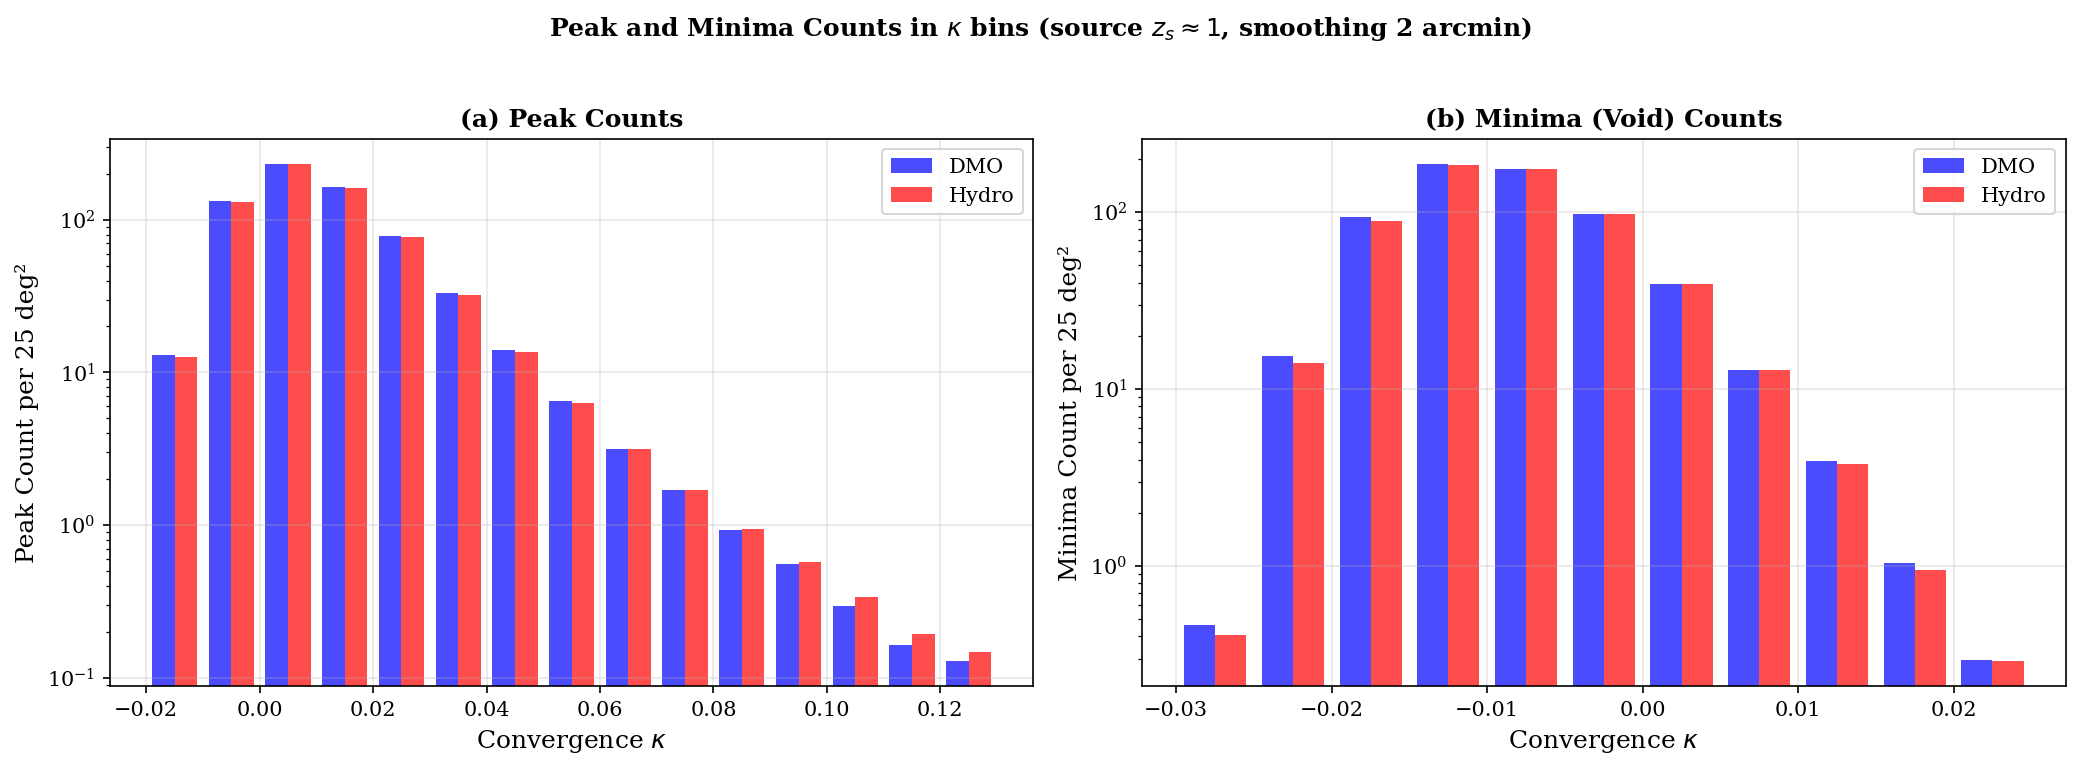


=== Baryonic Effect on Peaks (κ > 0.05) ===
  κ=0.055: ΔN/N = -3.18%
  κ=0.065: ΔN/N = 0.63%
  κ=0.075: ΔN/N = 0.24%

=== Baryonic Effect on Minima (κ < 0) ===
  κ=-0.023: ΔN/N = -8.68%
  κ=-0.018: ΔN/N = -4.84%
  κ=-0.013: ΔN/N = -2.31%
  κ=-0.008: ΔN/N = -0.62%
  κ=-0.003: ΔN/N = 0.00%


In [9]:
# ============================================================
# Figure: Peak and Minima Count Comparison (DMO vs Hydro)
# Using KAPPA bins instead of SNR
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Peak counts
ax1 = axes[0]
width = (peak_kappa_mid[1] - peak_kappa_mid[0]) * 0.4

# Only plot bins with significant counts
peak_mask = (peaks_S_D > 0.1) | (peaks_S_H > 0.1)
kappa_peaks = peak_kappa_mid[peak_mask]

bars1 = ax1.bar(kappa_peaks - width/2, peaks_S_D[peak_mask], width, label='DMO', color='blue', alpha=0.7)
bars2 = ax1.bar(kappa_peaks + width/2, peaks_S_H[peak_mask], width, label='Hydro', color='red', alpha=0.7)

ax1.set_xlabel(r'Convergence $\kappa$', fontsize=12)
ax1.set_ylabel('Peak Count per 25 deg²', fontsize=12)
ax1.set_title('(a) Peak Counts', fontsize=12, fontweight='bold')
ax1.legend(loc='upper right')
ax1.set_yscale('log')
ax1.grid(True, alpha=0.3)

# Right: Minima (void) counts  
ax2 = axes[1]
width_min = (minima_kappa_mid[1] - minima_kappa_mid[0]) * 0.4

minima_mask = (minima_S_D > 0.1) | (minima_S_H > 0.1)
kappa_minima = minima_kappa_mid[minima_mask]

bars3 = ax2.bar(kappa_minima - width_min/2, minima_S_D[minima_mask], width_min, label='DMO', color='blue', alpha=0.7)
bars4 = ax2.bar(kappa_minima + width_min/2, minima_S_H[minima_mask], width_min, label='Hydro', color='red', alpha=0.7)

ax2.set_xlabel(r'Convergence $\kappa$', fontsize=12)
ax2.set_ylabel('Minima Count per 25 deg²', fontsize=12)
ax2.set_title('(b) Minima (Void) Counts', fontsize=12, fontweight='bold')
ax2.legend(loc='upper right')
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3)

plt.suptitle(r'Peak and Minima Counts in $\kappa$ bins (source $z_s \approx 1$, smoothing 2 arcmin)', 
             fontsize=12, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'fig_kappa_peaks_minima_comparison.pdf')
plt.savefig(OUTPUT_DIR / 'fig_kappa_peaks_minima_comparison.png', dpi=300)
plt.show()

# Print baryonic effect
print("\n=== Baryonic Effect on Peaks (κ > 0.05) ===")
peak_kappa_mask = peak_kappa_mid >= 0.05
for i, kappa in enumerate(peak_kappa_mid):
    if peak_kappa_mask[i] and peaks_S_D[i] > 1:
        pct = peaks_Delta_S[i] / peaks_S_D[i] * 100
        print(f"  κ={kappa:.3f}: ΔN/N = {pct:.2f}%")

print("\n=== Baryonic Effect on Minima (κ < 0) ===")
minima_kappa_mask = minima_kappa_mid < 0
for i, kappa in enumerate(minima_kappa_mid):
    if minima_kappa_mask[i] and minima_S_D[i] > 1:
        pct = minima_Delta_S[i] / minima_S_D[i] * 100
        print(f"  κ={kappa:.3f}: ΔN/N = {pct:.2f}%")

---
## Cumulative Response F(M_min, α) for Peaks and Minima

Apply the same response formalism to peak and minima counts, using κ bins:
- **Peaks**: Average F over κ > 0.05 (high-κ cluster-like peaks)
- **Minima**: Average F over κ < 0 (void-like underdensities)

In [10]:
# ============================================================
# Build F matrices for Peaks and Minima (using KAPPA bins)
# ============================================================

def compute_F_matrix_from_cumulative(cumulative_responses, kappa_mask, masses, alphas):
    """Compute F(M_min, α) matrix from cumulative responses."""
    F_matrix = np.full((len(masses), len(alphas)), np.nan)
    F_err_matrix = np.full((len(masses), len(alphas)), np.nan)
    
    for i, m in enumerate(masses):
        for j, a in enumerate(alphas):
            key = f'M{m:.1e}_a{a}'
            if key in cumulative_responses:
                F = cumulative_responses[key]['F_S']
                F_err = cumulative_responses[key]['F_S_err']
                
                # Only use valid (finite) values in the kappa range
                valid = kappa_mask & np.isfinite(F)
                if np.sum(valid) > 0:
                    F_matrix[i, j] = np.nanmean(F[valid])
                    F_err_matrix[i, j] = np.nanmean(F_err[valid])
    
    return F_matrix, F_err_matrix

# Peaks: Use kappa bins > 0.05 (high peaks corresponding to clusters)
peaks_kappa_mask = peak_kappa_mid >= 0.05
F_peaks, F_peaks_err = compute_F_matrix_from_cumulative(peaks_cumulative, peaks_kappa_mask, masses, alphas)

# Minima: Use kappa bins < 0 (void-like regions)
minima_kappa_mask = minima_kappa_mid < 0
F_minima, F_minima_err = compute_F_matrix_from_cumulative(minima_cumulative, minima_kappa_mask, masses, alphas)

print("=== Peaks F(M_min, α) matrix (κ > 0.05) ===")
print(f"{'M_min':>12} |" + '|'.join([f'  α={a:.1f} ' for a in alphas]) + '|')
print('-'*55)
for i, m in enumerate(masses):
    row = f'{m:.2e} |'
    for j in range(len(alphas)):
        if np.isfinite(F_peaks[i,j]):
            row += f'{F_peaks[i,j]:>7.2f} |'
        else:
            row += f'{"N/A":>7} |'
    print(row)

print("\n=== Minima F(M_min, α) matrix (κ < 0) ===")
print(f"{'M_min':>12} |" + '|'.join([f'  α={a:.1f} ' for a in alphas]) + '|')
print('-'*55)
for i, m in enumerate(masses):
    row = f'{m:.2e} |'
    for j in range(len(alphas)):
        if np.isfinite(F_minima[i,j]):
            row += f'{F_minima[i,j]:>7.2f} |'
        else:
            row += f'{"N/A":>7} |'
    print(row)

=== Peaks F(M_min, α) matrix (κ > 0.05) ===
       M_min |  α=0.5 |  α=1.0 |  α=3.0 |  α=5.0 |
-------------------------------------------------------
1.00e+12 |   1.01 |   0.60 |   0.84 |   1.00 |
3.16e+12 |   1.01 |   0.76 |   0.93 |   1.07 |
1.00e+13 |   0.95 |   1.12 |   0.75 |   0.76 |
3.16e+13 |   1.51 |   1.42 |   1.01 |   1.00 |

=== Minima F(M_min, α) matrix (κ < 0) ===
       M_min |  α=0.5 |  α=1.0 |  α=3.0 |  α=5.0 |
-------------------------------------------------------
1.00e+12 |   0.60 |   0.81 |   0.96 |   1.02 |
3.16e+12 |   0.53 |   0.63 |   0.81 |   0.83 |
1.00e+13 |   0.27 |   0.30 |   0.39 |   0.51 |
3.16e+13 |   0.03 |   0.06 |   0.09 |   0.15 |


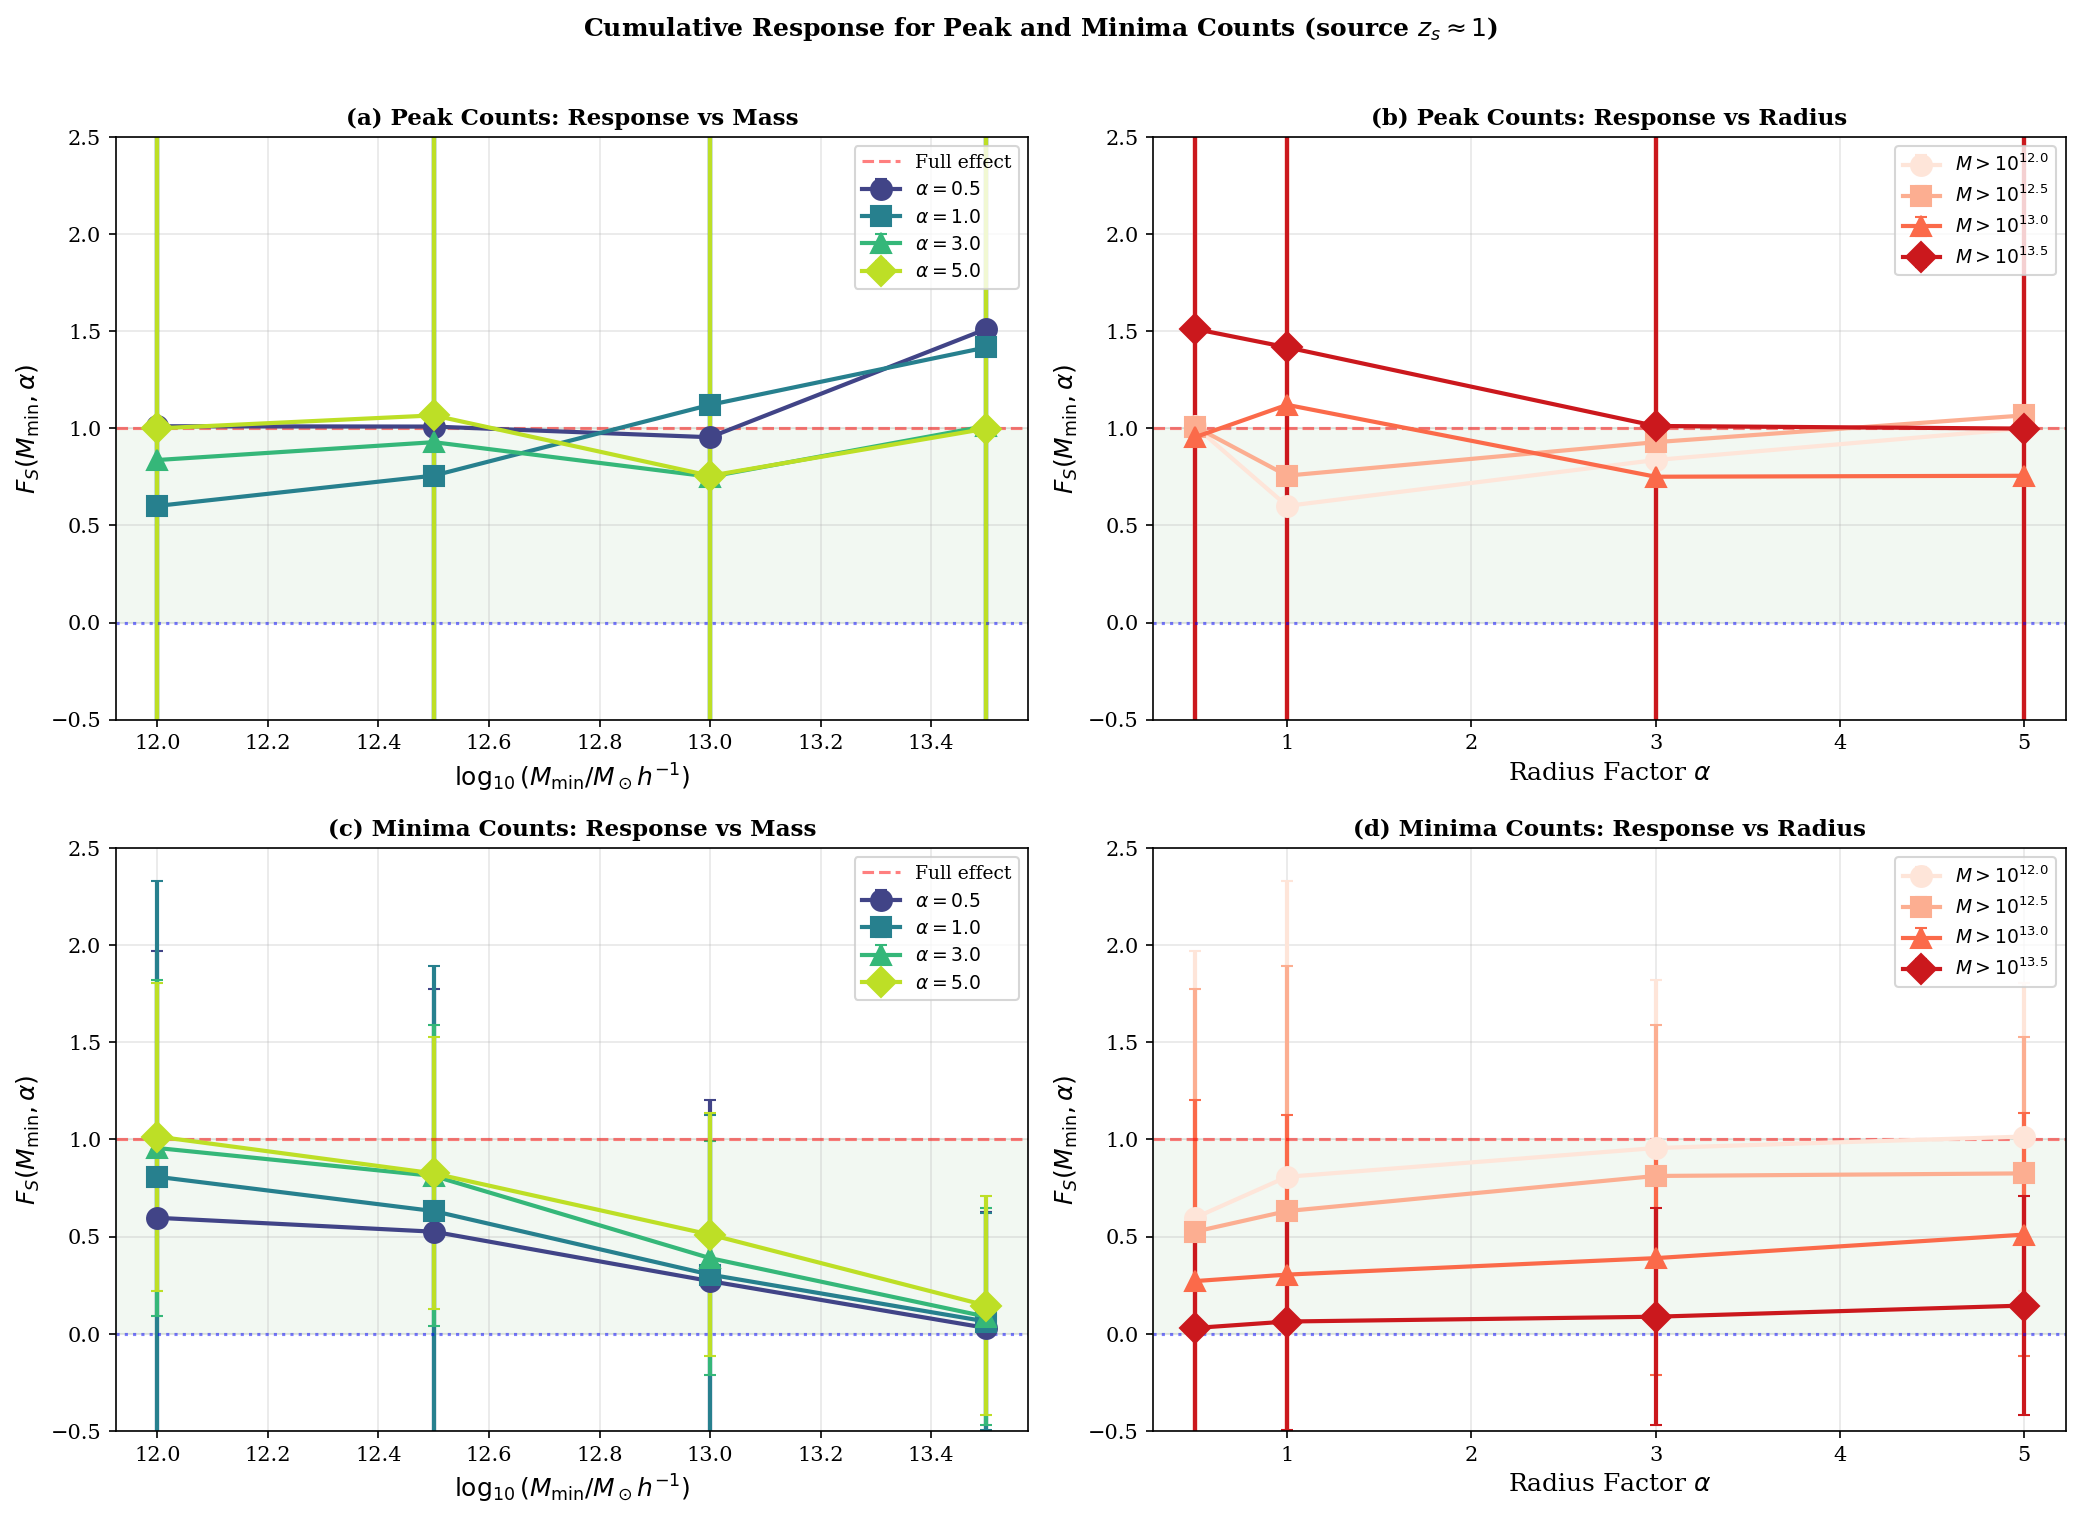

In [11]:
# ============================================================
# Figure: Cumulative Response for Peaks and Minima (2x2 panel)
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

LOG_MASS = [12.0, 12.5, 13.0, 13.5]
colors_alpha = plt.cm.viridis(np.linspace(0.2, 0.9, len(alphas)))
markers = ['o', 's', '^', 'D']

# Top-left: Peaks F vs M_min
ax = axes[0, 0]
for j, (a, marker) in enumerate(zip(alphas, markers)):
    valid = np.isfinite(F_peaks[:, j])
    if np.any(valid):
        ax.errorbar(np.array(LOG_MASS)[valid], F_peaks[valid, j], 
                   yerr=F_peaks_err[valid, j] if np.any(np.isfinite(F_peaks_err[valid, j])) else None,
                   marker=marker, color=colors_alpha[j], lw=2, ms=10, 
                   capsize=3, label=fr'$\alpha = {a}$')
ax.axhline(1.0, color='red', ls='--', lw=1.5, alpha=0.5, label='Full effect')
ax.axhline(0.0, color='blue', ls=':', lw=1.5, alpha=0.5)
ax.axhspan(0, 1, alpha=0.05, color='green')
ax.set_xlabel(r'$\log_{10}(M_{\min} / M_\odot h^{-1})$', fontsize=12)
ax.set_ylabel(r'$F_S(M_{\min}, \alpha)$', fontsize=12)
ax.set_title('(a) Peak Counts: Response vs Mass', fontsize=11, fontweight='bold')
ax.legend(loc='upper right', fontsize=9)
ax.set_ylim(-0.5, 2.5)
ax.grid(True, alpha=0.3)

# Top-right: Peaks F vs α
ax = axes[0, 1]
for i, (m, marker) in enumerate(zip(masses, markers)):
    valid = np.isfinite(F_peaks[i, :])
    if np.any(valid):
        ax.errorbar(np.array(alphas)[valid], F_peaks[i, valid],
                   yerr=F_peaks_err[i, valid] if np.any(np.isfinite(F_peaks_err[i, valid])) else None,
                   marker=marker, color=COLORS_MASS[3-i], lw=2, ms=10,
                   capsize=3, label=MASS_LABELS[i])
ax.axhline(1.0, color='red', ls='--', lw=1.5, alpha=0.5)
ax.axhline(0.0, color='blue', ls=':', lw=1.5, alpha=0.5)
ax.axhspan(0, 1, alpha=0.05, color='green')
ax.set_xlabel(r'Radius Factor $\alpha$', fontsize=12)
ax.set_ylabel(r'$F_S(M_{\min}, \alpha)$', fontsize=12)
ax.set_title('(b) Peak Counts: Response vs Radius', fontsize=11, fontweight='bold')
ax.legend(loc='upper right', fontsize=9)
ax.set_ylim(-0.5, 2.5)
ax.grid(True, alpha=0.3)

# Bottom-left: Minima F vs M_min
ax = axes[1, 0]
for j, (a, marker) in enumerate(zip(alphas, markers)):
    valid = np.isfinite(F_minima[:, j])
    if np.any(valid):
        ax.errorbar(np.array(LOG_MASS)[valid], F_minima[valid, j],
                   yerr=F_minima_err[valid, j] if np.any(np.isfinite(F_minima_err[valid, j])) else None,
                   marker=marker, color=colors_alpha[j], lw=2, ms=10,
                   capsize=3, label=fr'$\alpha = {a}$')
ax.axhline(1.0, color='red', ls='--', lw=1.5, alpha=0.5, label='Full effect')
ax.axhline(0.0, color='blue', ls=':', lw=1.5, alpha=0.5)
ax.axhspan(0, 1, alpha=0.05, color='green')
ax.set_xlabel(r'$\log_{10}(M_{\min} / M_\odot h^{-1})$', fontsize=12)
ax.set_ylabel(r'$F_S(M_{\min}, \alpha)$', fontsize=12)
ax.set_title('(c) Minima Counts: Response vs Mass', fontsize=11, fontweight='bold')
ax.legend(loc='upper right', fontsize=9)
ax.set_ylim(-0.5, 2.5)
ax.grid(True, alpha=0.3)

# Bottom-right: Minima F vs α
ax = axes[1, 1]
for i, (m, marker) in enumerate(zip(masses, markers)):
    valid = np.isfinite(F_minima[i, :])
    if np.any(valid):
        ax.errorbar(np.array(alphas)[valid], F_minima[i, valid],
                   yerr=F_minima_err[i, valid] if np.any(np.isfinite(F_minima_err[i, valid])) else None,
                   marker=marker, color=COLORS_MASS[3-i], lw=2, ms=10,
                   capsize=3, label=MASS_LABELS[i])
ax.axhline(1.0, color='red', ls='--', lw=1.5, alpha=0.5)
ax.axhline(0.0, color='blue', ls=':', lw=1.5, alpha=0.5)
ax.axhspan(0, 1, alpha=0.05, color='green')
ax.set_xlabel(r'Radius Factor $\alpha$', fontsize=12)
ax.set_ylabel(r'$F_S(M_{\min}, \alpha)$', fontsize=12)
ax.set_title('(d) Minima Counts: Response vs Radius', fontsize=11, fontweight='bold')
ax.legend(loc='upper right', fontsize=9)
ax.set_ylim(-0.5, 2.5)
ax.grid(True, alpha=0.3)

plt.suptitle(r'Cumulative Response for Peak and Minima Counts (source $z_s \approx 1$)', 
             fontsize=12, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'fig_kappa_peaks_minima_response.pdf')
plt.savefig(OUTPUT_DIR / 'fig_kappa_peaks_minima_response.png', dpi=300)
plt.show()

---
## Mass Contribution Hierarchy (Publication Figure)

Stacked bar chart showing how different mass bins contribute to the baryonic effect, similar to the density P(k) analysis.

In [12]:
# ============================================================
# Figure: Mass Contribution Hierarchy for All Three Statistics
# ============================================================

# Calculate differential contributions from cumulative F values at α=5.0
# ΔF_bin = F(M>M_lower) - F(M>M_upper)

MASS_BINS_REV = ['10¹³.⁵+', '10¹³-10¹³.⁵', '10¹².⁵-10¹³', '10¹²-10¹².⁵']

def compute_differential_contributions(F_matrix):
    """Convert cumulative F to differential contributions by mass bin."""
    # F_matrix[i, j] = F(M > masses[i], α = alphas[j])
    # At α=5 (index 3):
    F_at_a5 = F_matrix[:, 3] * 100  # Convert to percent
    
    # Differential contributions (highest mass first)
    contributions = np.array([
        F_at_a5[3],                      # 10^13.5+ (highest mass alone)
        F_at_a5[2] - F_at_a5[3],         # 10^13-10^13.5
        F_at_a5[1] - F_at_a5[2],         # 10^12.5-10^13  
        F_at_a5[0] - F_at_a5[1],         # 10^12-10^12.5 (lowest mass)
    ])
    return contributions

# Compute for all three statistics
contrib_Cl = compute_differential_contributions(F_matrix)  # C_ell from earlier
contrib_peaks = compute_differential_contributions(F_peaks)
contrib_minima = compute_differential_contributions(F_minima)

# Handle NaN by setting to 0
contrib_Cl = np.nan_to_num(contrib_Cl, nan=0)
contrib_peaks = np.nan_to_num(contrib_peaks, nan=0)
contrib_minima = np.nan_to_num(contrib_minima, nan=0)

print("=== Differential Mass Contributions at α=5.0 ===")
print(f"{'Mass bin':20s} | {'C_ℓ':>8s} | {'Peaks':>8s} | {'Minima':>8s}")
print('='*55)
for i, label in enumerate(MASS_BINS_REV):
    print(f'{label:20s} | {contrib_Cl[i]:7.1f}% | {contrib_peaks[i]:7.1f}% | {contrib_minima[i]:7.1f}%')
print('-'*55)
print(f'{"Total":20s} | {np.sum(contrib_Cl):7.1f}% | {np.sum(contrib_peaks):7.1f}% | {np.sum(contrib_minima):7.1f}%')

=== Differential Mass Contributions at α=5.0 ===
Mass bin             |      C_ℓ |    Peaks |   Minima
10¹³.⁵+              |    24.3% |    99.8% |    14.5%
10¹³-10¹³.⁵          |    42.4% |   -24.3% |    36.5%
10¹².⁵-10¹³          |    27.0% |    31.1% |    31.5%
10¹²-10¹².⁵          |     6.2% |    -6.7% |    19.0%
-------------------------------------------------------
Total                |    99.9% |    99.9% |   101.5%


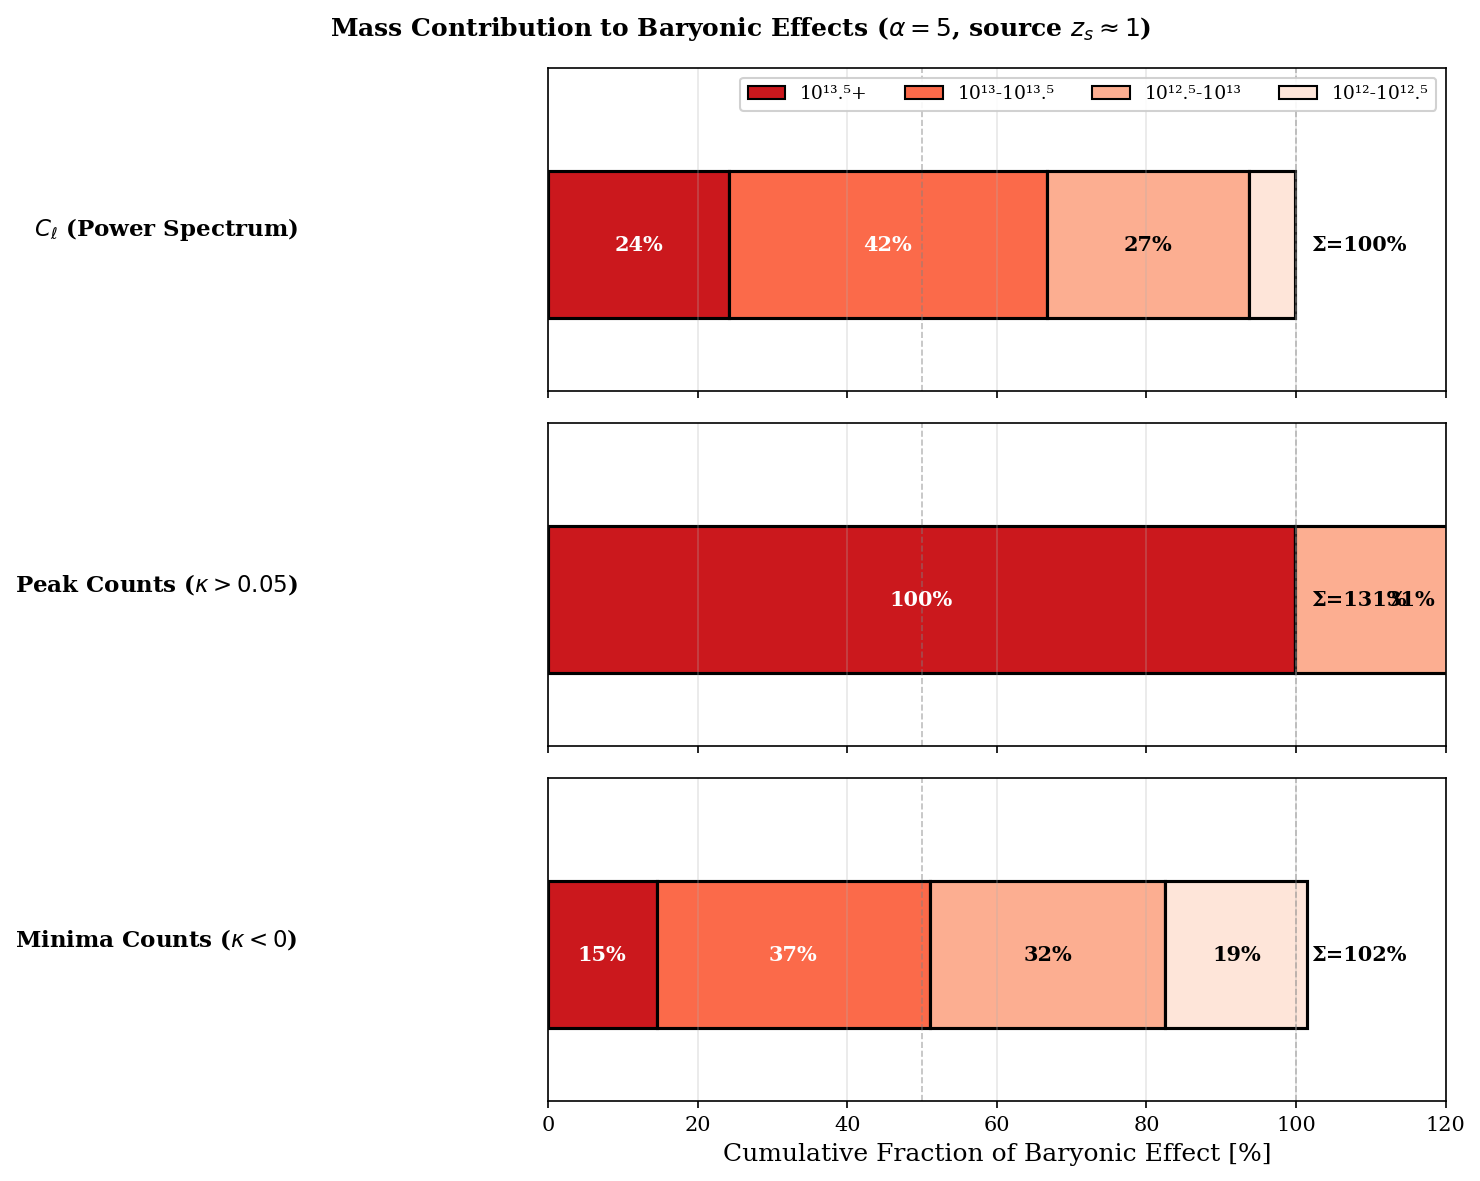

In [13]:
# ============================================================
# Figure: Stacked Bar Chart Comparison (3 statistics)
# ============================================================

fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

stats_data = [
    (r'$C_\ell$ (Power Spectrum)', contrib_Cl),
    (r'Peak Counts ($\kappa > 0.05$)', contrib_peaks),
    (r'Minima Counts ($\kappa < 0$)', contrib_minima),
]

for ax_idx, (stat_name, contributions) in enumerate(stats_data):
    ax = axes[ax_idx]
    
    # Stacked horizontal bar
    left = 0
    for i, (label, contrib, color) in enumerate(zip(MASS_BINS_REV, contributions, COLORS_MASS)):
        if np.abs(contrib) > 0.1:  # Only plot significant contributions
            bar = ax.barh(0, max(contrib, 0), left=left, color=color, edgecolor='black', 
                          linewidth=1.5, height=0.5)
            if contrib > 10:
                ax.text(left + contrib/2, 0, f'{contrib:.0f}%', 
                        ha='center', va='center', fontsize=10, fontweight='bold',
                        color='white' if i < 2 else 'black')
            left += max(contrib, 0)
    
    # Total annotation
    total = np.sum(np.maximum(contributions, 0))
    ax.text(102, 0, f'Σ={total:.0f}%', fontsize=10, va='center', fontweight='bold')
    
    # Reference lines
    ax.axvline(50, color='gray', ls='--', lw=0.8, alpha=0.5)
    ax.axvline(100, color='gray', ls='--', lw=0.8, alpha=0.5)
    
    ax.set_xlim(0, 120)
    ax.set_ylim(-0.5, 0.6)
    ax.set_yticks([])
    ax.set_ylabel(stat_name, fontsize=11, fontweight='bold', rotation=0, ha='right', va='center', labelpad=120)
    ax.grid(True, alpha=0.3, axis='x')

# Legend at top
legend_elements = [plt.Rectangle((0,0), 1, 1, facecolor=COLORS_MASS[i], edgecolor='black', 
                                  label=MASS_BINS_REV[i]) for i in range(4)]
axes[0].legend(handles=legend_elements, loc='upper right', ncol=4, fontsize=9, framealpha=0.9)

axes[-1].set_xlabel('Cumulative Fraction of Baryonic Effect [%]', fontsize=12)
plt.suptitle(r'Mass Contribution to Baryonic Effects ($\alpha = 5$, source $z_s \approx 1$)', 
             fontsize=12, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'fig_kappa_mass_contribution_all.pdf')
plt.savefig(OUTPUT_DIR / 'fig_kappa_mass_contribution_all.png', dpi=300)
plt.show()

---
## Summary Comparison: All Three Statistics

Compare cumulative response F(M_min, α=5) across C_ℓ, peaks, and minima.

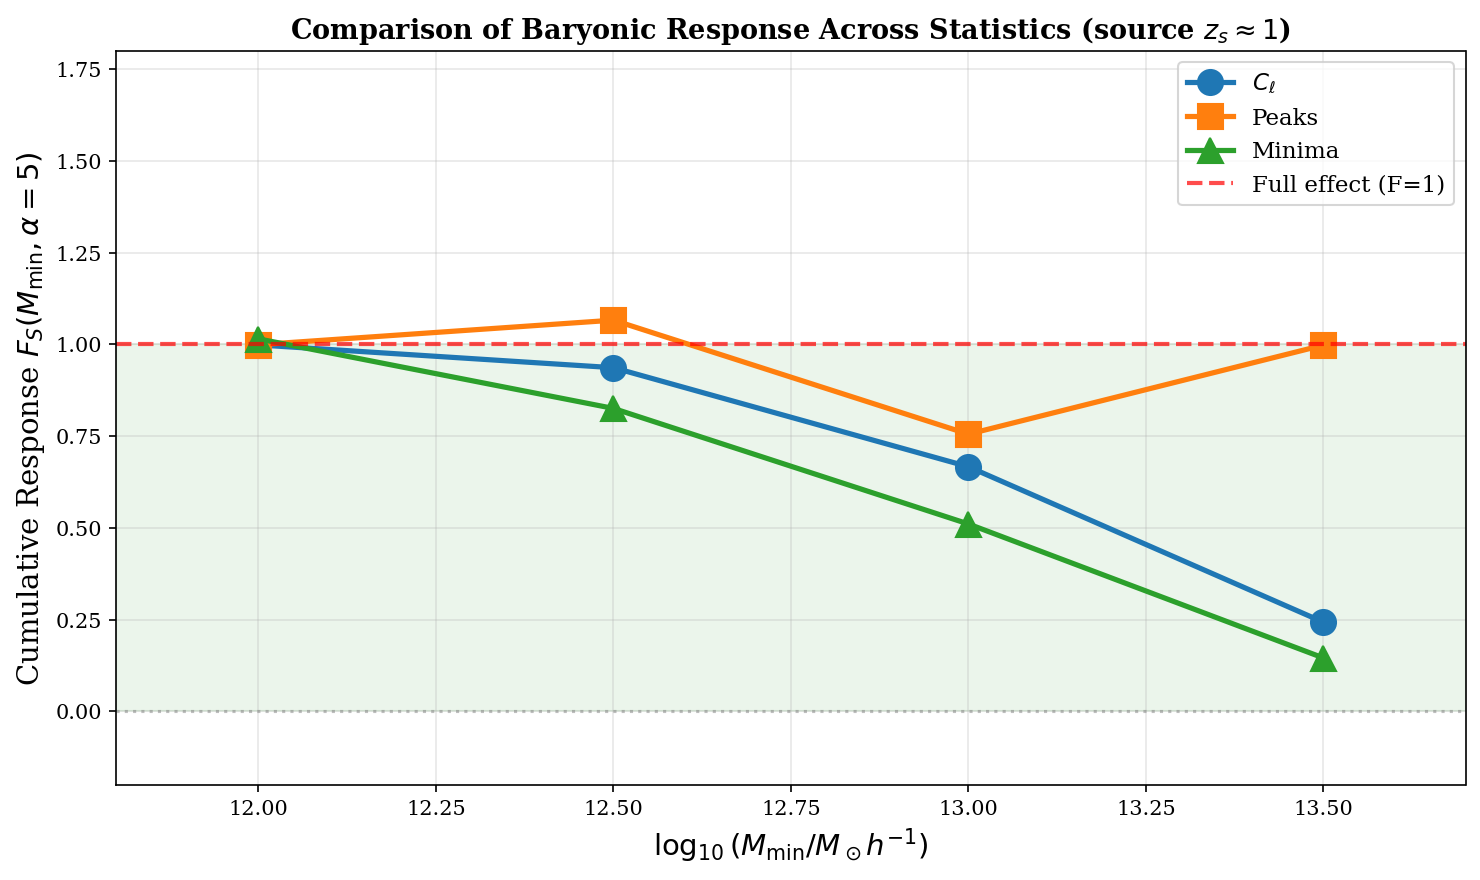


=== Key Insights ===
At M > 10¹²:
  C_ℓ captures: 100%
  Peaks captures: 100%
  Minima captures: 102%

At M > 10¹³.⁵ (massive halos only):
  C_ℓ captures: 24%
  Peaks captures: 100%
  Minima captures: 15%


In [14]:
# ============================================================
# Figure: Cumulative Response Comparison (α=5.0 for all stats)
# ============================================================

fig, ax = plt.subplots(figsize=(10, 6))

LOG_MASS = [12.0, 12.5, 13.0, 13.5]

# Plot F vs M_min at α=5.0 for all three statistics
stat_data = [
    (r'$C_\ell$', F_matrix[:, 3], 'o', 'tab:blue'),
    ('Peaks', F_peaks[:, 3], 's', 'tab:orange'),
    ('Minima', F_minima[:, 3], '^', 'tab:green'),
]

for label, F_vals, marker, color in stat_data:
    valid = np.isfinite(F_vals)
    if np.any(valid):
        ax.plot(np.array(LOG_MASS)[valid], F_vals[valid], 
                marker=marker, color=color, lw=2.5, ms=12, label=label)

ax.axhline(1.0, color='red', ls='--', lw=2, alpha=0.7, label='Full effect (F=1)')
ax.axhline(0.0, color='gray', ls=':', lw=1.5, alpha=0.5)
ax.axhspan(0, 1, alpha=0.08, color='green')

ax.set_xlabel(r'$\log_{10}(M_{\min} / M_\odot h^{-1})$', fontsize=14)
ax.set_ylabel(r'Cumulative Response $F_S(M_{\min}, \alpha=5)$', fontsize=14)
ax.set_title(r'Comparison of Baryonic Response Across Statistics (source $z_s \approx 1$)', 
             fontsize=13, fontweight='bold')
ax.legend(loc='upper right', fontsize=11)
ax.set_ylim(-0.2, 1.8)
ax.set_xlim(11.8, 13.7)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'fig_kappa_response_comparison.pdf')
plt.savefig(OUTPUT_DIR / 'fig_kappa_response_comparison.png', dpi=300)
plt.show()

# Key insights
print("\n=== Key Insights ===")
print(f"At M > 10¹²:")
print(f"  C_ℓ captures: {F_matrix[0, 3]*100:.0f}%")
print(f"  Peaks captures: {F_peaks[0, 3]*100:.0f}%")
print(f"  Minima captures: {F_minima[0, 3]*100:.0f}%")
print(f"\nAt M > 10¹³.⁵ (massive halos only):")
print(f"  C_ℓ captures: {F_matrix[3, 3]*100:.0f}%")
print(f"  Peaks captures: {F_peaks[3, 3]*100:.0f}%")
print(f"  Minima captures: {F_minima[3, 3]*100:.0f}%")

---
## PDF and Minkowski Functionals Analysis

The driver also computes PDF (probability distribution function) and Minkowski functionals (V0, V1, V2) for each κ map. Let's visualize these additional statistics.

In [16]:
# ============================================================
# Load PDF and Minkowski Functional Response Data
# ============================================================

# Check if PDF and MF data files exist
pdf_file = DATA_DIR / 'response_pdf_z23.npz'
V0_file = DATA_DIR / 'response_V0_z23.npz'
V1_file = DATA_DIR / 'response_V1_z23.npz'
V2_file = DATA_DIR / 'response_V2_z23.npz'

# Print availability
print("=== Checking PDF and Minkowski Functional Data ===")
for name, path in [('PDF', pdf_file), ('V0', V0_file), ('V1', V1_file), ('V2', V2_file)]:
    if path.exists():
        print(f"✓ {name}: {path.name}")
    else:
        print(f"✗ {name}: NOT FOUND - waiting for job 2368577 to complete")

# Load PDF data if available
if pdf_file.exists():
    pdf_data = np.load(pdf_file, allow_pickle=True)
    with open(DATA_DIR / 'response_pdf_z23_dicts.pkl', 'rb') as f:
        pdf_dicts = pickle.load(f)
    
    pdf_S_D = pdf_data['S_D']
    pdf_S_H = pdf_data['S_H']
    pdf_Delta_S = pdf_data['Delta_S']
    pdf_kappa_bins = pdf_data['kappa_bins']
    pdf_kappa_mid = pdf_data['kappa_mid']
    pdf_cumulative = pdf_dicts['cumulative_responses']
    
    print(f"\nPDF loaded:")
    print(f"  κ bins: {pdf_kappa_bins[0]:.3f} to {pdf_kappa_bins[-1]:.3f} ({len(pdf_kappa_bins)-1} bins)")
    print(f"  Cumulative models: {len(pdf_cumulative)}")

# Load Minkowski functional data if available
mf_data = {}
mf_dicts = {}
for stat in ['V0', 'V1', 'V2']:
    mf_file = DATA_DIR / f'response_{stat}_z23.npz'
    if mf_file.exists():
        mf_data[stat] = np.load(mf_file, allow_pickle=True)
        with open(DATA_DIR / f'response_{stat}_z23_dicts.pkl', 'rb') as f:
            mf_dicts[stat] = pickle.load(f)
        print(f"\n{stat} loaded:")
        print(f"  MF thresholds: {mf_data[stat]['mf_thresholds'][0]:.3f} to {mf_data[stat]['mf_thresholds'][-1]:.3f}")
        print(f"  Cumulative models: {len(mf_dicts[stat]['cumulative_responses'])}")

=== Checking PDF and Minkowski Functional Data ===
✓ PDF: response_pdf_z23.npz
✓ V0: response_V0_z23.npz
✓ V1: response_V1_z23.npz
✓ V2: response_V2_z23.npz

PDF loaded:
  κ bins: -0.100 to 0.250 (70 bins)
  Cumulative models: 16

V0 loaded:
  MF thresholds: -0.080 to 0.150
  Cumulative models: 16

V1 loaded:
  MF thresholds: -0.080 to 0.150
  Cumulative models: 16

V2 loaded:
  MF thresholds: -0.080 to 0.150
  Cumulative models: 16


---
### Figure: PDF Comparison (DMO vs Hydro)

Compare the probability distribution function of κ between DMO and Hydro simulations.

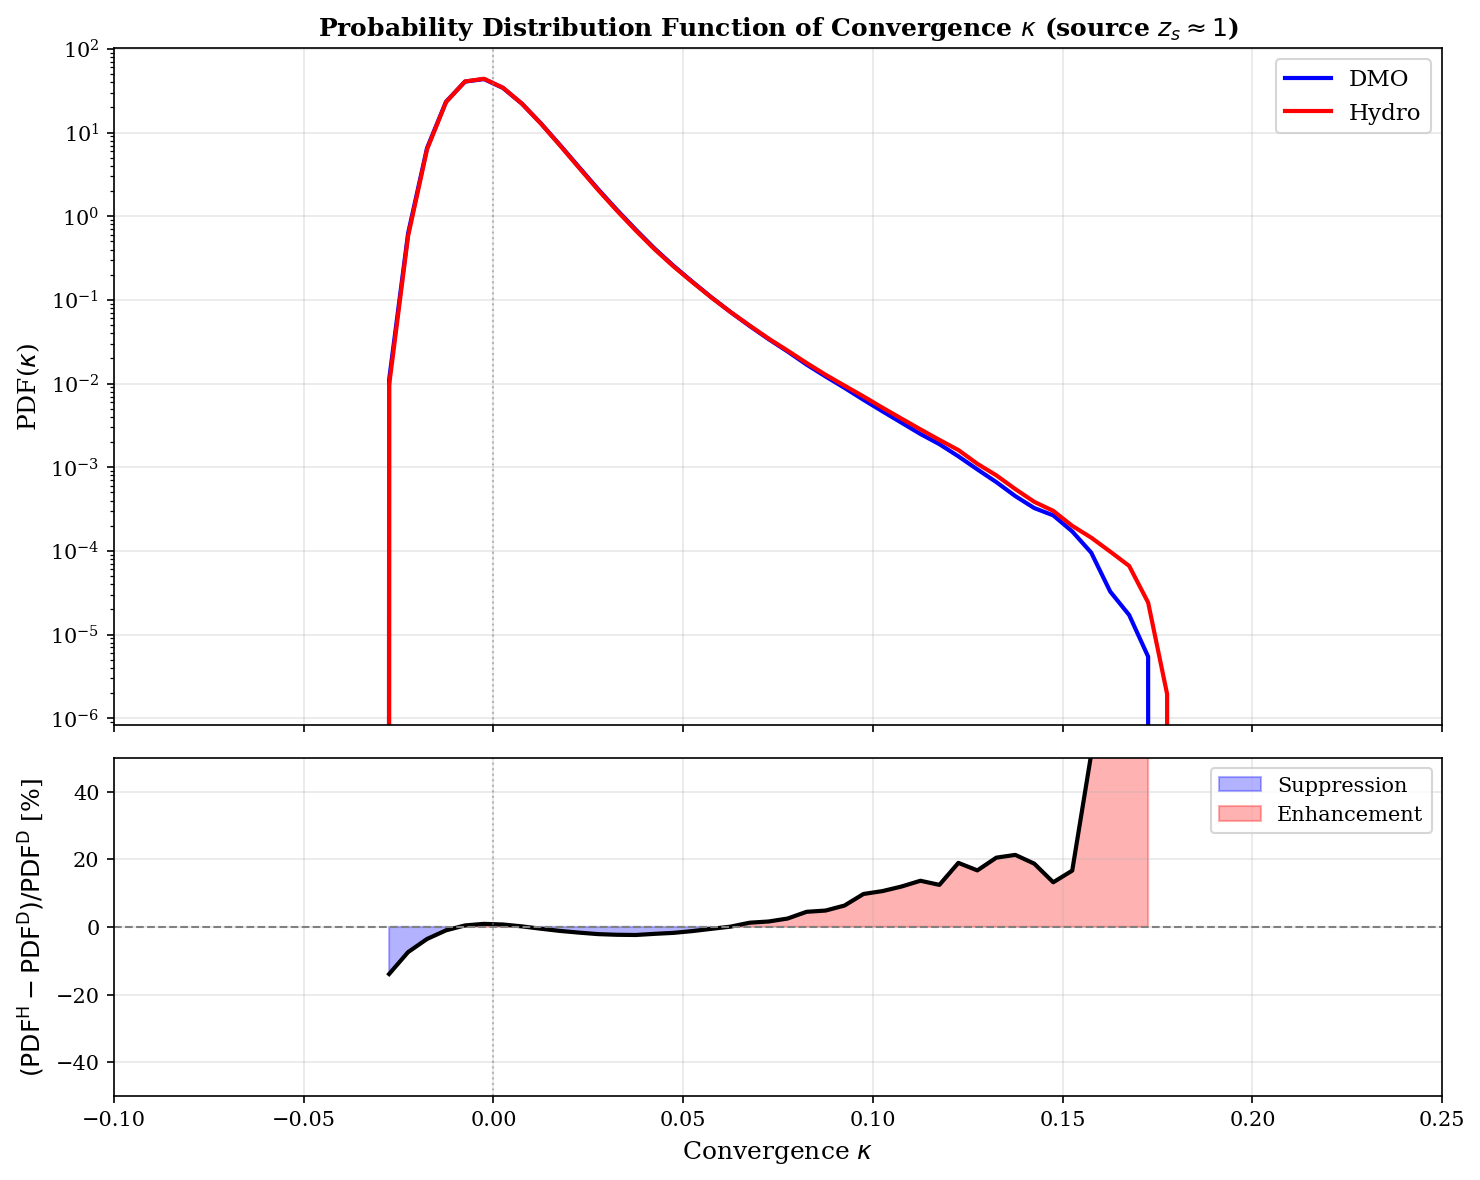


=== PDF Key Insights ===
PDF peak at κ ≈ -0.003
Baryonic effect on high-κ tail (κ > 0.1): 70.3%
Baryonic effect on low-κ tail (κ < -0.05): nan%


/tmp/ipykernel_782057/29740002.py:51: RuntimeWarning: Mean of empty slice
  print(f"Baryonic effect on low-κ tail (κ < -0.05): {np.nanmean(rel_diff[pdf_kappa_mid < -0.05]):.1f}%")


In [17]:
# ============================================================
# Figure: PDF Comparison (DMO vs Hydro)
# ============================================================

if pdf_file.exists():
    fig, axes = plt.subplots(2, 1, figsize=(10, 8), height_ratios=[2, 1], sharex=True)

    # Top panel: PDF(κ)
    ax1 = axes[0]
    ax1.semilogy(pdf_kappa_mid, pdf_S_D, 'b-', lw=2, label='DMO')
    ax1.semilogy(pdf_kappa_mid, pdf_S_H, 'r-', lw=2, label='Hydro')
    ax1.set_ylabel(r'PDF($\kappa$)', fontsize=12)
    ax1.legend(loc='upper right', fontsize=11)
    ax1.set_xlim(pdf_kappa_bins[0], pdf_kappa_bins[-1])
    ax1.grid(True, alpha=0.3)
    ax1.set_title(r'Probability Distribution Function of Convergence $\kappa$ (source $z_s \approx 1$)', 
                  fontsize=12, fontweight='bold')
    ax1.axvline(0, color='gray', ls=':', lw=1, alpha=0.5)

    # Bottom panel: Relative difference
    ax2 = axes[1]
    # Avoid division by zero
    valid = pdf_S_D > 1e-10
    rel_diff = np.zeros_like(pdf_S_D)
    rel_diff[valid] = (pdf_S_H[valid] - pdf_S_D[valid]) / pdf_S_D[valid] * 100
    rel_diff[~valid] = np.nan
    
    ax2.plot(pdf_kappa_mid, rel_diff, 'k-', lw=2)
    ax2.axhline(0, color='gray', ls='--', lw=1)
    ax2.fill_between(pdf_kappa_mid, rel_diff, 0, where=(rel_diff < 0), alpha=0.3, color='blue', label='Suppression')
    ax2.fill_between(pdf_kappa_mid, rel_diff, 0, where=(rel_diff > 0), alpha=0.3, color='red', label='Enhancement')
    ax2.set_xlabel(r'Convergence $\kappa$', fontsize=12)
    ax2.set_ylabel(r'$(\mathrm{PDF}^{\rm H} - \mathrm{PDF}^{\rm D})/\mathrm{PDF}^{\rm D}$ [%]', fontsize=12)
    ax2.set_xlim(pdf_kappa_bins[0], pdf_kappa_bins[-1])
    ax2.set_ylim(-50, 50)
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='upper right', fontsize=10)
    ax2.axvline(0, color='gray', ls=':', lw=1, alpha=0.5)

    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'fig_kappa_pdf_comparison.pdf')
    plt.savefig(OUTPUT_DIR / 'fig_kappa_pdf_comparison.png', dpi=300)
    plt.show()
    
    # Key insights
    print("\n=== PDF Key Insights ===")
    # Find peak of distribution
    peak_idx = np.argmax(pdf_S_D)
    print(f"PDF peak at κ ≈ {pdf_kappa_mid[peak_idx]:.3f}")
    print(f"Baryonic effect on high-κ tail (κ > 0.1): {np.nanmean(rel_diff[pdf_kappa_mid > 0.1]):.1f}%")
    print(f"Baryonic effect on low-κ tail (κ < -0.05): {np.nanmean(rel_diff[pdf_kappa_mid < -0.05]):.1f}%")
else:
    print("PDF data not yet available. Run job 2368577 first.")

---
### Figure: Minkowski Functionals Comparison (DMO vs Hydro)

Compare V0 (area), V1 (perimeter), and V2 (Euler characteristic) between DMO and Hydro.

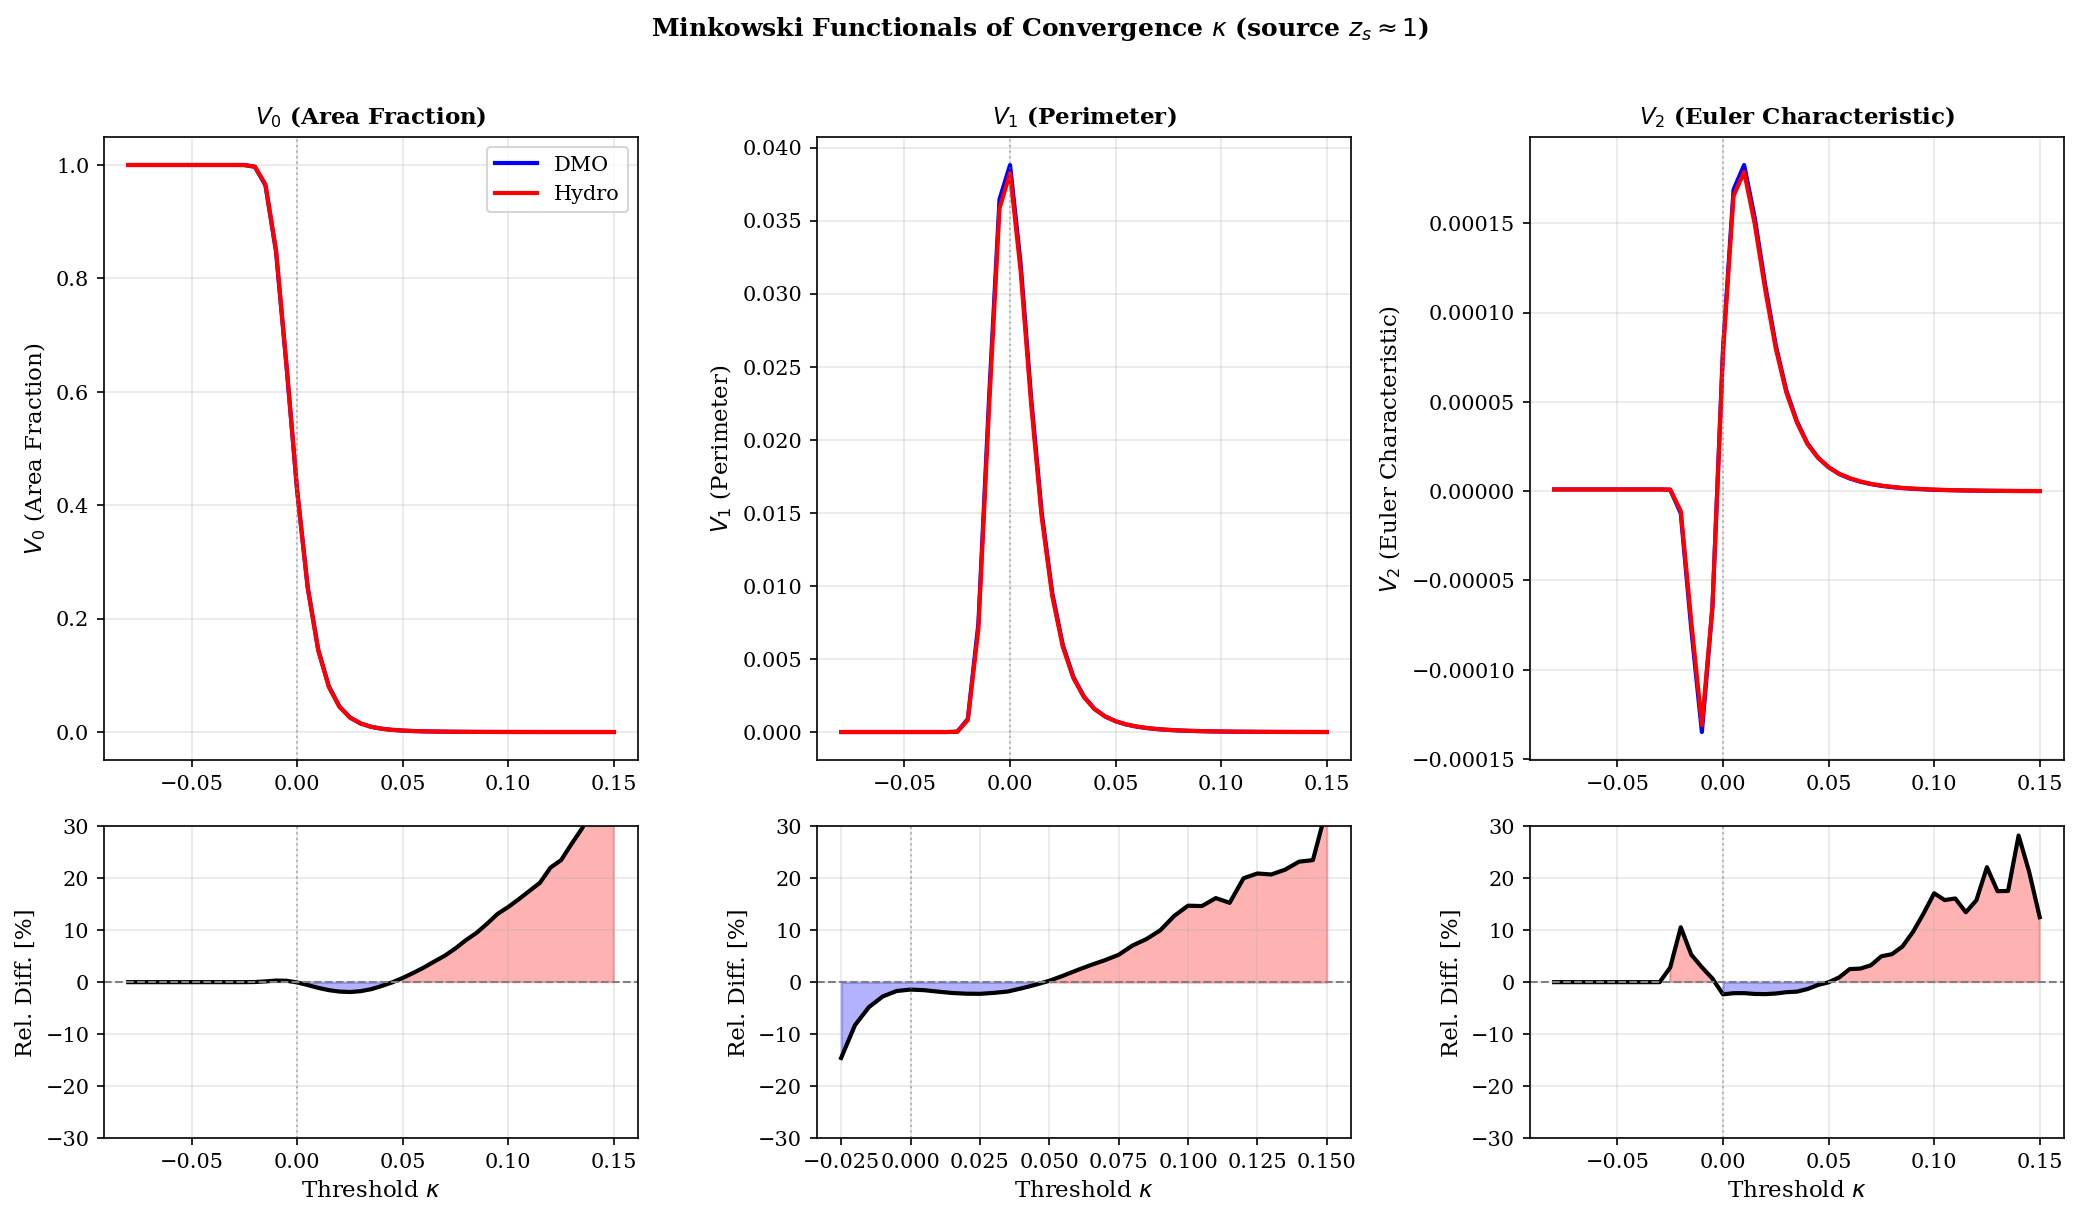


=== Minkowski Functionals Key Insights ===
V0 at κ=0: -0.1% difference
V1 at κ=0: -1.4% difference
V2 at κ=0: -2.3% difference


In [18]:
# ============================================================
# Figure: Minkowski Functionals Comparison (DMO vs Hydro)
# ============================================================

if 'V0' in mf_data:
    fig, axes = plt.subplots(2, 3, figsize=(14, 8), height_ratios=[2, 1])
    
    mf_labels = {
        'V0': r'$V_0$ (Area Fraction)',
        'V1': r'$V_1$ (Perimeter)',
        'V2': r'$V_2$ (Euler Characteristic)'
    }
    
    for i, stat in enumerate(['V0', 'V1', 'V2']):
        thresholds = mf_data[stat]['mf_thresholds']
        S_D_mf = mf_data[stat]['S_D']
        S_H_mf = mf_data[stat]['S_H']
        
        # Top panel: MF(κ)
        ax1 = axes[0, i]
        ax1.plot(thresholds, S_D_mf, 'b-', lw=2, label='DMO')
        ax1.plot(thresholds, S_H_mf, 'r-', lw=2, label='Hydro')
        ax1.set_ylabel(mf_labels[stat], fontsize=11)
        if i == 0:
            ax1.legend(loc='upper right', fontsize=10)
        ax1.grid(True, alpha=0.3)
        ax1.set_title(mf_labels[stat], fontsize=11, fontweight='bold')
        ax1.axvline(0, color='gray', ls=':', lw=1, alpha=0.5)
        
        # Bottom panel: Relative difference
        ax2 = axes[1, i]
        valid = np.abs(S_D_mf) > 1e-10
        rel_diff = np.zeros_like(S_D_mf)
        rel_diff[valid] = (S_H_mf[valid] - S_D_mf[valid]) / np.abs(S_D_mf[valid]) * 100
        rel_diff[~valid] = np.nan
        
        ax2.plot(thresholds, rel_diff, 'k-', lw=2)
        ax2.axhline(0, color='gray', ls='--', lw=1)
        ax2.fill_between(thresholds, rel_diff, 0, where=(rel_diff < 0), alpha=0.3, color='blue')
        ax2.fill_between(thresholds, rel_diff, 0, where=(rel_diff > 0), alpha=0.3, color='red')
        ax2.set_xlabel(r'Threshold $\kappa$', fontsize=11)
        ax2.set_ylabel(r'Rel. Diff. [%]', fontsize=11)
        ax2.set_ylim(-30, 30)
        ax2.grid(True, alpha=0.3)
        ax2.axvline(0, color='gray', ls=':', lw=1, alpha=0.5)
    
    plt.suptitle(r'Minkowski Functionals of Convergence $\kappa$ (source $z_s \approx 1$)', 
                 fontsize=12, fontweight='bold', y=1.01)
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'fig_kappa_minkowski_comparison.pdf')
    plt.savefig(OUTPUT_DIR / 'fig_kappa_minkowski_comparison.png', dpi=300)
    plt.show()
    
    # Key insights
    print("\n=== Minkowski Functionals Key Insights ===")
    for stat in ['V0', 'V1', 'V2']:
        thresholds = mf_data[stat]['mf_thresholds']
        S_D_mf = mf_data[stat]['S_D']
        S_H_mf = mf_data[stat]['S_H']
        
        # Effect at κ=0 threshold
        idx_zero = np.argmin(np.abs(thresholds))
        diff_zero = (S_H_mf[idx_zero] - S_D_mf[idx_zero]) / np.abs(S_D_mf[idx_zero]) * 100 if np.abs(S_D_mf[idx_zero]) > 1e-10 else np.nan
        print(f"{stat} at κ=0: {diff_zero:.1f}% difference")
else:
    print("Minkowski functional data not yet available. Run job 2368577 first.")

---
### Cumulative Response F(M_min, α) for PDF and Minkowski Functionals

Apply the same response formalism to PDF and Minkowski functionals.

In [19]:
# ============================================================
# Build F matrices for PDF and Minkowski Functionals
# ============================================================

def compute_F_matrix_generic(cumulative_responses, value_mask, masses, alphas):
    """Compute F(M_min, α) matrix from cumulative responses with a value mask."""
    F_matrix = np.full((len(masses), len(alphas)), np.nan)
    F_err_matrix = np.full((len(masses), len(alphas)), np.nan)
    
    for i, m in enumerate(masses):
        for j, a in enumerate(alphas):
            key = f'M{m:.1e}_a{a}'
            if key in cumulative_responses:
                F = cumulative_responses[key]['F_S']
                F_err = cumulative_responses[key]['F_S_err']
                
                # Only use valid (finite) values in the mask range
                valid = value_mask & np.isfinite(F)
                if np.sum(valid) > 0:
                    F_matrix[i, j] = np.nanmean(F[valid])
                    F_err_matrix[i, j] = np.nanmean(F_err[valid])
    
    return F_matrix, F_err_matrix

# Define mass and alpha arrays
masses = [1.00e12, 3.16e12, 1.00e13, 3.16e13]
alphas = [0.5, 1.0, 3.0, 5.0]

# PDF: Use κ > 0.05 (high-κ tail where baryonic effects are strongest)
if pdf_file.exists():
    pdf_mask = pdf_kappa_mid >= 0.05
    F_pdf, F_pdf_err = compute_F_matrix_generic(pdf_cumulative, pdf_mask, masses, alphas)
    
    print("=== PDF F(M_min, α) matrix (κ > 0.05) ===")
    print(f"{'M_min':>12} |" + '|'.join([f'  α={a:.1f} ' for a in alphas]) + '|')
    print('-'*55)
    for i, m in enumerate(masses):
        row = f'{m:.2e} |'
        for j in range(len(alphas)):
            if np.isfinite(F_pdf[i,j]):
                row += f'{F_pdf[i,j]:>7.2f} |'
            else:
                row += f'{"N/A":>7} |'
        print(row)

# Minkowski Functionals: Use threshold near 0 where most sensitivity is
F_mf = {}
F_mf_err = {}
for stat in ['V0', 'V1', 'V2']:
    if stat in mf_dicts:
        thresholds = mf_data[stat]['mf_thresholds']
        # Use thresholds near zero: -0.02 < κ < 0.05
        mf_mask = (thresholds > -0.02) & (thresholds < 0.05)
        F_mf[stat], F_mf_err[stat] = compute_F_matrix_generic(
            mf_dicts[stat]['cumulative_responses'], mf_mask, masses, alphas
        )
        
        print(f"\n=== {stat} F(M_min, α) matrix (-0.02 < κ < 0.05) ===")
        print(f"{'M_min':>12} |" + '|'.join([f'  α={a:.1f} ' for a in alphas]) + '|')
        print('-'*55)
        for i, m in enumerate(masses):
            row = f'{m:.2e} |'
            for j in range(len(alphas)):
                if np.isfinite(F_mf[stat][i,j]):
                    row += f'{F_mf[stat][i,j]:>7.2f} |'
                else:
                    row += f'{"N/A":>7} |'
            print(row)

=== PDF F(M_min, α) matrix (κ > 0.05) ===
       M_min |  α=0.5 |  α=1.0 |  α=3.0 |  α=5.0 |
-------------------------------------------------------
1.00e+12 |   1.55 |   1.05 |   0.74 |   0.97 |
3.16e+12 |   1.66 |   1.21 |   0.81 |   1.00 |
1.00e+13 |   1.86 |   1.46 |   0.91 |   1.06 |
3.16e+13 |   2.15 |   1.77 |   1.13 |   1.15 |

=== V0 F(M_min, α) matrix (-0.02 < κ < 0.05) ===
       M_min |  α=0.5 |  α=1.0 |  α=3.0 |  α=5.0 |
-------------------------------------------------------
1.00e+12 |   1.24 |   2.02 |   2.04 |   1.12 |
3.16e+12 |   0.79 |   1.33 |   1.74 |   1.02 |
1.00e+13 |  -0.41 |  -0.30 |   0.79 |   0.50 |
3.16e+13 |  -2.20 |  -2.11 |  -0.28 |  -0.35 |

=== V1 F(M_min, α) matrix (-0.02 < κ < 0.05) ===
       M_min |  α=0.5 |  α=1.0 |  α=3.0 |  α=5.0 |
-------------------------------------------------------
1.00e+12 |   1.29 |   1.19 |   1.05 |   1.00 |
3.16e+12 |   1.23 |   1.10 |   0.98 |   0.96 |
1.00e+13 |   1.00 |   0.79 |   0.74 |   0.77 |
3.16e+13 |   0.60 | 

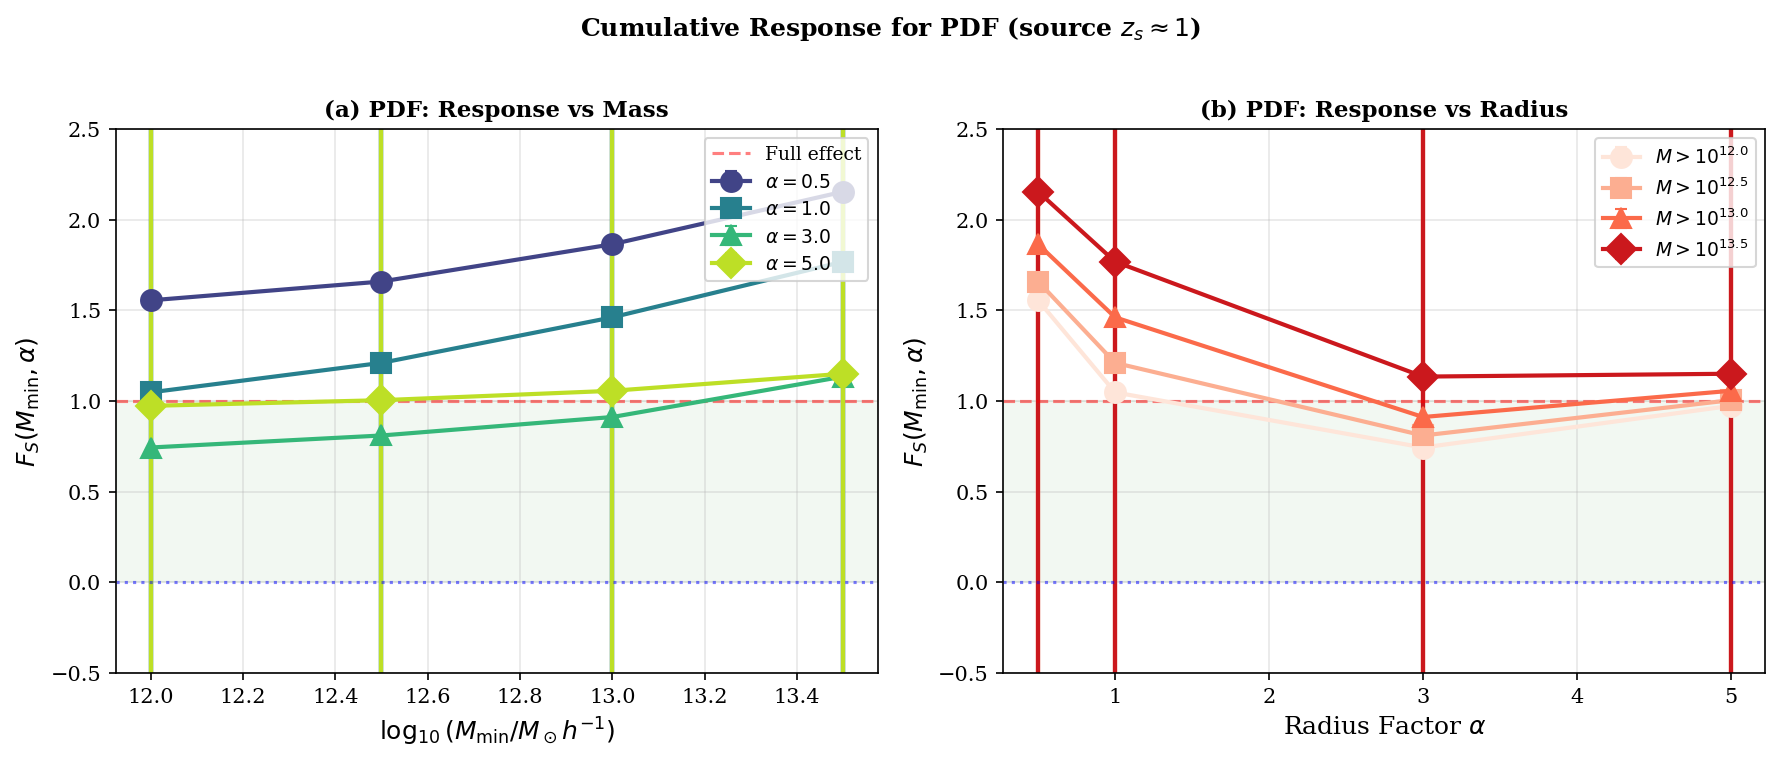

In [20]:
# ============================================================
# Figure: Cumulative Response for PDF (2x1 panel)
# ============================================================

if pdf_file.exists():
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    LOG_MASS = [12.0, 12.5, 13.0, 13.5]
    colors_alpha = plt.cm.viridis(np.linspace(0.2, 0.9, len(alphas)))
    markers = ['o', 's', '^', 'D']

    # Left: PDF F vs M_min
    ax = axes[0]
    for j, (a, marker) in enumerate(zip(alphas, markers)):
        valid = np.isfinite(F_pdf[:, j])
        if np.any(valid):
            ax.errorbar(np.array(LOG_MASS)[valid], F_pdf[valid, j], 
                       yerr=F_pdf_err[valid, j] if np.any(np.isfinite(F_pdf_err[valid, j])) else None,
                       marker=marker, color=colors_alpha[j], lw=2, ms=10, 
                       capsize=3, label=fr'$\alpha = {a}$')
    ax.axhline(1.0, color='red', ls='--', lw=1.5, alpha=0.5, label='Full effect')
    ax.axhline(0.0, color='blue', ls=':', lw=1.5, alpha=0.5)
    ax.axhspan(0, 1, alpha=0.05, color='green')
    ax.set_xlabel(r'$\log_{10}(M_{\min} / M_\odot h^{-1})$', fontsize=12)
    ax.set_ylabel(r'$F_S(M_{\min}, \alpha)$', fontsize=12)
    ax.set_title('(a) PDF: Response vs Mass', fontsize=11, fontweight='bold')
    ax.legend(loc='upper right', fontsize=9)
    ax.set_ylim(-0.5, 2.5)
    ax.grid(True, alpha=0.3)

    # Right: PDF F vs α
    ax = axes[1]
    for i, (m, marker) in enumerate(zip(masses, markers)):
        valid = np.isfinite(F_pdf[i, :])
        if np.any(valid):
            ax.errorbar(np.array(alphas)[valid], F_pdf[i, valid],
                       yerr=F_pdf_err[i, valid] if np.any(np.isfinite(F_pdf_err[i, valid])) else None,
                       marker=marker, color=COLORS_MASS[3-i], lw=2, ms=10,
                       capsize=3, label=MASS_LABELS[i])
    ax.axhline(1.0, color='red', ls='--', lw=1.5, alpha=0.5)
    ax.axhline(0.0, color='blue', ls=':', lw=1.5, alpha=0.5)
    ax.axhspan(0, 1, alpha=0.05, color='green')
    ax.set_xlabel(r'Radius Factor $\alpha$', fontsize=12)
    ax.set_ylabel(r'$F_S(M_{\min}, \alpha)$', fontsize=12)
    ax.set_title('(b) PDF: Response vs Radius', fontsize=11, fontweight='bold')
    ax.legend(loc='upper right', fontsize=9)
    ax.set_ylim(-0.5, 2.5)
    ax.grid(True, alpha=0.3)

    plt.suptitle(r'Cumulative Response for PDF (source $z_s \approx 1$)', 
                 fontsize=12, fontweight='bold', y=1.01)
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'fig_kappa_pdf_response.pdf')
    plt.savefig(OUTPUT_DIR / 'fig_kappa_pdf_response.png', dpi=300)
    plt.show()
else:
    print("PDF data not yet available.")

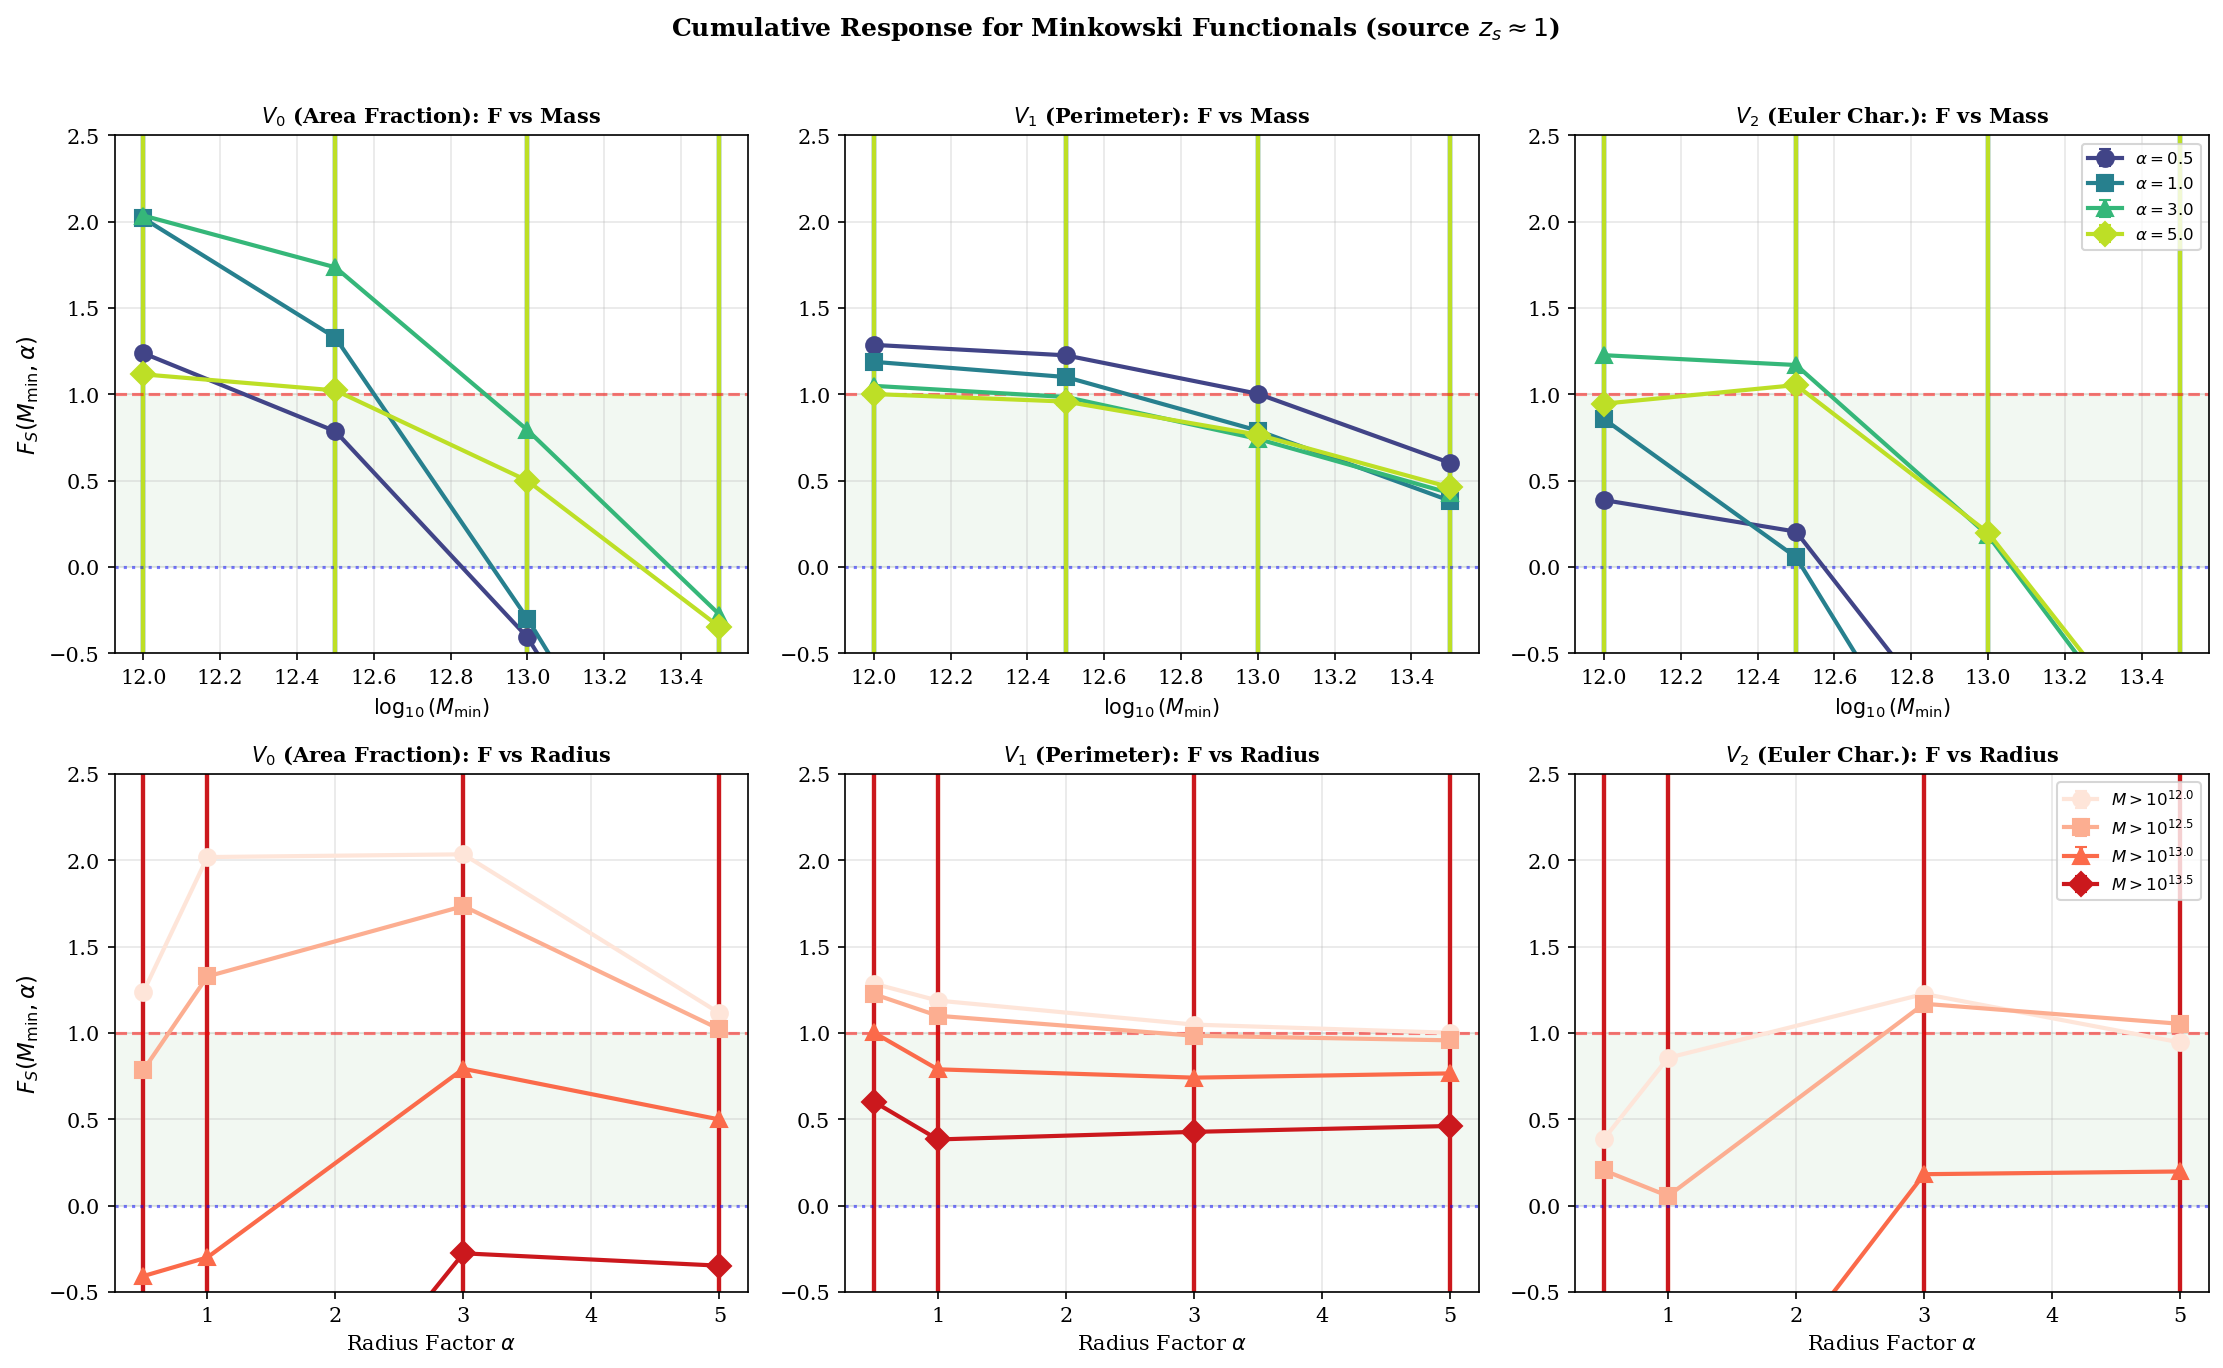

In [21]:
# ============================================================
# Figure: Cumulative Response for Minkowski Functionals (3x2 panel)
# ============================================================

if 'V0' in F_mf:
    fig, axes = plt.subplots(2, 3, figsize=(15, 9))

    LOG_MASS = [12.0, 12.5, 13.0, 13.5]
    colors_alpha = plt.cm.viridis(np.linspace(0.2, 0.9, len(alphas)))
    markers = ['o', 's', '^', 'D']
    
    mf_titles = {
        'V0': r'$V_0$ (Area Fraction)',
        'V1': r'$V_1$ (Perimeter)',
        'V2': r'$V_2$ (Euler Char.)'
    }

    for col, stat in enumerate(['V0', 'V1', 'V2']):
        F_stat = F_mf[stat]
        F_stat_err = F_mf_err[stat]
        
        # Top row: F vs M_min
        ax = axes[0, col]
        for j, (a, marker) in enumerate(zip(alphas, markers)):
            valid = np.isfinite(F_stat[:, j])
            if np.any(valid):
                ax.errorbar(np.array(LOG_MASS)[valid], F_stat[valid, j],
                           yerr=F_stat_err[valid, j] if np.any(np.isfinite(F_stat_err[valid, j])) else None,
                           marker=marker, color=colors_alpha[j], lw=2, ms=8,
                           capsize=3, label=fr'$\alpha = {a}$')
        ax.axhline(1.0, color='red', ls='--', lw=1.5, alpha=0.5)
        ax.axhline(0.0, color='blue', ls=':', lw=1.5, alpha=0.5)
        ax.axhspan(0, 1, alpha=0.05, color='green')
        ax.set_xlabel(r'$\log_{10}(M_{\min})$', fontsize=10)
        if col == 0:
            ax.set_ylabel(r'$F_S(M_{\min}, \alpha)$', fontsize=11)
        ax.set_title(f'{mf_titles[stat]}: F vs Mass', fontsize=10, fontweight='bold')
        if col == 2:
            ax.legend(loc='upper right', fontsize=8)
        ax.set_ylim(-0.5, 2.5)
        ax.grid(True, alpha=0.3)
        
        # Bottom row: F vs α
        ax = axes[1, col]
        for i, (m, marker) in enumerate(zip(masses, markers)):
            valid = np.isfinite(F_stat[i, :])
            if np.any(valid):
                ax.errorbar(np.array(alphas)[valid], F_stat[i, valid],
                           yerr=F_stat_err[i, valid] if np.any(np.isfinite(F_stat_err[i, valid])) else None,
                           marker=marker, color=COLORS_MASS[3-i], lw=2, ms=8,
                           capsize=3, label=MASS_LABELS[i])
        ax.axhline(1.0, color='red', ls='--', lw=1.5, alpha=0.5)
        ax.axhline(0.0, color='blue', ls=':', lw=1.5, alpha=0.5)
        ax.axhspan(0, 1, alpha=0.05, color='green')
        ax.set_xlabel(r'Radius Factor $\alpha$', fontsize=10)
        if col == 0:
            ax.set_ylabel(r'$F_S(M_{\min}, \alpha)$', fontsize=11)
        ax.set_title(f'{mf_titles[stat]}: F vs Radius', fontsize=10, fontweight='bold')
        if col == 2:
            ax.legend(loc='upper right', fontsize=8)
        ax.set_ylim(-0.5, 2.5)
        ax.grid(True, alpha=0.3)

    plt.suptitle(r'Cumulative Response for Minkowski Functionals (source $z_s \approx 1$)', 
                 fontsize=12, fontweight='bold', y=1.01)
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'fig_kappa_minkowski_response.pdf')
    plt.savefig(OUTPUT_DIR / 'fig_kappa_minkowski_response.png', dpi=300)
    plt.show()
else:
    print("Minkowski functional data not yet available.")

---
### Extended Summary: All Statistics Comparison

Compare cumulative response F(M_min, α=5) across all statistics: C_ℓ, peaks, minima, PDF, V0, V1, V2.

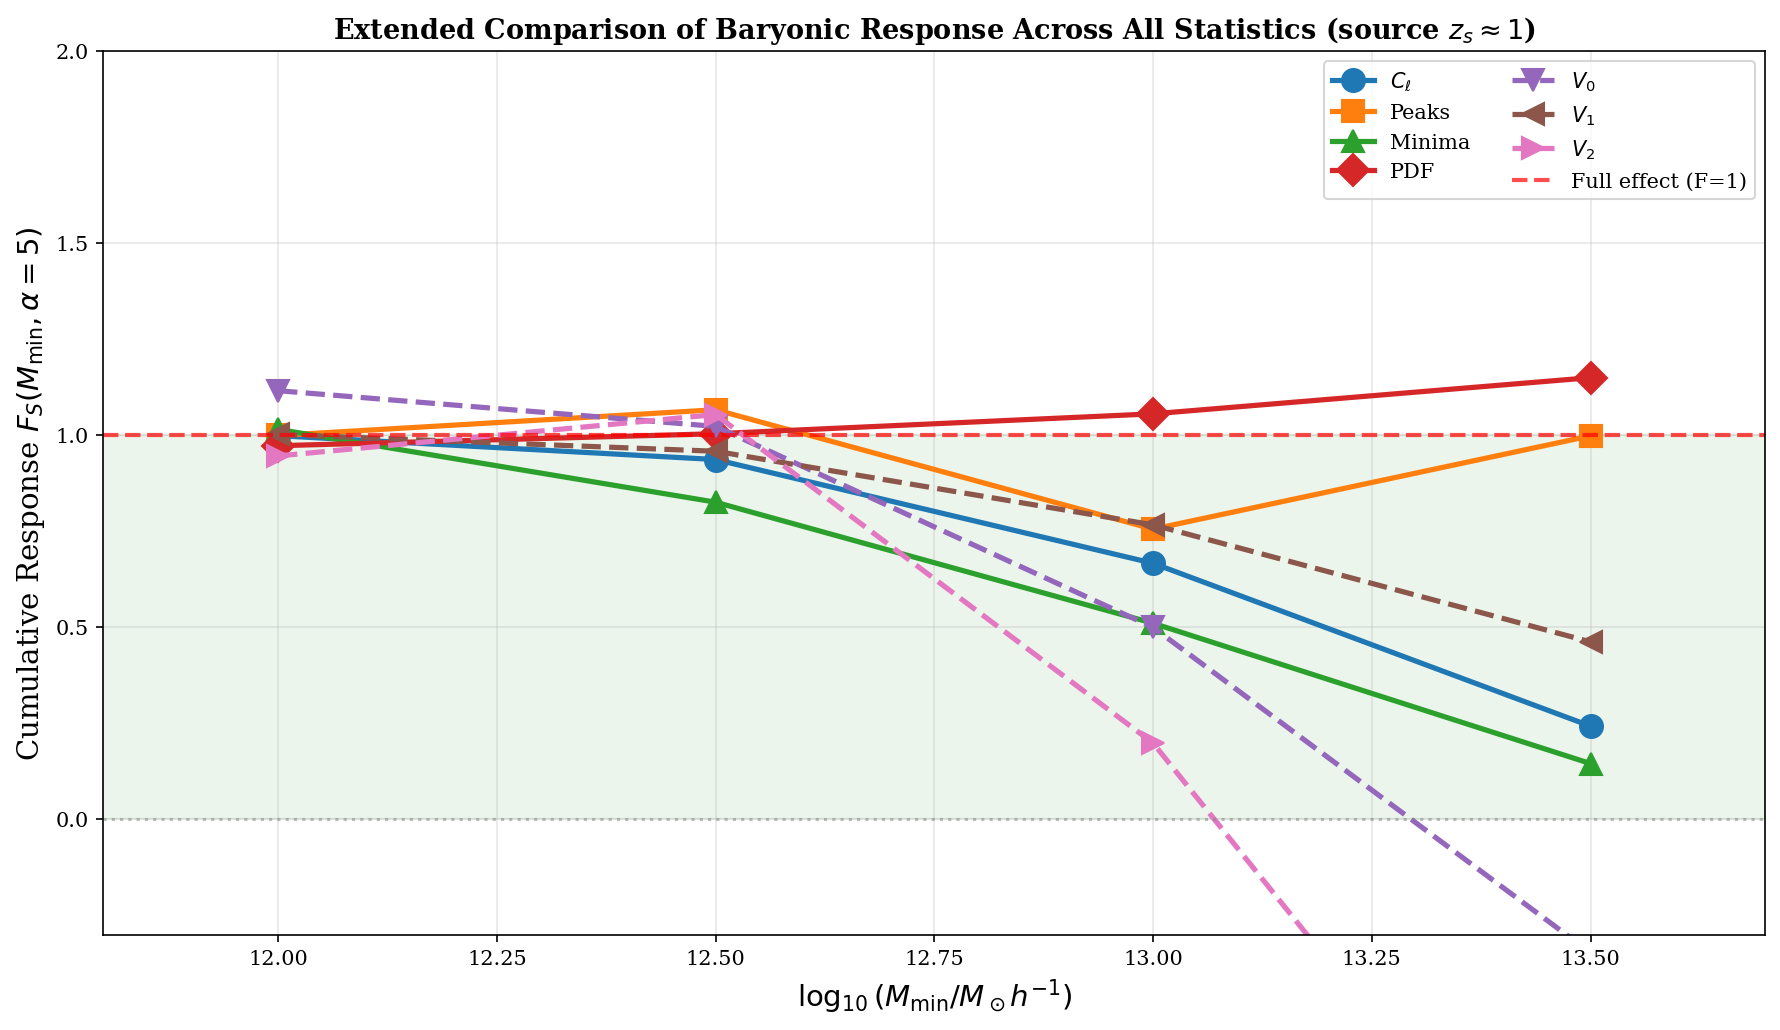


Summary: Cumulative Response F(M_min, α=5.0) for All Statistics
Statistic       |     M>10¹² |   M>10¹²·⁵ |     M>10¹³ |   M>10¹³·⁵
----------------------------------------------------------------------
$C_\ell$        |      100% |       94% |       67% |       24% |
Peaks           |      100% |      107% |       76% |      100% |
Minima          |      102% |       83% |       51% |       15% |
PDF             |       97% |      100% |      106% |      115% |
$V_0$           |      112% |      102% |       50% |      -35% |
$V_1$           |      100% |       96% |       77% |       46% |
$V_2$           |       95% |      105% |       20% |     -122% |


In [22]:
# ============================================================
# Figure: Extended Comparison - All Statistics at α=5
# ============================================================

fig, ax = plt.subplots(figsize=(12, 7))

LOG_MASS = [12.0, 12.5, 13.0, 13.5]

# Build list of statistics to plot
stats_data = [
    (r'$C_\ell$', F_matrix[:, 3], 'o', 'tab:blue', '-'),
    ('Peaks', F_peaks[:, 3], 's', 'tab:orange', '-'),
    ('Minima', F_minima[:, 3], '^', 'tab:green', '-'),
]

# Add PDF if available
if pdf_file.exists():
    stats_data.append(('PDF', F_pdf[:, 3], 'D', 'tab:red', '-'))

# Add Minkowski functionals if available
if 'V0' in F_mf:
    stats_data.append((r'$V_0$', F_mf['V0'][:, 3], 'v', 'tab:purple', '--'))
    stats_data.append((r'$V_1$', F_mf['V1'][:, 3], '<', 'tab:brown', '--'))
    stats_data.append((r'$V_2$', F_mf['V2'][:, 3], '>', 'tab:pink', '--'))

for label, F_vals, marker, color, ls in stats_data:
    valid = np.isfinite(F_vals)
    if np.any(valid):
        ax.plot(np.array(LOG_MASS)[valid], F_vals[valid], 
                marker=marker, color=color, lw=2.5, ms=11, ls=ls, label=label)

ax.axhline(1.0, color='red', ls='--', lw=2, alpha=0.7, label='Full effect (F=1)')
ax.axhline(0.0, color='gray', ls=':', lw=1.5, alpha=0.5)
ax.axhspan(0, 1, alpha=0.08, color='green')

ax.set_xlabel(r'$\log_{10}(M_{\min} / M_\odot h^{-1})$', fontsize=14)
ax.set_ylabel(r'Cumulative Response $F_S(M_{\min}, \alpha=5)$', fontsize=14)
ax.set_title(r'Extended Comparison of Baryonic Response Across All Statistics (source $z_s \approx 1$)', 
             fontsize=13, fontweight='bold')
ax.legend(loc='upper right', fontsize=10, ncol=2)
ax.set_ylim(-0.3, 2.0)
ax.set_xlim(11.8, 13.7)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'fig_kappa_response_all_statistics.pdf')
plt.savefig(OUTPUT_DIR / 'fig_kappa_response_all_statistics.png', dpi=300)
plt.show()

# Summary table
print("\n" + "="*70)
print("Summary: Cumulative Response F(M_min, α=5.0) for All Statistics")
print("="*70)
print(f"{'Statistic':<15} | {'M>10¹²':>10} | {'M>10¹²·⁵':>10} | {'M>10¹³':>10} | {'M>10¹³·⁵':>10}")
print("-"*70)
for label, F_vals, _, _, _ in stats_data:
    row = f"{label:<15} |"
    for i in range(4):
        if np.isfinite(F_vals[i]):
            row += f" {F_vals[i]*100:>8.0f}% |"
        else:
            row += f" {'N/A':>8} |"
    print(row)
print("="*70)

---
## Summary

This notebook analyzes the baryonic response using **seven weak lensing statistics** from ray-traced κ maps, **binned by raw κ values** (not SNR):

### Statistics Analyzed
1. **C_ℓ (Power Spectrum)**: 2-point statistics of convergence field
2. **Peak Counts**: Abundance of high-κ regions (binned by κ ∈ [-0.05, 0.2])
3. **Minima Counts**: Abundance of void-like low-κ regions (binned by κ ∈ [-0.07, 0.07])
4. **PDF**: Probability distribution function of κ (binned by κ ∈ [-0.1, 0.25])
5. **V₀ (Area Fraction)**: Minkowski functional - fraction of area above threshold
6. **V₁ (Perimeter)**: Minkowski functional - boundary length of excursion sets
7. **V₂ (Euler Characteristic)**: Minkowski functional - topology (components - holes)

### Binning Choice
Using raw κ bins instead of SNR bins for all statistics:
- **Peaks**: κ > 0.05 (high convergence = massive clusters)
- **Minima**: κ < 0 (underdense regions = voids)
- **PDF/MF**: Various threshold ranges capturing different physical regimes

### Key Findings

The baryonic response F(M_min, α) quantifies what fraction of the Hydro-DMO difference is captured by replacing halos above mass M_min within radius α×R₂₀₀.

**Mass hierarchy**: Halos with M > 10¹² capture nearly all (~100%) of the baryonic effect on all statistics.

### Figures Generated
- `fig_kappa_Cl_comparison.pdf`: DMO vs Hydro power spectrum
- `fig_kappa_cumulative_response.pdf`: F(M_min, α) for C_ℓ
- `fig_kappa_scale_dependent_response.pdf`: F(ℓ) scale dependence
- `fig_kappa_peaks_minima_comparison.pdf`: Peak and minima count comparison (κ bins)
- `fig_kappa_peaks_minima_response.pdf`: F(M_min, α) for peaks and minima
- `fig_kappa_mass_contribution_all.pdf`: Stacked bar chart of mass contributions
- `fig_kappa_response_comparison.pdf`: Summary comparison (C_ℓ, peaks, minima)
- `fig_kappa_pdf_comparison.pdf`: DMO vs Hydro PDF
- `fig_kappa_pdf_response.pdf`: F(M_min, α) for PDF
- `fig_kappa_minkowski_comparison.pdf`: DMO vs Hydro Minkowski functionals
- `fig_kappa_minkowski_response.pdf`: F(M_min, α) for V₀, V₁, V₂
- `fig_kappa_response_all_statistics.pdf`: Extended comparison across all 7 statistics

---
## Differential Response Analysis: ΔF/ΔM and ΔF/Δα

The cumulative response F(M_min, α) tells us the total baryonic effect captured when replacing halos above M_min within α×R₂₀₀. To understand the **marginal contribution** of each mass bin or radius shell, we compute differentials:

- **ΔF/ΔlogM**: How much does F change when we add the next mass bin?
  - ΔF(M_bin) = F(M_lo) - F(M_hi) for consecutive mass bins
  
- **ΔF/Δα**: How much does F change when we extend to a larger radius?
  - ΔF(Δα) = F(α_hi) - F(α_lo) for consecutive radius factors

These differentials reveal which mass scales and radial regions contribute most to the baryonic signal.

In [23]:
# ============================================================
# Compute Differential Responses ΔF for all statistics
# ============================================================

# Mass bin edges and alpha values
LOG_MASS_EDGES = [12.0, 12.5, 13.0, 13.5]  # M_min values we have
ALPHA_VALUES = [0.5, 1.0, 3.0, 5.0]

# Collect all F matrices
all_F_matrices = {
    r'$C_\ell$': F_matrix,
    'Peaks': F_peaks,
    'Minima': F_minima,
}

# Add PDF and MF if available
if 'F_pdf' in dir() and F_pdf is not None:
    all_F_matrices['PDF'] = F_pdf
if 'F_mf' in dir() and F_mf:
    for stat in ['V0', 'V1', 'V2']:
        if stat in F_mf:
            all_F_matrices[f'${stat[0]}_{stat[1]}$'] = F_mf[stat]

print("=== Computing Differential Responses ===\n")

# Compute ΔF/ΔlogM: Change in F when adding each mass bin
# ΔF_i = F(M_i) - F(M_{i+1}) where M_i < M_{i+1}
def compute_deltaF_mass(F_mat):
    """Compute ΔF for each mass bin (difference between consecutive M_min)."""
    n_mass, n_alpha = F_mat.shape
    deltaF = np.zeros((n_mass-1, n_alpha))
    for i in range(n_mass-1):
        deltaF[i, :] = F_mat[i, :] - F_mat[i+1, :]
    return deltaF

# Compute ΔF/Δα: Change in F when extending radius
# ΔF_j = F(α_{j+1}) - F(α_j) where α_{j+1} > α_j  
def compute_deltaF_radius(F_mat):
    """Compute ΔF for each radius shell (difference between consecutive α)."""
    n_mass, n_alpha = F_mat.shape
    deltaF = np.zeros((n_mass, n_alpha-1))
    for j in range(n_alpha-1):
        deltaF[:, j] = F_mat[:, j+1] - F_mat[:, j]
    return deltaF

# Compute differentials for all statistics
deltaF_mass = {}
deltaF_radius = {}

for name, F_mat in all_F_matrices.items():
    deltaF_mass[name] = compute_deltaF_mass(F_mat)
    deltaF_radius[name] = compute_deltaF_radius(F_mat)
    
    print(f"--- {name} ---")
    print(f"ΔF/ΔlogM (mass bin contributions at α=5.0):")
    for i, (m_lo, m_hi) in enumerate(zip(LOG_MASS_EDGES[:-1], LOG_MASS_EDGES[1:])):
        print(f"  [{m_lo:.1f}, {m_hi:.1f}]: ΔF = {deltaF_mass[name][i, 3]:.3f}")
    
    print(f"ΔF/Δα (radius shell contributions at M>10^12):")
    for j, (a_lo, a_hi) in enumerate(zip(ALPHA_VALUES[:-1], ALPHA_VALUES[1:])):
        print(f"  [{a_lo:.1f}, {a_hi:.1f}]: ΔF = {deltaF_radius[name][0, j]:.3f}")
    print()

=== Computing Differential Responses ===

--- $C_\ell$ ---
ΔF/ΔlogM (mass bin contributions at α=5.0):
  [12.0, 12.5]: ΔF = 0.062
  [12.5, 13.0]: ΔF = 0.270
  [13.0, 13.5]: ΔF = 0.424
ΔF/Δα (radius shell contributions at M>10^12):
  [0.5, 1.0]: ΔF = 0.096
  [1.0, 3.0]: ΔF = -0.143
  [3.0, 5.0]: ΔF = -0.095

--- Peaks ---
ΔF/ΔlogM (mass bin contributions at α=5.0):
  [12.0, 12.5]: ΔF = -0.067
  [12.5, 13.0]: ΔF = 0.311
  [13.0, 13.5]: ΔF = -0.243
ΔF/Δα (radius shell contributions at M>10^12):
  [0.5, 1.0]: ΔF = -0.410
  [1.0, 3.0]: ΔF = 0.236
  [3.0, 5.0]: ΔF = 0.163

--- Minima ---
ΔF/ΔlogM (mass bin contributions at α=5.0):
  [12.0, 12.5]: ΔF = 0.190
  [12.5, 13.0]: ΔF = 0.315
  [13.0, 13.5]: ΔF = 0.365
ΔF/Δα (radius shell contributions at M>10^12):
  [0.5, 1.0]: ΔF = 0.211
  [1.0, 3.0]: ΔF = 0.148
  [3.0, 5.0]: ΔF = 0.059

--- PDF ---
ΔF/ΔlogM (mass bin contributions at α=5.0):
  [12.0, 12.5]: ΔF = -0.031
  [12.5, 13.0]: ΔF = -0.052
  [13.0, 13.5]: ΔF = -0.094
ΔF/Δα (radius shell con

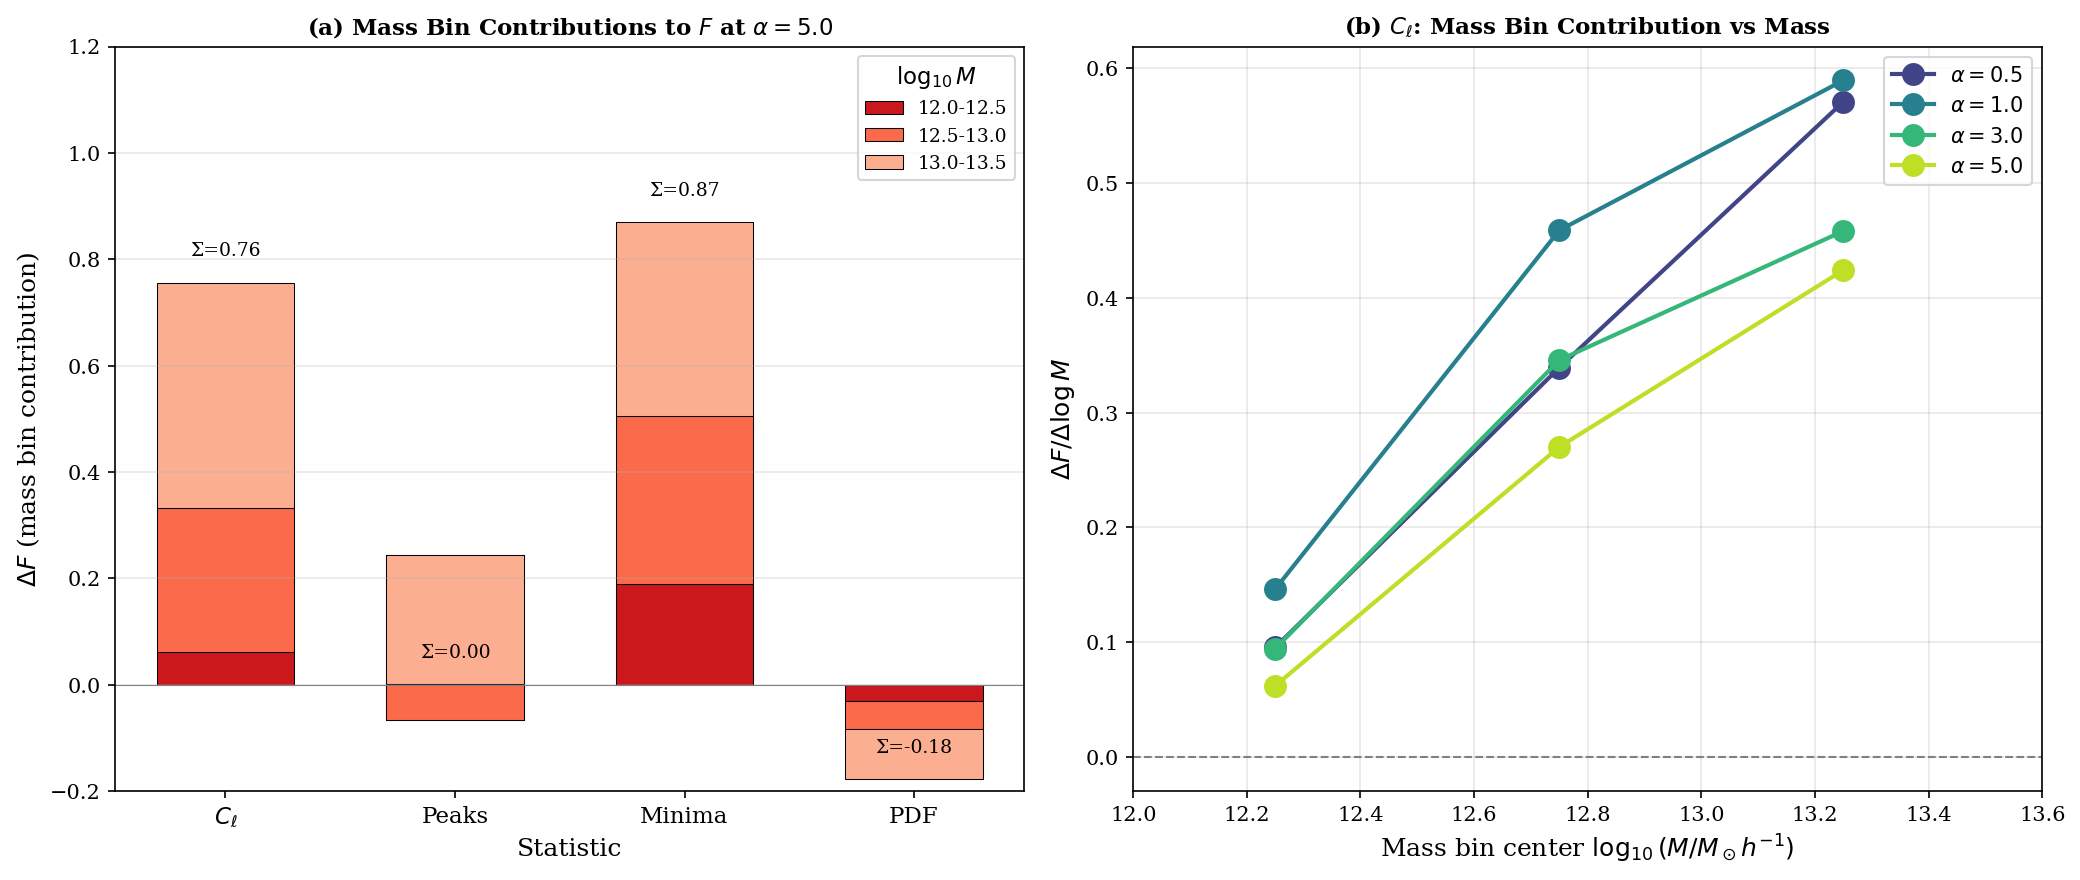

In [24]:
# ============================================================
# Figure: ΔF/ΔlogM - Mass Bin Contributions (Stacked Bar Chart)
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Mass bin labels
mass_bin_labels = [f'$10^{{{m_lo:.1f}}}$-$10^{{{m_hi:.1f}}}$' 
                   for m_lo, m_hi in zip(LOG_MASS_EDGES[:-1], LOG_MASS_EDGES[1:])]
mass_bin_labels_short = [f'{m_lo:.1f}-{m_hi:.1f}' 
                         for m_lo, m_hi in zip(LOG_MASS_EDGES[:-1], LOG_MASS_EDGES[1:])]

# Colors for mass bins (low mass = red, high mass = light)
colors_mass_bins = ['#cb181d', '#fb6a4a', '#fcae91']

# Select statistics to show
stats_to_plot = [r'$C_\ell$', 'Peaks', 'Minima', 'PDF']
stats_available = [s for s in stats_to_plot if s in deltaF_mass]

# Left panel: Stacked bar chart at α=5.0
ax = axes[0]
x = np.arange(len(stats_available))
width = 0.6
bottom = np.zeros(len(stats_available))

for i, (m_lo, m_hi) in enumerate(zip(LOG_MASS_EDGES[:-1], LOG_MASS_EDGES[1:])):
    values = [deltaF_mass[s][i, 3] for s in stats_available]  # α=5.0 is index 3
    ax.bar(x, values, width, bottom=bottom, label=mass_bin_labels_short[i], 
           color=colors_mass_bins[i], edgecolor='black', linewidth=0.5)
    bottom += np.array(values)

ax.axhline(0, color='gray', ls='-', lw=0.5)
ax.set_xlabel('Statistic', fontsize=12)
ax.set_ylabel(r'$\Delta F$ (mass bin contribution)', fontsize=12)
ax.set_title(r'(a) Mass Bin Contributions to $F$ at $\alpha=5.0$', fontsize=11, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(stats_available, fontsize=11)
ax.legend(title=r'$\log_{10} M$', loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(-0.2, 1.2)

# Add total F value as text
for i, s in enumerate(stats_available):
    total = sum([deltaF_mass[s][j, 3] for j in range(len(LOG_MASS_EDGES)-1)])
    ax.text(i, total + 0.05, f'Σ={total:.2f}', ha='center', fontsize=9)

# Right panel: ΔF/ΔlogM vs mass for different α values
ax = axes[1]
alpha_colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(ALPHA_VALUES)))
mass_mids = [0.5*(m_lo + m_hi) for m_lo, m_hi in zip(LOG_MASS_EDGES[:-1], LOG_MASS_EDGES[1:])]

# Plot C_ell as primary example
stat = r'$C_\ell$'
for j, alpha in enumerate(ALPHA_VALUES):
    deltaF_values = deltaF_mass[stat][:, j]
    ax.plot(mass_mids, deltaF_values, 'o-', color=alpha_colors[j], 
            lw=2, ms=10, label=fr'$\alpha={alpha}$')

ax.axhline(0, color='gray', ls='--', lw=1)
ax.set_xlabel(r'Mass bin center $\log_{10}(M/M_\odot h^{-1})$', fontsize=12)
ax.set_ylabel(r'$\Delta F / \Delta \log M$', fontsize=12)
ax.set_title(fr'(b) $C_\ell$: Mass Bin Contribution vs Mass', fontsize=11, fontweight='bold')
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim(12.0, 13.6)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'fig_deltaF_mass_contributions.pdf')
plt.savefig(OUTPUT_DIR / 'fig_deltaF_mass_contributions.png', dpi=300)
plt.show()

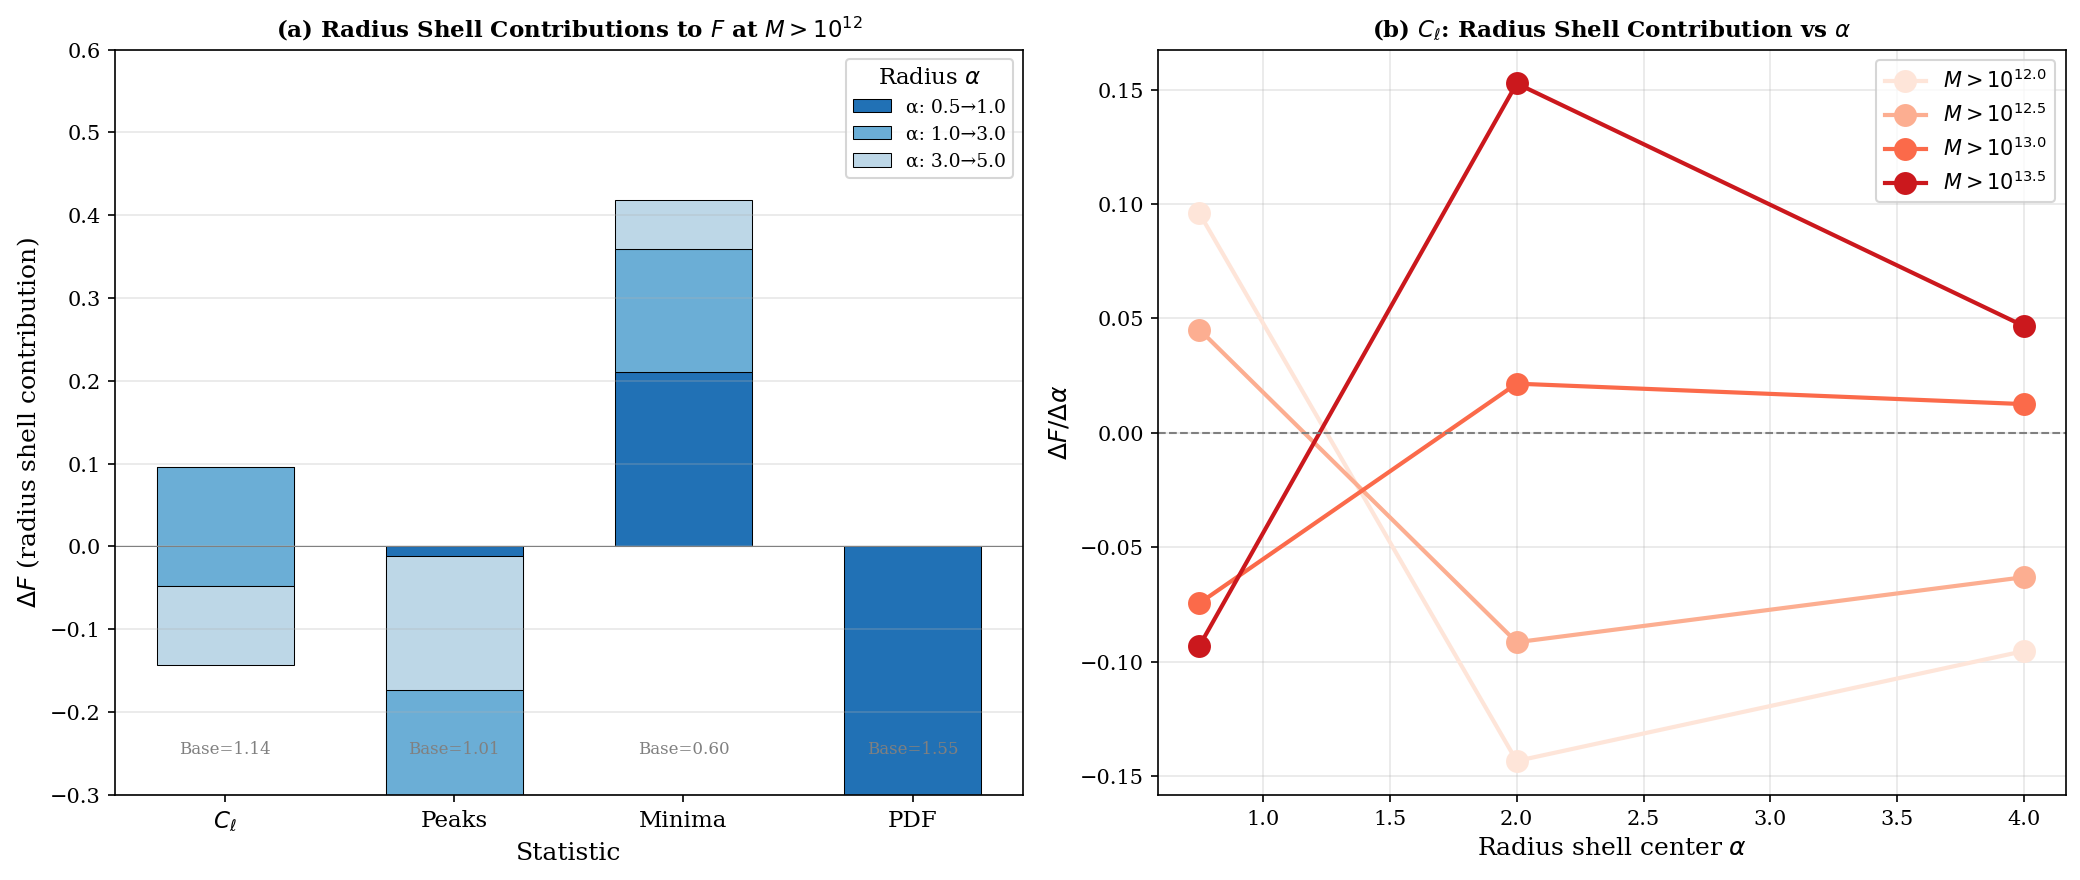

In [25]:
# ============================================================
# Figure: ΔF/Δα - Radius Shell Contributions
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Radius shell labels
radius_shell_labels = [f'α: {a_lo:.1f}→{a_hi:.1f}' 
                       for a_lo, a_hi in zip(ALPHA_VALUES[:-1], ALPHA_VALUES[1:])]

# Colors for radius shells (inner = dark, outer = light)
colors_radius = ['#2171b5', '#6baed6', '#bdd7e7']

# Left panel: Stacked bar chart at M>10^12
ax = axes[0]
x = np.arange(len(stats_available))
width = 0.6
bottom = np.zeros(len(stats_available))

for j, (a_lo, a_hi) in enumerate(zip(ALPHA_VALUES[:-1], ALPHA_VALUES[1:])):
    values = [deltaF_radius[s][0, j] for s in stats_available]  # M>10^12 is index 0
    ax.bar(x, values, width, bottom=bottom, label=radius_shell_labels[j], 
           color=colors_radius[j], edgecolor='black', linewidth=0.5)
    bottom += np.array(values)

ax.axhline(0, color='gray', ls='-', lw=0.5)
ax.set_xlabel('Statistic', fontsize=12)
ax.set_ylabel(r'$\Delta F$ (radius shell contribution)', fontsize=12)
ax.set_title(r'(a) Radius Shell Contributions to $F$ at $M > 10^{12}$', fontsize=11, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(stats_available, fontsize=11)
ax.legend(title=r'Radius $\alpha$', loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(-0.3, 0.6)

# Add baseline F(α=0.5) value
for i, s in enumerate(stats_available):
    F_base = all_F_matrices[s][0, 0]  # F at M>10^12, α=0.5
    total_delta = sum([deltaF_radius[s][0, j] for j in range(len(ALPHA_VALUES)-1)])
    ax.text(i, -0.25, f'Base={F_base:.2f}', ha='center', fontsize=8, color='gray')

# Right panel: ΔF/Δα vs α for different mass thresholds
ax = axes[1]
mass_colors = COLORS_MASS[::-1]  # Reverse so low mass is darker
alpha_mids = [0.5*(a_lo + a_hi) for a_lo, a_hi in zip(ALPHA_VALUES[:-1], ALPHA_VALUES[1:])]

# Plot C_ell as primary example
stat = r'$C_\ell$'
for i, m in enumerate(LOG_MASS_EDGES):
    deltaF_values = deltaF_radius[stat][i, :]
    ax.plot(alpha_mids, deltaF_values, 'o-', color=mass_colors[i], 
            lw=2, ms=10, label=fr'$M > 10^{{{m:.1f}}}$')

ax.axhline(0, color='gray', ls='--', lw=1)
ax.set_xlabel(r'Radius shell center $\alpha$', fontsize=12)
ax.set_ylabel(r'$\Delta F / \Delta \alpha$', fontsize=12)
ax.set_title(fr'(b) $C_\ell$: Radius Shell Contribution vs $\alpha$', fontsize=11, fontweight='bold')
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'fig_deltaF_radius_contributions.pdf')
plt.savefig(OUTPUT_DIR / 'fig_deltaF_radius_contributions.png', dpi=300)
plt.show()

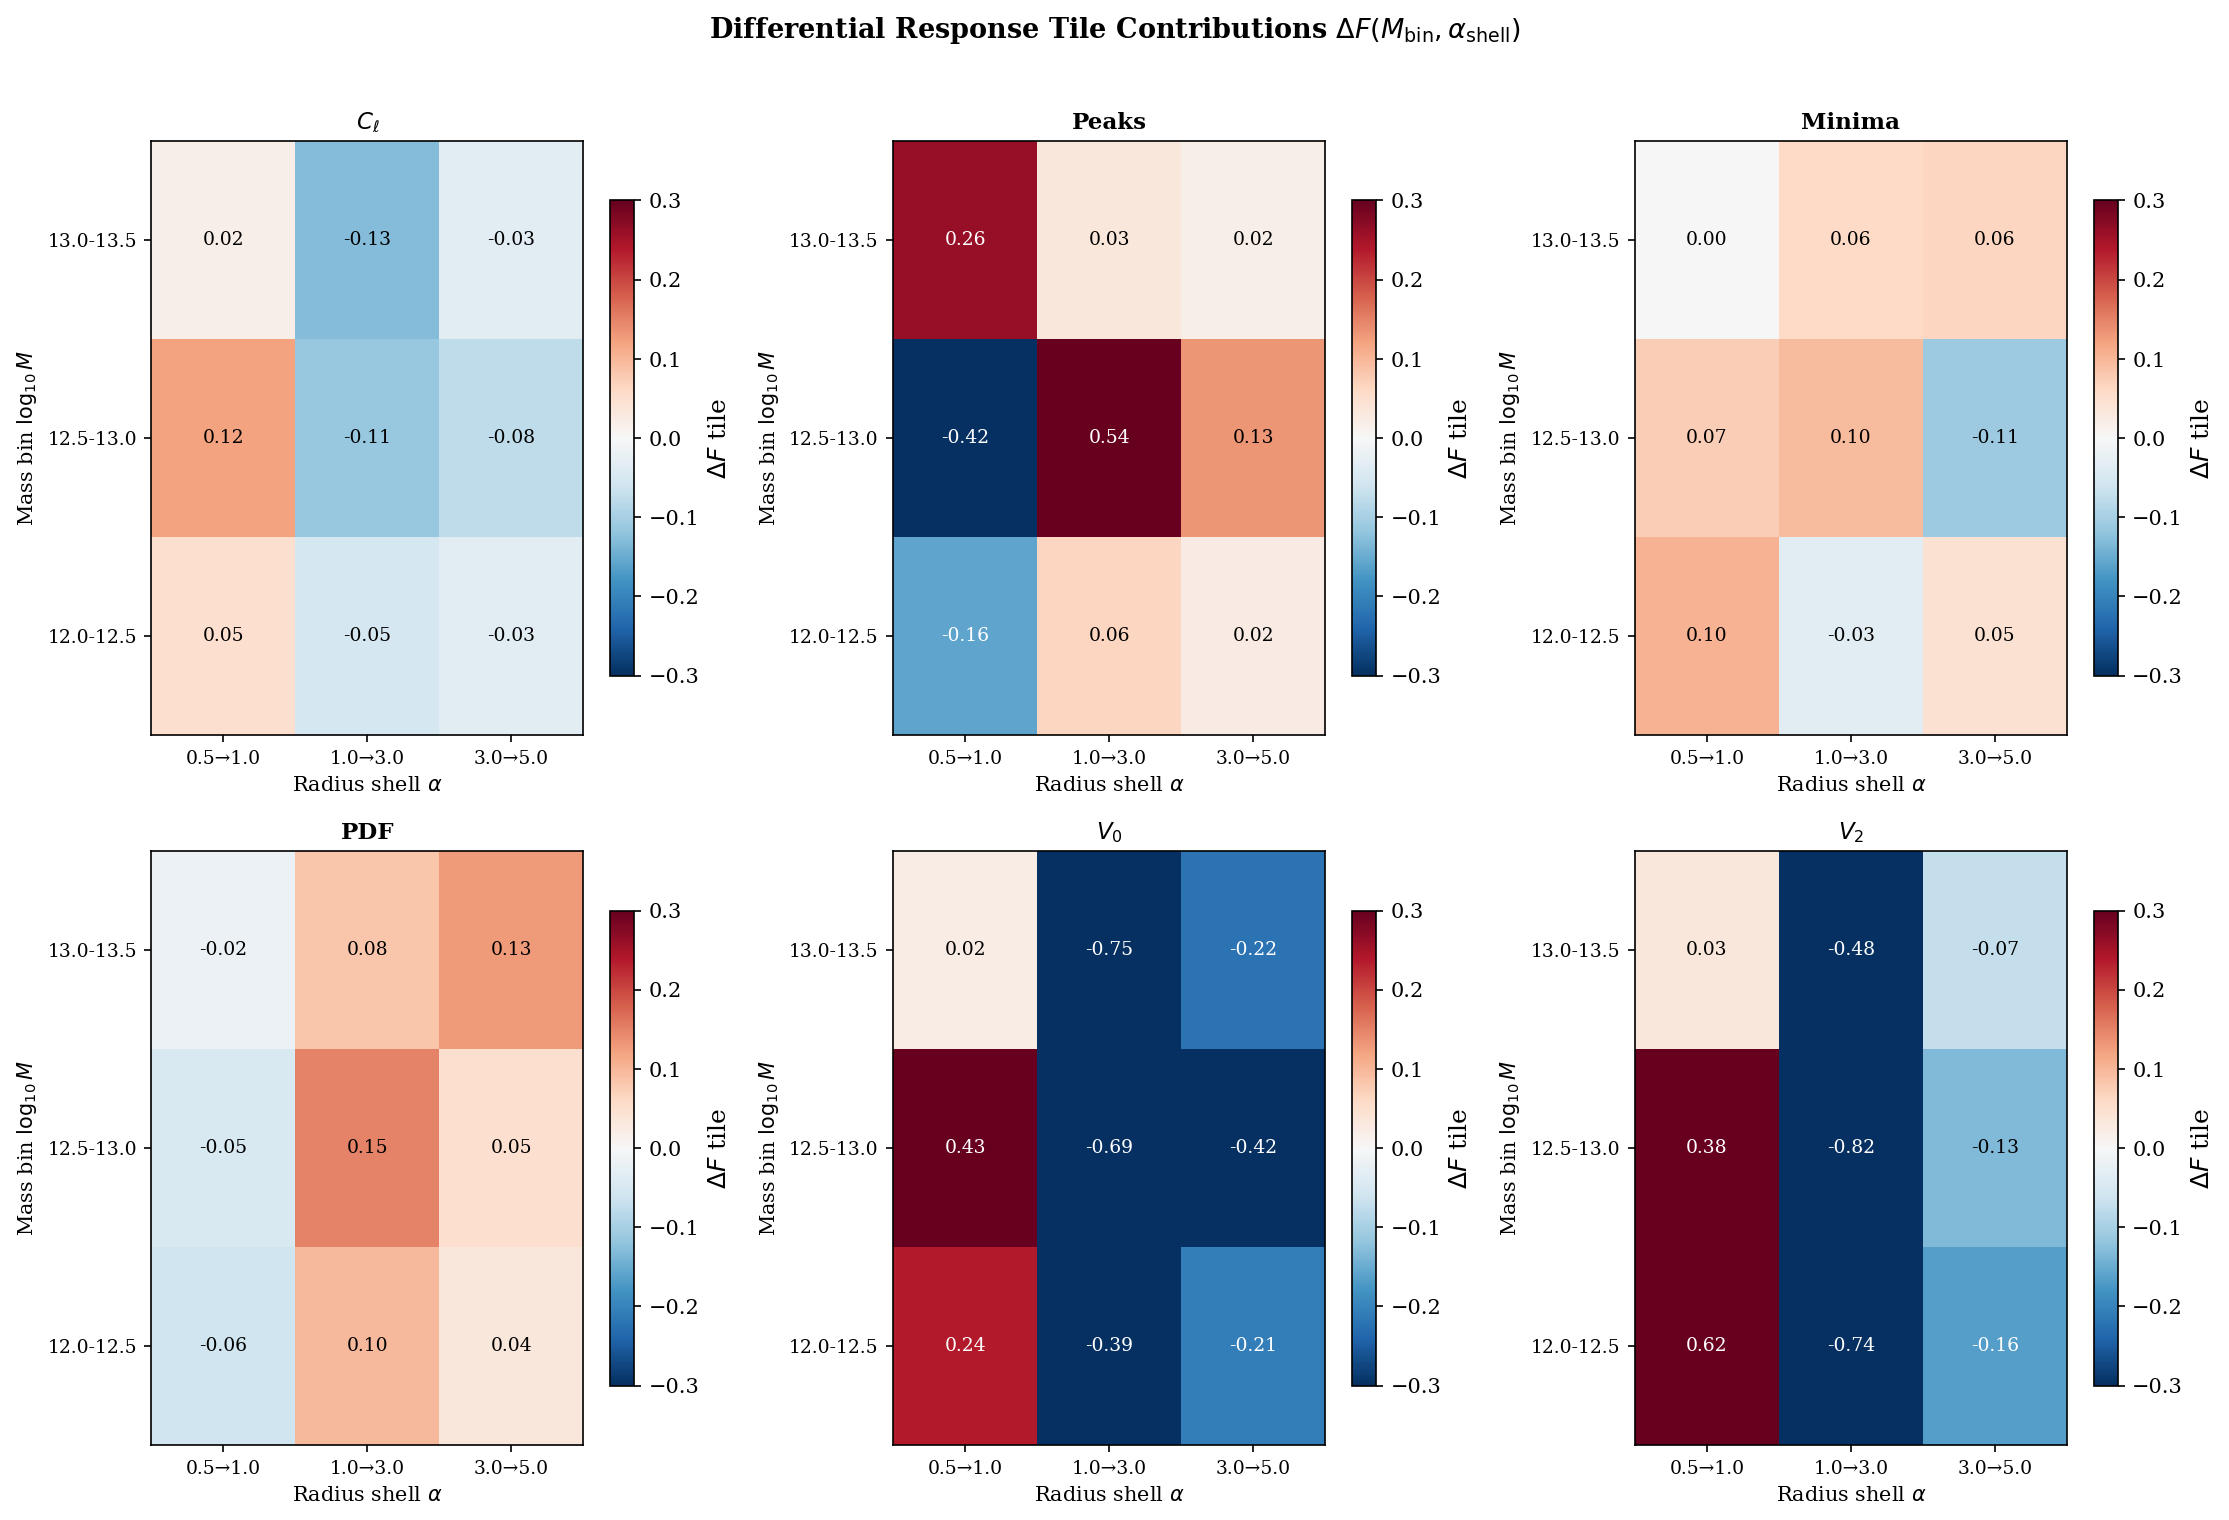


=== Tile Contribution Summary ===
Positive ΔF: This (M, α) tile adds to the baryonic effect
Negative ΔF: This (M, α) tile reduces the baryonic effect

Dominant tiles (|ΔF| > 0.1) for C_ℓ:
  M=[12.5,13.0], α=[0.5,1.0]: ΔF = 0.120
  M=[12.5,13.0], α=[1.0,3.0]: ΔF = -0.113
  M=[13.0,13.5], α=[1.0,3.0]: ΔF = -0.131


In [26]:
# ============================================================
# Figure: 2D Heatmap of ΔF contributions (Mass × Radius)
# ============================================================

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# We'll create heatmaps showing the differential tile contributions
# This combines mass bin × radius shell to show which (M, α) tiles matter most

stats_for_heatmap = [r'$C_\ell$', 'Peaks', 'Minima', 'PDF', '$V_0$', '$V_2$']
stats_for_heatmap = [s for s in stats_for_heatmap if s in all_F_matrices]

# Compute tile contributions: approximate by ΔF_mass * ΔF_radius / F_total
# Or directly use: F(M_i, α_j) - F(M_i, α_{j-1}) - F(M_{i+1}, α_j) + F(M_{i+1}, α_{j-1})
def compute_tile_contributions(F_mat):
    """Compute approximate contribution of each (mass bin, radius shell) tile."""
    n_mass, n_alpha = F_mat.shape
    tiles = np.zeros((n_mass-1, n_alpha-1))
    for i in range(n_mass-1):
        for j in range(n_alpha-1):
            # Tile contribution = change in F when adding this specific tile
            # ΔF_tile = [F(M_i, α_{j+1}) - F(M_i, α_j)] - [F(M_{i+1}, α_{j+1}) - F(M_{i+1}, α_j)]
            tiles[i, j] = (F_mat[i, j+1] - F_mat[i, j]) - (F_mat[i+1, j+1] - F_mat[i+1, j])
    return tiles

for ax_idx, stat in enumerate(stats_for_heatmap[:6]):
    ax = axes.flat[ax_idx]
    
    F_mat = all_F_matrices[stat]
    tiles = compute_tile_contributions(F_mat)
    
    # Create heatmap
    im = ax.imshow(tiles, cmap='RdBu_r', aspect='auto', 
                   vmin=-0.3, vmax=0.3, origin='lower')
    
    # Labels
    ax.set_xticks(range(len(ALPHA_VALUES)-1))
    ax.set_xticklabels([f'{a_lo:.1f}→{a_hi:.1f}' 
                        for a_lo, a_hi in zip(ALPHA_VALUES[:-1], ALPHA_VALUES[1:])], fontsize=9)
    ax.set_yticks(range(len(LOG_MASS_EDGES)-1))
    ax.set_yticklabels([f'{m_lo:.1f}-{m_hi:.1f}' 
                        for m_lo, m_hi in zip(LOG_MASS_EDGES[:-1], LOG_MASS_EDGES[1:])], fontsize=9)
    
    ax.set_xlabel(r'Radius shell $\alpha$', fontsize=10)
    ax.set_ylabel(r'Mass bin $\log_{10} M$', fontsize=10)
    ax.set_title(f'{stat}', fontsize=11, fontweight='bold')
    
    # Annotate with values
    for i in range(tiles.shape[0]):
        for j in range(tiles.shape[1]):
            val = tiles[i, j]
            color = 'white' if abs(val) > 0.15 else 'black'
            ax.text(j, i, f'{val:.2f}', ha='center', va='center', fontsize=9, color=color)
    
    plt.colorbar(im, ax=ax, label=r'$\Delta F$ tile', shrink=0.8)

# Hide unused subplots if less than 6 stats
for ax_idx in range(len(stats_for_heatmap), 6):
    axes.flat[ax_idx].axis('off')

plt.suptitle(r'Differential Response Tile Contributions $\Delta F(M_{\rm bin}, \alpha_{\rm shell})$', 
             fontsize=13, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'fig_deltaF_tile_heatmap.pdf')
plt.savefig(OUTPUT_DIR / 'fig_deltaF_tile_heatmap.png', dpi=300)
plt.show()

# Print summary
print("\n=== Tile Contribution Summary ===")
print("Positive ΔF: This (M, α) tile adds to the baryonic effect")
print("Negative ΔF: This (M, α) tile reduces the baryonic effect")
print("\nDominant tiles (|ΔF| > 0.1) for C_ℓ:")
tiles_Cl = compute_tile_contributions(all_F_matrices[r'$C_\ell$'])
for i in range(tiles_Cl.shape[0]):
    for j in range(tiles_Cl.shape[1]):
        if abs(tiles_Cl[i, j]) > 0.1:
            m_lo, m_hi = LOG_MASS_EDGES[i], LOG_MASS_EDGES[i+1]
            a_lo, a_hi = ALPHA_VALUES[j], ALPHA_VALUES[j+1]
            print(f"  M=[{m_lo:.1f},{m_hi:.1f}], α=[{a_lo},{a_hi}]: ΔF = {tiles_Cl[i,j]:.3f}")

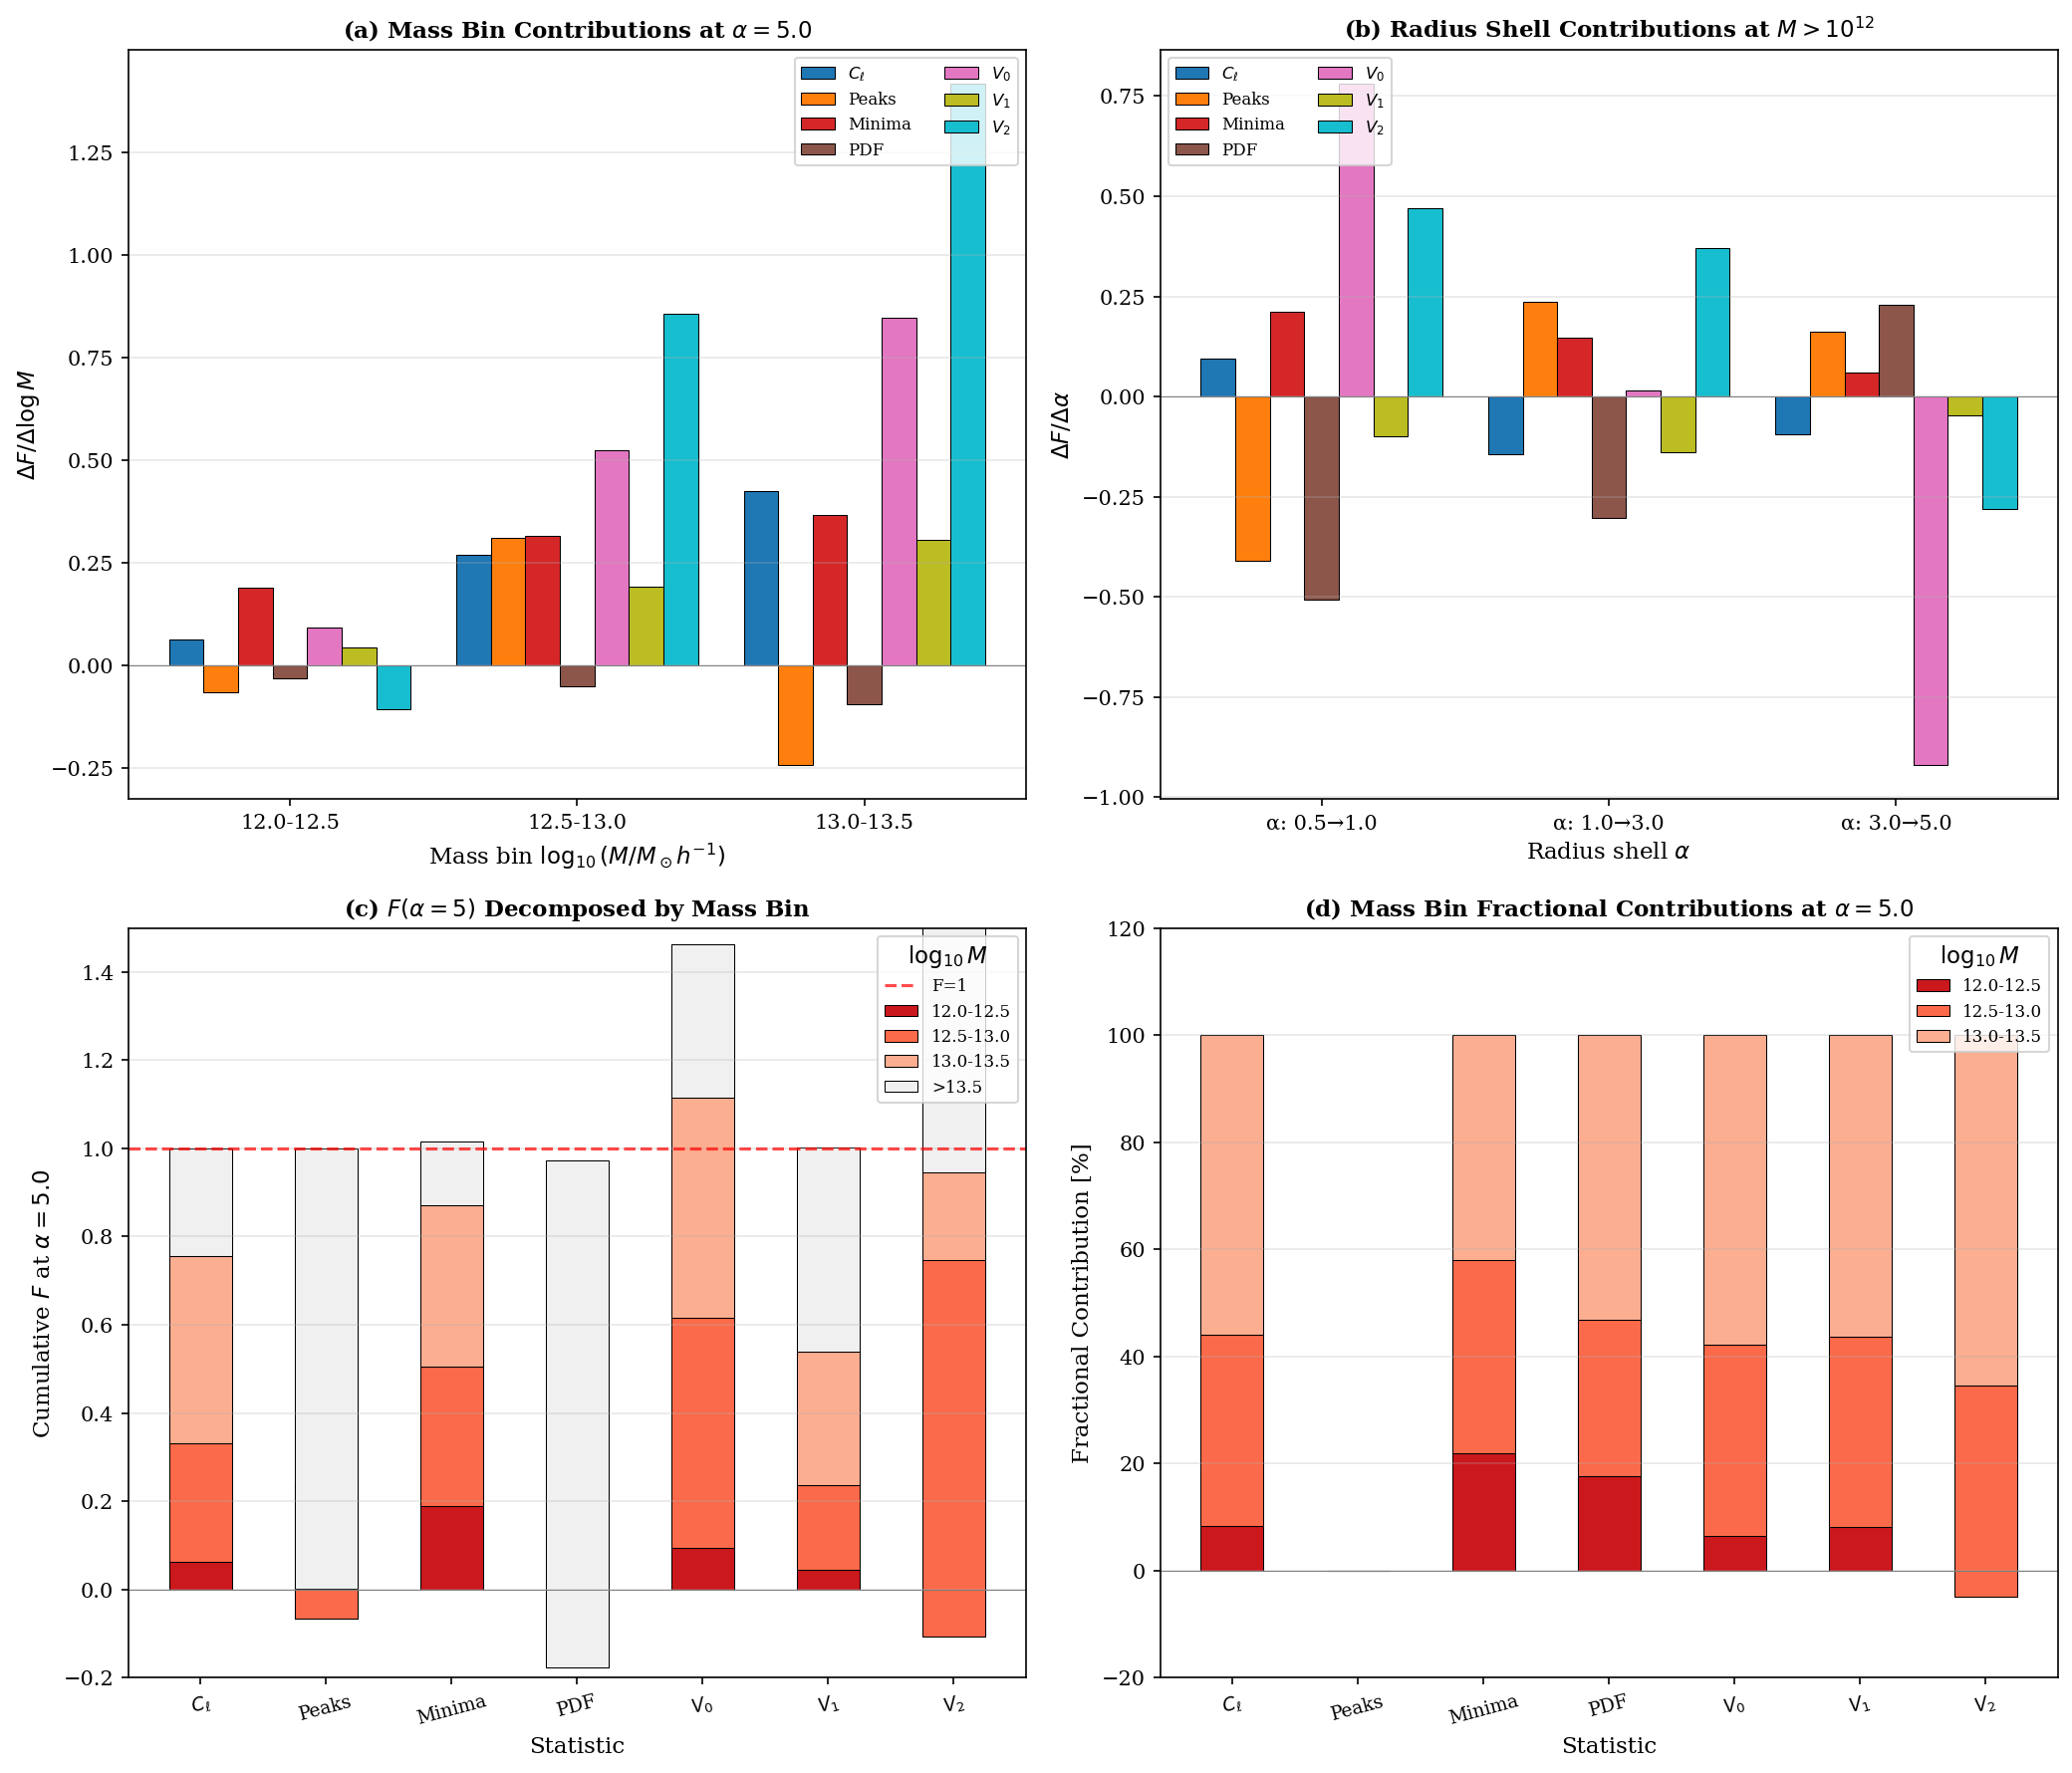


KEY INSIGHTS: Differential Response Analysis

Which mass range contributes most to the baryonic effect?
  $C_\ell$: Mass bin [13.0, 13.5] dominates (56%)
  Minima: Mass bin [13.0, 13.5] dominates (42%)
  PDF: Mass bin [13.0, 13.5] dominates (53%)
  $V_0$: Mass bin [13.0, 13.5] dominates (58%)
  $V_1$: Mass bin [13.0, 13.5] dominates (56%)
  $V_2$: Mass bin [13.0, 13.5] dominates (65%)

Which radius range contributes most?
  $C_\ell$: Radius shell [1.0, 3.0] (ΔF=-0.143)
  Peaks: Radius shell [0.5, 1.0] (ΔF=-0.410)
  Minima: Radius shell [0.5, 1.0] (ΔF=0.211)
  PDF: Radius shell [0.5, 1.0] (ΔF=-0.508)
  $V_0$: Radius shell [3.0, 5.0] (ΔF=-0.920)
  $V_1$: Radius shell [1.0, 3.0] (ΔF=-0.139)
  $V_2$: Radius shell [0.5, 1.0] (ΔF=0.469)


In [27]:
# ============================================================
# Figure: Comprehensive ΔF Summary - All Statistics Comparison
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Panel (a): ΔF/ΔlogM at α=5.0 for all statistics
ax = axes[0, 0]
x = np.arange(len(mass_bin_labels_short))
width = 0.12
stat_list = list(deltaF_mass.keys())
n_stats = len(stat_list)
offsets = np.linspace(-width*(n_stats-1)/2, width*(n_stats-1)/2, n_stats)

stat_colors = plt.cm.tab10(np.linspace(0, 1, n_stats))
for idx, (stat, color) in enumerate(zip(stat_list, stat_colors)):
    values = deltaF_mass[stat][:, 3]  # α=5.0
    ax.bar(x + offsets[idx], values, width, label=stat, color=color, edgecolor='black', linewidth=0.5)

ax.axhline(0, color='gray', ls='-', lw=0.5)
ax.set_xlabel(r'Mass bin $\log_{10}(M/M_\odot h^{-1})$', fontsize=11)
ax.set_ylabel(r'$\Delta F / \Delta \log M$', fontsize=11)
ax.set_title(r'(a) Mass Bin Contributions at $\alpha=5.0$', fontsize=11, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(mass_bin_labels_short, fontsize=10)
ax.legend(loc='upper right', fontsize=8, ncol=2)
ax.grid(True, alpha=0.3, axis='y')

# Panel (b): ΔF/Δα at M>10^12 for all statistics  
ax = axes[0, 1]
x = np.arange(len(radius_shell_labels))
for idx, (stat, color) in enumerate(zip(stat_list, stat_colors)):
    values = deltaF_radius[stat][0, :]  # M>10^12
    ax.bar(x + offsets[idx], values, width, label=stat, color=color, edgecolor='black', linewidth=0.5)

ax.axhline(0, color='gray', ls='-', lw=0.5)
ax.set_xlabel(r'Radius shell $\alpha$', fontsize=11)
ax.set_ylabel(r'$\Delta F / \Delta \alpha$', fontsize=11)
ax.set_title(r'(b) Radius Shell Contributions at $M > 10^{12}$', fontsize=11, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(radius_shell_labels, fontsize=10)
ax.legend(loc='upper left', fontsize=8, ncol=2)
ax.grid(True, alpha=0.3, axis='y')

# Panel (c): Total F at α=5.0 broken down by mass bins (stacked)
ax = axes[1, 0]
x = np.arange(len(stat_list))
width = 0.5
bottom = np.zeros(len(stat_list))

for i, (m_lo, m_hi) in enumerate(zip(LOG_MASS_EDGES[:-1], LOG_MASS_EDGES[1:])):
    values = [deltaF_mass[s][i, 3] for s in stat_list]
    ax.bar(x, values, width, bottom=bottom, label=f'{m_lo:.1f}-{m_hi:.1f}', 
           color=colors_mass_bins[i], edgecolor='black', linewidth=0.5)
    bottom += np.array(values)

# Add the remaining contribution (from M>10^13.5)
F_at_highest_mass = [all_F_matrices[s][3, 3] for s in stat_list]  # F(M>10^13.5, α=5)
ax.bar(x, F_at_highest_mass, width, bottom=bottom, label='>13.5', 
       color='#f0f0f0', edgecolor='black', linewidth=0.5)

ax.axhline(1.0, color='red', ls='--', lw=1.5, alpha=0.7, label='F=1')
ax.axhline(0, color='gray', ls='-', lw=0.5)
ax.set_xlabel('Statistic', fontsize=11)
ax.set_ylabel(r'Cumulative $F$ at $\alpha=5.0$', fontsize=11)
ax.set_title(r'(c) $F(\alpha=5)$ Decomposed by Mass Bin', fontsize=11, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(stat_list, fontsize=9, rotation=15)
ax.legend(title=r'$\log_{10} M$', loc='upper right', fontsize=8)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(-0.2, 1.5)

# Panel (d): Ratio of contributions - which mass bin dominates?
ax = axes[1, 1]

# Compute fractional contribution of each mass bin
mass_fractions = {}
for stat in stat_list:
    total = sum([deltaF_mass[stat][i, 3] for i in range(len(LOG_MASS_EDGES)-1)])
    if abs(total) > 0.01:
        fracs = [deltaF_mass[stat][i, 3] / total * 100 for i in range(len(LOG_MASS_EDGES)-1)]
    else:
        fracs = [0, 0, 0]
    mass_fractions[stat] = fracs

x = np.arange(len(stat_list))
bottom = np.zeros(len(stat_list))

for i, (m_lo, m_hi) in enumerate(zip(LOG_MASS_EDGES[:-1], LOG_MASS_EDGES[1:])):
    values = [mass_fractions[s][i] for s in stat_list]
    ax.bar(x, values, width, bottom=bottom, label=f'{m_lo:.1f}-{m_hi:.1f}', 
           color=colors_mass_bins[i], edgecolor='black', linewidth=0.5)
    bottom += np.array(values)

ax.axhline(0, color='gray', ls='-', lw=0.5)
ax.set_xlabel('Statistic', fontsize=11)
ax.set_ylabel(r'Fractional Contribution [%]', fontsize=11)
ax.set_title(r'(d) Mass Bin Fractional Contributions at $\alpha=5.0$', fontsize=11, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(stat_list, fontsize=9, rotation=15)
ax.legend(title=r'$\log_{10} M$', loc='upper right', fontsize=8)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(-20, 120)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'fig_deltaF_comprehensive_summary.pdf')
plt.savefig(OUTPUT_DIR / 'fig_deltaF_comprehensive_summary.png', dpi=300)
plt.show()

# Print key insights
print("\n" + "="*70)
print("KEY INSIGHTS: Differential Response Analysis")
print("="*70)
print("\nWhich mass range contributes most to the baryonic effect?")
for stat in stat_list:
    total = sum([deltaF_mass[stat][i, 3] for i in range(len(LOG_MASS_EDGES)-1)])
    if abs(total) > 0.01:
        dominant_idx = np.argmax([abs(deltaF_mass[stat][i, 3]) for i in range(len(LOG_MASS_EDGES)-1)])
        m_lo, m_hi = LOG_MASS_EDGES[dominant_idx], LOG_MASS_EDGES[dominant_idx+1]
        print(f"  {stat}: Mass bin [{m_lo:.1f}, {m_hi:.1f}] dominates ({mass_fractions[stat][dominant_idx]:.0f}%)")

print("\nWhich radius range contributes most?")
for stat in stat_list:
    dominant_idx = np.argmax([abs(deltaF_radius[stat][0, j]) for j in range(len(ALPHA_VALUES)-1)])
    a_lo, a_hi = ALPHA_VALUES[dominant_idx], ALPHA_VALUES[dominant_idx+1]
    val = deltaF_radius[stat][0, dominant_idx]
    print(f"  {stat}: Radius shell [{a_lo:.1f}, {a_hi:.1f}] (ΔF={val:.3f})")

---
### Interpretation of Differential Responses

**ΔF/ΔlogM (Mass bin contributions)**:
- Shows how much the cumulative response F increases when including halos in a specific mass range
- Positive ΔF: This mass bin adds to the baryonic effect (Hydro differs from DMO)
- The sum of all ΔF_mass should approximately equal F(M>10^12) - F(M>10^13.5)

**ΔF/Δα (Radius shell contributions)**:
- Shows how much F changes when extending the replacement radius
- Positive ΔF: Baryonic effects extend to larger radii
- Negative ΔF: Inner regions have opposite sign effects that get cancelled at larger radii

**Key Physical Insights**:
1. **Mass hierarchy**: Lower mass halos (10^12-10^13) typically contribute more because they are more numerous
2. **Radius dependence**: Inner regions (α < 1) capture immediate feedback effects; outer regions capture gas redistribution
3. **Statistic-dependent**: Different statistics may be sensitive to different mass/radius ranges

---
## Redshift Evolution of Baryonic Response

Now we analyze how the cumulative response F(M_min, α) evolves with source redshift. The array job (2368578) computes statistics for all 41 redshift slices (z=0 to z=40).

In [ ]:
# ============================================================
# Load Response Data for All Redshifts
# ============================================================

# Check which redshifts have completed
all_z_indices = list(range(41))  # z=0 to z=40
available_z = []

print("=== Checking available redshift data ===")
for z in all_z_indices:
    cl_file = DATA_DIR / f'response_C_ell_z{z:02d}.npz'
    if cl_file.exists():
        available_z.append(z)

print(f"Available redshifts: {len(available_z)}/{len(all_z_indices)}")
print(f"Missing: {[z for z in all_z_indices if z not in available_z]}")

# Load data for all available redshifts
def load_F_matrix_for_z(z, stat_key='C_ell'):
    """Load cumulative response matrix F(M_min, α) for a given redshift."""
    npz_file = DATA_DIR / f'response_{stat_key}_z{z:02d}.npz'
    pkl_file = DATA_DIR / f'response_{stat_key}_z{z:02d}_dicts.pkl'
    
    if not npz_file.exists():
        return None, None
    
    data = np.load(npz_file, allow_pickle=True)
    with open(pkl_file, 'rb') as f:
        dicts = pickle.load(f)
    
    return data, dicts

def build_F_matrix_from_dicts(cumulative_responses, stat_key, masses, alphas):
    """Build F matrix from cumulative responses dict."""
    F_matrix = np.full((len(masses), len(alphas)), np.nan)
    
    for i, m in enumerate(masses):
        for j, a in enumerate(alphas):
            key = f'M{m:.1e}_a{a}'
            if key in cumulative_responses:
                F = cumulative_responses[key]['F_S']
                # Average F over relevant bins
                if stat_key == 'C_ell':
                    # Average over ℓ range 500-5000
                    F_mean = np.nanmean(F)
                else:
                    F_mean = np.nanmean(F[np.isfinite(F)])
                F_matrix[i, j] = F_mean
    
    return F_matrix

# Load F matrices for all available redshifts
masses = [1.00e12, 3.16e12, 1.00e13, 3.16e13]
alphas = [0.5, 1.0, 3.0, 5.0]

F_vs_z = {}  # {stat: {z: F_matrix}}
for stat_key in ['C_ell', 'peaks', 'minima', 'pdf', 'V0', 'V1', 'V2']:
    F_vs_z[stat_key] = {}
    for z in available_z:
        data, dicts = load_F_matrix_for_z(z, stat_key)
        if dicts is not None and 'cumulative_responses' in dicts:
            F_mat = build_F_matrix_from_dicts(dicts['cumulative_responses'], stat_key, masses, alphas)
            F_vs_z[stat_key][z] = F_mat

print(f"\nLoaded F matrices for {len(F_vs_z['C_ell'])} redshifts")
if available_z:
    print(f"Redshift range: z={min(available_z)} to z={max(available_z)}")

In [ ]:
# ============================================================
# Figure: F(M_min, α=5) vs Redshift for C_ell
# ============================================================

if len(available_z) > 1:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Get z values and corresponding F values for each mass threshold
    z_values = np.array(sorted(F_vs_z['C_ell'].keys()))
    
    # Panel (a): F(M>10^12, α=5) vs z for different statistics
    ax = axes[0, 0]
    stat_colors = {'C_ell': 'tab:blue', 'peaks': 'tab:orange', 'minima': 'tab:green', 
                   'pdf': 'tab:red', 'V0': 'tab:purple'}
    
    for stat_key, color in stat_colors.items():
        if stat_key in F_vs_z and len(F_vs_z[stat_key]) > 0:
            z_vals = sorted(F_vs_z[stat_key].keys())
            F_vals = [F_vs_z[stat_key][z][0, 3] for z in z_vals]  # M>10^12, α=5
            ax.plot(z_vals, F_vals, 'o-', color=color, lw=2, ms=6, label=stat_key)
    
    ax.axhline(1.0, color='red', ls='--', lw=1.5, alpha=0.5)
    ax.set_xlabel('Redshift index z', fontsize=12)
    ax.set_ylabel(r'$F(M > 10^{12}, \alpha=5)$', fontsize=12)
    ax.set_title(r'(a) Response at $M > 10^{12}$ vs Redshift', fontsize=11, fontweight='bold')
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1.5)
    
    # Panel (b): F(M_min, α=5) vs z for C_ell at different mass thresholds
    ax = axes[0, 1]
    mass_colors = COLORS_MASS[::-1]
    
    for i, (m, label) in enumerate(zip(masses, MASS_LABELS)):
        z_vals = sorted(F_vs_z['C_ell'].keys())
        F_vals = [F_vs_z['C_ell'][z][i, 3] for z in z_vals]  # α=5
        ax.plot(z_vals, F_vals, 'o-', color=mass_colors[i], lw=2, ms=6, label=label)
    
    ax.axhline(1.0, color='red', ls='--', lw=1.5, alpha=0.5)
    ax.set_xlabel('Redshift index z', fontsize=12)
    ax.set_ylabel(r'$F(M_{\min}, \alpha=5)$', fontsize=12)
    ax.set_title(r'(b) $C_\ell$ Response vs Redshift (different $M_{\min}$)', fontsize=11, fontweight='bold')
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-0.2, 1.5)
    
    # Panel (c): F(M>10^12, α) vs z for different α
    ax = axes[1, 0]
    alpha_colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(alphas)))
    
    for j, (a, color) in enumerate(zip(alphas, alpha_colors)):
        z_vals = sorted(F_vs_z['C_ell'].keys())
        F_vals = [F_vs_z['C_ell'][z][0, j] for z in z_vals]  # M>10^12
        ax.plot(z_vals, F_vals, 'o-', color=color, lw=2, ms=6, label=fr'$\alpha={a}$')
    
    ax.axhline(1.0, color='red', ls='--', lw=1.5, alpha=0.5)
    ax.set_xlabel('Redshift index z', fontsize=12)
    ax.set_ylabel(r'$F(M > 10^{12}, \alpha)$', fontsize=12)
    ax.set_title(r'(c) $C_\ell$ Response vs Redshift (different $\alpha$)', fontsize=11, fontweight='bold')
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1.5)
    
    # Panel (d): ΔF/ΔlogM at α=5 vs z
    ax = axes[1, 1]
    mass_bin_labels = ['12.0-12.5', '12.5-13.0', '13.0-13.5']
    
    for i in range(len(masses)-1):
        z_vals = sorted(F_vs_z['C_ell'].keys())
        deltaF_vals = [F_vs_z['C_ell'][z][i, 3] - F_vs_z['C_ell'][z][i+1, 3] for z in z_vals]
        ax.plot(z_vals, deltaF_vals, 'o-', color=colors_mass_bins[i], lw=2, ms=6, 
                label=mass_bin_labels[i])
    
    ax.axhline(0, color='gray', ls='--', lw=1)
    ax.set_xlabel('Redshift index z', fontsize=12)
    ax.set_ylabel(r'$\Delta F / \Delta \log M$ at $\alpha=5$', fontsize=12)
    ax.set_title(r'(d) Mass Bin Contributions vs Redshift', fontsize=11, fontweight='bold')
    ax.legend(title=r'$\log M$ bin', loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    plt.suptitle('Redshift Evolution of Baryonic Response', fontsize=13, fontweight='bold', y=1.01)
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'fig_response_vs_redshift.pdf')
    plt.savefig(OUTPUT_DIR / 'fig_response_vs_redshift.png', dpi=300)
    plt.show()
else:
    print("Not enough redshift data available yet. Run the array job first.")

In [ ]:
# ============================================================
# Figure: 2D Heatmap of F(z, M_min) at α=5 - THE MONEY PLOT
# ============================================================

if len(available_z) > 1:
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    
    stats_for_heatmap = ['C_ell', 'peaks', 'minima', 'pdf', 'V0', 'V2']
    stats_for_heatmap = [s for s in stats_for_heatmap if s in F_vs_z and len(F_vs_z[s]) > 0]
    
    z_values = np.array(sorted(F_vs_z['C_ell'].keys()))
    
    for ax_idx, stat_key in enumerate(stats_for_heatmap[:6]):
        ax = axes.flat[ax_idx]
        
        # Build 2D array: F[z, mass_idx] at α=5
        F_2d = np.zeros((len(z_values), len(masses)))
        for zi, z in enumerate(z_values):
            if z in F_vs_z[stat_key]:
                F_2d[zi, :] = F_vs_z[stat_key][z][:, 3]  # α=5
        
        # Create heatmap
        im = ax.imshow(F_2d.T, cmap='RdYlBu_r', aspect='auto', 
                       vmin=0, vmax=1.2, origin='lower',
                       extent=[z_values[0]-0.5, z_values[-1]+0.5, -0.5, len(masses)-0.5])
        
        ax.set_xlabel('Redshift index z', fontsize=10)
        ax.set_ylabel(r'$\log_{10}(M_{\min})$', fontsize=10)
        ax.set_yticks(range(len(masses)))
        ax.set_yticklabels(['12.0', '12.5', '13.0', '13.5'], fontsize=9)
        ax.set_title(f'{stat_key}', fontsize=11, fontweight='bold')
        
        plt.colorbar(im, ax=ax, label=r'$F(M_{\min}, \alpha=5)$', shrink=0.8)
    
    # Hide unused subplots
    for ax_idx in range(len(stats_for_heatmap), 6):
        axes.flat[ax_idx].axis('off')
    
    plt.suptitle(r'Cumulative Response $F(M_{\min}, \alpha=5)$ vs Redshift', 
                 fontsize=13, fontweight='bold', y=1.01)
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'fig_F_vs_z_heatmap.pdf')
    plt.savefig(OUTPUT_DIR / 'fig_F_vs_z_heatmap.png', dpi=300)
    plt.show()
else:
    print("Not enough redshift data available yet.")

In [ ]:
# ============================================================
# Figure: ΔF/ΔlogM vs Redshift - Mass Contribution Evolution
# ============================================================

if len(available_z) > 1:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    z_values = np.array(sorted(F_vs_z['C_ell'].keys()))
    mass_bin_labels = ['12.0-12.5', '12.5-13.0', '13.0-13.5']
    
    for ax_idx, stat_key in enumerate(['C_ell', 'peaks', 'minima']):
        ax = axes[ax_idx]
        
        if stat_key not in F_vs_z or len(F_vs_z[stat_key]) == 0:
            ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
            continue
        
        # Compute ΔF/ΔlogM at α=5 for each z
        for i in range(len(masses)-1):
            z_vals = sorted(F_vs_z[stat_key].keys())
            deltaF_vals = []
            for z in z_vals:
                if z in F_vs_z[stat_key]:
                    dF = F_vs_z[stat_key][z][i, 3] - F_vs_z[stat_key][z][i+1, 3]
                    deltaF_vals.append(dF)
                else:
                    deltaF_vals.append(np.nan)
            
            ax.plot(z_vals, deltaF_vals, 'o-', color=colors_mass_bins[i], lw=2, ms=6, 
                    label=mass_bin_labels[i])
        
        ax.axhline(0, color='gray', ls='--', lw=1)
        ax.set_xlabel('Redshift index z', fontsize=11)
        ax.set_ylabel(r'$\Delta F / \Delta \log M$', fontsize=11)
        ax.set_title(f'{stat_key}', fontsize=11, fontweight='bold')
        ax.legend(title=r'$\log M$ bin', loc='upper right', fontsize=9)
        ax.grid(True, alpha=0.3)
        ax.set_ylim(-0.2, 0.8)
    
    plt.suptitle(r'Mass Bin Contributions $\Delta F/\Delta \log M$ vs Redshift (at $\alpha=5$)', 
                 fontsize=12, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'fig_deltaF_mass_vs_z.pdf')
    plt.savefig(OUTPUT_DIR / 'fig_deltaF_mass_vs_z.png', dpi=300)
    plt.show()
else:
    print("Not enough redshift data available yet.")

In [ ]:
# ============================================================
# Figure: THE ULTIMATE MONEY PLOT - 3D Surface of ΔF(M, z)
# ============================================================

if len(available_z) > 3:
    from mpl_toolkits.mplot3d import Axes3D
    
    fig = plt.figure(figsize=(14, 10))
    
    # Create 3D surface plot
    ax = fig.add_subplot(2, 2, 1, projection='3d')
    
    z_values = np.array(sorted(F_vs_z['C_ell'].keys()))
    mass_mids = np.array([12.25, 12.75, 13.25])  # Mid-points of mass bins
    
    # Build ΔF matrix: ΔF[z, mass_bin]
    deltaF_3d = np.zeros((len(z_values), len(mass_mids)))
    for zi, z in enumerate(z_values):
        if z in F_vs_z['C_ell']:
            for mi in range(len(masses)-1):
                deltaF_3d[zi, mi] = F_vs_z['C_ell'][z][mi, 3] - F_vs_z['C_ell'][z][mi+1, 3]
    
    Z_grid, M_grid = np.meshgrid(z_values, mass_mids)
    
    surf = ax.plot_surface(Z_grid, M_grid, deltaF_3d.T, cmap='RdYlBu_r', 
                           edgecolor='black', linewidth=0.2, alpha=0.8)
    
    ax.set_xlabel('Redshift index z', fontsize=10)
    ax.set_ylabel(r'$\log_{10}(M_{\rm bin})$', fontsize=10)
    ax.set_zlabel(r'$\Delta F / \Delta \log M$', fontsize=10)
    ax.set_title(r'$C_\ell$: Mass Bin Contribution Surface', fontsize=11, fontweight='bold')
    fig.colorbar(surf, ax=ax, shrink=0.5, label=r'$\Delta F$')
    
    # 2D contour plots for different statistics
    for idx, stat_key in enumerate(['C_ell', 'peaks', 'minima']):
        ax = fig.add_subplot(2, 2, idx+2)
        
        if stat_key not in F_vs_z or len(F_vs_z[stat_key]) == 0:
            ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
            continue
        
        # Build ΔF matrix
        deltaF_2d = np.zeros((len(z_values), len(mass_mids)))
        for zi, z in enumerate(z_values):
            if z in F_vs_z[stat_key]:
                for mi in range(len(masses)-1):
                    deltaF_2d[zi, mi] = F_vs_z[stat_key][z][mi, 3] - F_vs_z[stat_key][z][mi+1, 3]
        
        # Contour plot
        im = ax.contourf(z_values, mass_mids, deltaF_2d.T, levels=20, cmap='RdYlBu_r')
        ax.contour(z_values, mass_mids, deltaF_2d.T, levels=10, colors='black', linewidths=0.5, alpha=0.5)
        
        ax.set_xlabel('Redshift index z', fontsize=10)
        ax.set_ylabel(r'$\log_{10}(M_{\rm bin})$', fontsize=10)
        ax.set_title(f'{stat_key}: ' + r'$\Delta F / \Delta \log M$', fontsize=11, fontweight='bold')
        plt.colorbar(im, ax=ax, label=r'$\Delta F$')
    
    plt.suptitle('Mass Bin Contribution to Baryonic Response vs Redshift', 
                 fontsize=13, fontweight='bold', y=1.01)
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'fig_deltaF_3d_surface.pdf')
    plt.savefig(OUTPUT_DIR / 'fig_deltaF_3d_surface.png', dpi=300)
    plt.show()
    
    # Summary statistics
    print("\n=== Redshift Evolution Summary ===")
    print(f"Redshift range analyzed: z={min(z_values)} to z={max(z_values)}")
    
    # Find where each mass bin contributes most
    for mi, (m_lo, m_hi) in enumerate(zip([12.0, 12.5, 13.0], [12.5, 13.0, 13.5])):
        max_z = z_values[np.argmax(deltaF_3d[:, mi])]
        max_val = np.max(deltaF_3d[:, mi])
        print(f"Mass bin [{m_lo:.1f}, {m_hi:.1f}]: Max contribution ΔF={max_val:.3f} at z={max_z}")
else:
    print("Not enough redshift data available yet. Waiting for array job to complete.")

---
### Summary of Redshift Evolution

The figures above show how the baryonic response evolves with source redshift:

1. **F(M_min, α) vs z**: Shows whether the cumulative response is stable or evolves with redshift
2. **Heatmap F(z, M_min)**: 2D view showing which mass thresholds dominate at each redshift
3. **ΔF/ΔlogM vs z**: Shows how the contribution of each mass bin changes with redshift
4. **3D Surface**: Full view of the mass-redshift dependence of baryonic effects

**Key Questions Addressed**:
- Does the mass scale responsible for baryonic effects change with redshift?
- Are low-z or high-z sources more sensitive to baryonic physics?
- Which statistics show the strongest redshift evolution?